<div align="center">
    MA23M025

    Venkatesh Tentu
</div>

**Q1**

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

key="7836c2516a56fb9071600184ea90a0f6357f99dc"

In [ ]:
!pip install wandb

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from keras.datasets import fashion_mnist

# for the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns # only for plotting the confusion matrix

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tentuvenkatesh2 (tentuvenkatesh2-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


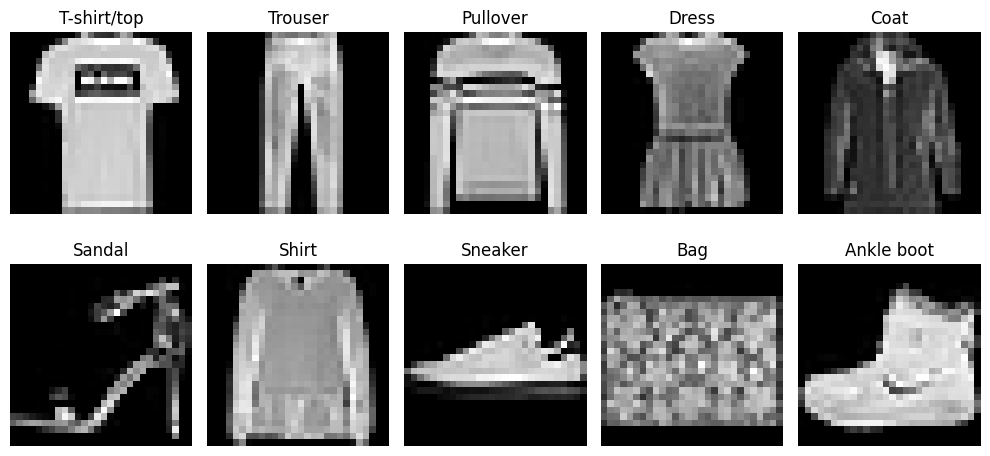

In [ ]:
# Initialize Weights & Biases
#key = input("enter wandb API KEY:")
wandb.init(project="DA6401_ASS1_Q1",name="Fashion_mnist")

# Load the dataset
(x, y), (x_test, y_test) = fashion_mnist.load_data()

# Class labels in Fashion-MNIST
target_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Select one sample image for each class
unique_class = np.unique(y)
images = []
labels = []
for class_label in unique_class:
    index = np.where(y == class_label)[0][0]
    images.append(x[index])
    labels.append(target_labels[class_label])

# Plot the images in a grid (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(labels[i])
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

# Log images to wandb
wandb.log({"Fashion-MNIST Samples": [wandb.Image(img, caption=label) for img, label in zip(images, labels)]})

# Finish wandb run
wandb.finish()

**Q2**

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.


In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Splitting data for validation
x_val = x_train[54000:]
y_val = y_train[54000:]

# Splitting data for training
x_train = x_train[:54000]
y_train = y_train[:54000]

# Reshape images into a 2D array (flattened pixels)
x_train = x_train.reshape(x_train.shape[0], 784)
x_val = x_val.reshape(x_val.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0

# One-hot encoding for labels
def one_hot_enc(labels, dimension=10):
    one_hot_labels = np.zeros((len(labels), dimension))
    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels

y_train_encode = one_hot_enc(y_train)
y_val_encode = one_hot_enc(y_val)
y_test_encode = one_hot_enc(y_test)

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Prevent overflow
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def sigmoid_deriv(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return np.where(x <= 0, 0, 1)

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1 - np.tanh(x)**2

# Cross-entropy loss function
def cross_entropy(y_hat, y, sum_norm, regpara):
    m = y.shape[0]
    logyhat = np.log(y_hat)
    loss = -np.sum(y * logyhat) / m + regpara / 2 * sum_norm
    return loss

# Dictionary for activation functions
activation_functions = {
    "sigmoid": sigmoid,
    "relu": relu,
    "tanh": tanh
}

activation_derivatives = {
    "sigmoid": sigmoid_deriv,
    "relu": relu_deriv,
    "tanh": tanh_deriv
}

In [ ]:
# Neural Network Class
class NeuralNetwork:
    def __init__(self, layer_sizes, activation_func="sigmoid", weight_init="random"):
        self.layer_sizes = layer_sizes
        self.activation_func = activation_func
        self.weights, self.biases = self.init_network(layer_sizes, weight_init)
        self.momenta_weights, self.momenta_biases = self.init_momenta_for_mgd()

    # Initialize network parameters
    def init_network(self, layer_sizes, weight_init):
        weights = []
        biases = []
        for i in range(len(layer_sizes) - 1):
            if weight_init == "xavier":
                stddev = np.sqrt(2 / (layer_sizes[i] + layer_sizes[i + 1]))
            else:
                stddev = 0.1  # Default initialization

            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * stddev
            bias = np.zeros((1, layer_sizes[i + 1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases

    # Initialize momenta for momentum-based gradient descent (MGD)
    def init_momenta_for_mgd(self):
        momenta_weights = []
        momenta_biases = []
        for i in range(len(self.layer_sizes) - 1):
            v_weight = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            v_bias = np.zeros((1, self.layer_sizes[i + 1]))
            momenta_weights.append(v_weight)
            momenta_biases.append(v_bias)
        return momenta_weights, momenta_biases

    # Forward propagation
    def feedforward(self, X):
        a = {}
        h = {"h0": X}
        for i in range(1, len(self.layer_sizes)):
            h_previous = h["h" + str(i-1)]
            a_current = np.dot(h_previous, self.weights[i-1]) + self.biases[i-1]
            a["a" + str(i)] = a_current
            if i == len(self.layer_sizes) - 1:  # Output layer
                h_current = softmax(a_current)
            else:
                h_current = activation_functions[self.activation_func](a_current)
            h["h" + str(i)] = h_current
        y_hat = h["h" + str(len(self.layer_sizes) - 1)]
        return h, a, y_hat

# Define network structure
layer_sizes = [784, 128, 10]

# Initialize the model
model_forward = NeuralNetwork(layer_sizes, activation_func="sigmoid", weight_init="random")

# Run forward propagation
_, _, y_hat = model_forward.feedforward(x_train)

# Print output for a sample
print('A probability distribution over the 10 classes by feedforward NN before training:\n', y_hat[5180])
print('Corresponding labeled output:\n', y_train_encode[5180])

A probability distribution over the 10 classes by feedforward NN before training:
 [0.0615744  0.21433112 0.10052156 0.14042758 0.11110068 0.03986433
 0.07039302 0.10416434 0.06590456 0.09171842]
Corresponding labeled output:
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


**Q3**

Implement the backpropagation algorithm with support for the following optimisation functions

sgd

momentum based gradient descent

nesterov accelerated gradient descent

rmsprop

adam

nadam

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

In [ ]:
# for backward propagation and the optimizers
class backward_optimizer(NeuralNetwork):
    #backward propagation
    def backward(self, h, a, y, y_hat, regpara):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["dW" + str(i)] += regpara * self.weights[i-1] / y.shape[0]  #adding l2 regularization
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad

    #vanilla GD
    def vanilla_gd(self, grads, eta):
        # i = 0 to L-1; here len(self.weights) = L (as weights = [W1,W2,W3,...], list of weights W1,W2,W3,....)
        for i in range(len(self.weights)):
            self.weights[i] -= eta * grads["dW" + str(i + 1)]   #updating W1,W2,W3 by grad_descent rule
            self.biases[i] -= eta * grads["db" + str(i + 1)]    #updating b1,b2,b3 by grad_descent rule

    #SGD
    def sgd(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara):
        train_datapoints = X_train.shape[0]  #train_datapoints = 54000

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward prop
                h, a, y_hat = self.feedforward(X_batch)
                # print(h['h0'])

                # Backward prop
                grad = self.backward(h, a, Y_batch, y_hat, regpara)

                # Update weights and biases with SGD
                for i in range(1, len(self.layer_sizes)):
                    self.weights[i-1] -= eta * (grad["dW" + str(i)] + regpara * self.weights[i-1])
                    self.biases[i-1] -= eta * grad["db" + str(i)]

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            wandb.log({'train_loss': loss})
            wandb.log({'train_accuracy': accuracy*100 })
            wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            wandb.log({'val_loss': val_loss})
            wandb.log({'val_accuracy': val_accuracy*100 })

    #MGD
    def mgd(self,X_train, Y_train, X_val, Y_val_encode, max_epochs, eta, batch_size, regpara,beta=0.9):
        train_datapoints = X_train.shape[0]  #train_datapoints = 54000

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward prop
                h, a, y_hat = self.feedforward(X_batch)

                # Backward prop
                grad = self.backward(h, a, Y_batch, y_hat, regpara)

                # update with momentum
                for i in range(len(self.weights)):
                    # momentum updates
                    self.momenta_weights[i] = beta * self.momenta_weights[i] + eta * (grad["dW" + str(i + 1)] + regpara * self.weights[i])
                    self.momenta_biases[i] = beta * self.momenta_biases[i] + eta * grad["db" + str(i + 1)]

                    # update weights and biases
                    self.weights[i] -= self.momenta_weights[i] + eta * regpara * self.weights[i]
                    self.biases[i] -= self.momenta_biases[i]

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            wandb.log({'train_loss': loss})
            wandb.log({'train_accuracy': accuracy*100 })
            wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            wandb.log({'val_loss': val_loss})
            wandb.log({'val_accuracy': val_accuracy*100 })

    #NAG
    def nag(self, X_train, Y_train, X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9):
        train_datapoints = X_train.shape[0]

        # initializing momenta for NAG
        prev_momenta_weights = [np.zeros_like(w) for w in self.weights]
        prev_momenta_biases = [np.zeros_like(b) for b in self.biases]

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # storing original weights and biases
                original_weights = [np.copy(w) for w in self.weights]
                original_biases = [np.copy(b) for b in self.biases]

                #  NAG method
                self.weights = [w - beta * v for w, v in zip(self.weights, prev_momenta_weights)]
                self.biases = [b - beta * v for b, v in zip(self.biases, prev_momenta_biases)]

                # Forward prop with lookahead weights and biases
                h, a, y_hat = self.feedforward(X_batch)

                # Backward prop
                grads = self.backward(h, a, Y_batch, y_hat, regpara)

                # Taking original weights and biases before actual update
                self.weights = original_weights
                self.biases = original_biases

                # Updating with computed grads and momentums
                for i in range(len(self.weights)):
                    momenta_weights = beta * prev_momenta_weights[i] + eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                    momenta_biases = beta * prev_momenta_biases[i] + eta * grads["db" + str(i + 1)]

                    self.weights[i] -= momenta_weights
                    self.biases[i] -= momenta_biases

                    # Updating momenta for next iteration
                    prev_momenta_weights[i] = momenta_weights
                    prev_momenta_biases[i] = momenta_biases

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            wandb.log({'train_loss': loss})
            wandb.log({'train_accuracy': accuracy*100 })
            wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            wandb.log({'val_loss': val_loss})
            wandb.log({'val_accuracy': val_accuracy*100 })

    #RMSPROP
    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square((grads["dW" + str(i + 1)]  + regpara * self.weights[i]))
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i]) / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          wandb.log({'train_loss': loss})
          wandb.log({'train_accuracy': accuracy*100 })
          wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          wandb.log({'val_loss': val_loss})
          wandb.log({'val_accuracy': val_accuracy*100 })

    #ADAM
    def adam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for Adam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # Adam updates for each layer
              for i in range(len(self.weights)):
                  # updating momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_hat_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_hat_biases / (np.sqrt(v_hat_biases) + eps)

          # print loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          wandb.log({'train_accuracy': accuracy*100 })
          wandb.log({'train_loss': loss})
          wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          wandb.log({'val_accuracy': val_accuracy*100 })
          wandb.log({'val_loss': val_loss})

    #NADAM
    def nadam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs=5, eta=0.001, batch_size=16, regpara=0, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for NAdam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # NAdam updates for each layer
              for i in range(len(self.weights)):
                  # update momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # NAG rule
                  m_bar_weights = beta1 * m_hat_weights + ((1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])) / (1 - beta1 ** (epoch + 1))
                  m_bar_biases = beta1 * m_hat_biases + ((1 - beta1) * grads["db" + str(i + 1)]) / (1 - beta1 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_bar_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_bar_biases / (np.sqrt(v_hat_biases) + eps)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          wandb.log({'train_loss': loss})
          wandb.log({'train_accuracy': accuracy*100 })
          wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          wandb.log({'val_loss': val_loss})
          wandb.log({'val_accuracy': val_accuracy*100 })


    #loss_accuracy function
    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = cross_entropy(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy

    #for training the model by the optimizers
    def train(self,optimizer,max_epochs, eta,batch_size,regpara):
        if optimizer == 'sgd':
          self.sgd(x_train, y_train_encode,x_val, y_val_encode, max_epochs, eta,batch_size, regpara)
        elif optimizer == 'mgd':
          self.mgd(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9)
        elif optimizer == 'nag':
          self.nag(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9)
        elif optimizer == 'rmsprop':
          self.rmsprop(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9, epsilon=1e-8)
        elif optimizer == 'adam':
          self.adam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)
        elif optimizer == 'nadam':
          self.nadam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)

    from sklearn.metrics import confusion_matrix

    # for confusion matrix predicting the corresponding labels of x_test
    def predict(self, X):
        _, _, y_hat = self.feedforward(X)
        # print(y_hat.shape)
        predictions = np.argmax(y_hat, axis=1)  #probabilities to class labels
        # print(predictions.shape)
        return predictions

In [ ]:
layer_sizes = [784, 128, 64, 10]

# initializing the model
model = backward_optimizer(layer_sizes, activation_func="tanh", weight_init="xavier")

In [ ]:
#Verification
#print(model.weights[0].shape)
#print(model.weights[1].shape)
#print(model.weights[0][5])
#print(model.weights[1][99])

In [ ]:
#sgd
wandb.init(project="DA6401-ASS1_Q3", name="SGD")
model.sgd(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, max_epochs=6, batch_size=16, regpara=0)
wandb.finish()

End of Epoch 0, Loss: 0.8341394797384984, Accuracy: 0.7411481481481481
End of Epoch 0, Validation Loss: 0.82506995229274, Validation Accuracy: 0.7415
End of Epoch 1, Loss: 0.6711887907155003, Accuracy: 0.7855185185185185
End of Epoch 1, Validation Loss: 0.6663141238816189, Validation Accuracy: 0.7816666666666666
End of Epoch 2, Loss: 0.5959633480968565, Accuracy: 0.8046481481481481
End of Epoch 2, Validation Loss: 0.594586025211362, Validation Accuracy: 0.7998333333333333
End of Epoch 3, Loss: 0.5511887678736179, Accuracy: 0.8163333333333334
End of Epoch 3, Validation Loss: 0.5522014176910742, Validation Accuracy: 0.812
End of Epoch 4, Loss: 0.5213924074269728, Accuracy: 0.8237037037037037
End of Epoch 4, Validation Loss: 0.5240493340005629, Validation Accuracy: 0.8196666666666667
End of Epoch 5, Loss: 0.4999379320504144, Accuracy: 0.8292222222222222
End of Epoch 5, Validation Loss: 0.5037805910044956, Validation Accuracy: 0.8235


epoch,▁▂▄▅▇█
train_accuracy,▁▅▆▇██
train_loss,█▅▃▂▁▁
val_accuracy,▁▄▆▇██
val_loss,█▅▃▂▁▁
epoch,6
train_accuracy,82.92222
train_loss,0.49994
val_accuracy,82.35
val_loss,0.50378


In [ ]:
#mgd
wandb.init(project="DA6401-ASS1_Q3", name="MGD")
# Now run your training
model.mgd(x_train, y_train_encode, x_val, y_val_encode, eta=0.1, beta=0.9, max_epochs=11, batch_size=64, regpara=0)
wandb.finish()

End of Epoch 0, Loss: 0.4573700034813566, Accuracy: 0.8305925925925925
End of Epoch 0, Validation Loss: 0.4760374890645861, Validation Accuracy: 0.824
End of Epoch 1, Loss: 0.45166838539625864, Accuracy: 0.835037037037037
End of Epoch 1, Validation Loss: 0.4751925657836707, Validation Accuracy: 0.8253333333333334
End of Epoch 2, Loss: 0.4499317931540418, Accuracy: 0.8347222222222223
End of Epoch 2, Validation Loss: 0.47651313675126594, Validation Accuracy: 0.8251666666666667
End of Epoch 3, Loss: 0.4106290577226371, Accuracy: 0.8474814814814815
End of Epoch 3, Validation Loss: 0.43866526649748167, Validation Accuracy: 0.8396666666666667
End of Epoch 4, Loss: 0.4098796582981112, Accuracy: 0.8517407407407407
End of Epoch 4, Validation Loss: 0.43939578340052377, Validation Accuracy: 0.8466666666666667
End of Epoch 5, Loss: 0.4087662331887876, Accuracy: 0.8517407407407407
End of Epoch 5, Validation Loss: 0.4410280786579414, Validation Accuracy: 0.8431666666666666
End of Epoch 6, Loss: 0.42

epoch,▁▂▂▃▄▅▅▆▇▇█
train_accuracy,▁▂▂▆██▇▄▂█▃
train_loss,▇▆▆▁▁▁▃█▆▁█
val_accuracy,▁▂▂▆█▇▆▃▁▆▁
val_loss,▄▄▄▁▁▁▃▆▇▂█
epoch,11
train_accuracy,83.53889
train_loss,0.4691
val_accuracy,82.41667
val_loss,0.5146


In [ ]:
#rmsprop
wandb.init(project="DA6401-ASS1_Q3", name="RMSPROP")
model.rmsprop(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta=0.9, max_epochs=11, batch_size=64, regpara=0.00, epsilon=1e-8)
wandb.finish()

End of Epoch 0, Loss: 0.30713676509435855, Accuracy: 0.8871851851851852
End of Epoch 0, Validation Loss: 0.36932430871222754, Validation Accuracy: 0.867
End of Epoch 1, Loss: 0.2982515684070469, Accuracy: 0.8889074074074074
End of Epoch 1, Validation Loss: 0.36302944130026776, Validation Accuracy: 0.8668333333333333
End of Epoch 2, Loss: 0.28486377340525815, Accuracy: 0.8941851851851852
End of Epoch 2, Validation Loss: 0.3545794608246398, Validation Accuracy: 0.8721666666666666
End of Epoch 3, Loss: 0.27502457330267593, Accuracy: 0.8989259259259259
End of Epoch 3, Validation Loss: 0.3540520902409462, Validation Accuracy: 0.8753333333333333
End of Epoch 4, Loss: 0.2679011560978072, Accuracy: 0.9005
End of Epoch 4, Validation Loss: 0.34804975967022417, Validation Accuracy: 0.8776666666666667
End of Epoch 5, Loss: 0.2650367776557132, Accuracy: 0.9007592592592593
End of Epoch 5, Validation Loss: 0.34976837499791874, Validation Accuracy: 0.8776666666666667
End of Epoch 6, Loss: 0.2591551644

epoch,▁▂▂▃▄▅▅▆▇▇█
train_accuracy,▁▁▃▄▅▅▆▆▇▇█
train_loss,█▇▆▅▄▄▃▃▂▂▁
val_accuracy,▁▁▄▅▇▇█▇█▇█
val_loss,█▆▃▃▁▂▂▃▂▂▃
epoch,11
train_accuracy,91.1463
train_loss,0.23924
val_accuracy,87.98333
val_loss,0.35262


In [ ]:
#adam
wandb.init(project="DA6401-ASS1_Q3", name="ADAM")
model.adam(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta1=0.9, beta2=0.999, max_epochs=11, batch_size=16, regpara=0.00, eps=1e-8)
wandb.finish()

End of Epoch 0, Loss: 0.22743358366056102, Accuracy: 0.9153888888888889
End of Epoch 0, Validation Loss: 0.34920606211533783, Validation Accuracy: 0.8793333333333333
End of Epoch 1, Loss: 0.2184984188498181, Accuracy: 0.9192037037037037
End of Epoch 1, Validation Loss: 0.34930463667921297, Validation Accuracy: 0.8803333333333333
End of Epoch 2, Loss: 0.2123285236994474, Accuracy: 0.9212222222222223
End of Epoch 2, Validation Loss: 0.3508524743759547, Validation Accuracy: 0.882
End of Epoch 3, Loss: 0.2077446556832503, Accuracy: 0.9230925925925926
End of Epoch 3, Validation Loss: 0.3517136832463491, Validation Accuracy: 0.8815
End of Epoch 4, Loss: 0.20359027971534804, Accuracy: 0.9247962962962963
End of Epoch 4, Validation Loss: 0.35260999819570543, Validation Accuracy: 0.8815
End of Epoch 5, Loss: 0.19982387705243995, Accuracy: 0.9262777777777778
End of Epoch 5, Validation Loss: 0.3537487768562289, Validation Accuracy: 0.8823333333333333
End of Epoch 6, Loss: 0.1964495266995978, Accur

epoch,▁▂▂▃▄▅▅▆▇▇█
train_accuracy,▁▃▄▄▅▆▆▇▇██
train_loss,█▆▅▅▄▃▃▂▂▁▁
val_accuracy,▁▂▄▄▄▄▆▆▆▇█
val_loss,▁▁▂▃▃▄▄▅▆▇█
epoch,11
train_accuracy,93.15
train_loss,0.18627
val_accuracy,88.53333
val_loss,0.36036


In [ ]:
#nadam
wandb.init(project="DA6401-ASS1_Q3", name="NADAM")
model.nadam(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta1=0.9, beta2=0.999, max_epochs=6, batch_size=16, regpara=0.00, eps=1e-8)
wandb.finish()

End of Epoch 0, Loss: 0.19047324175821312, Accuracy: 0.9307222222222222
End of Epoch 0, Validation Loss: 0.36514610391587227, Validation Accuracy: 0.88
End of Epoch 1, Loss: 0.1855240535605393, Accuracy: 0.9324074074074075
End of Epoch 1, Validation Loss: 0.3669365412629204, Validation Accuracy: 0.8813333333333333
End of Epoch 2, Loss: 0.18141674654945522, Accuracy: 0.9342777777777778
End of Epoch 2, Validation Loss: 0.3681161286841957, Validation Accuracy: 0.882
End of Epoch 3, Loss: 0.17803004005146353, Accuracy: 0.9354629629629629
End of Epoch 3, Validation Loss: 0.36963420930555024, Validation Accuracy: 0.8826666666666667
End of Epoch 4, Loss: 0.17512627411977943, Accuracy: 0.9365185185185185
End of Epoch 4, Validation Loss: 0.371458198410731, Validation Accuracy: 0.883
End of Epoch 5, Loss: 0.17247534630318734, Accuracy: 0.9373888888888889
End of Epoch 5, Validation Loss: 0.3733910794133049, Validation Accuracy: 0.8838333333333334


epoch,▁▂▄▅▇█
train_accuracy,▁▃▅▆▇█
train_loss,█▆▄▃▂▁
val_accuracy,▁▃▅▆▆█
val_loss,▁▃▄▅▆█
epoch,6
train_accuracy,93.73889
train_loss,0.17248
val_accuracy,88.38333
val_loss,0.37339


**Q4**

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

number of epochs: 5, 10

number of hidden layers: 3, 4, 5

size of every hidden layer: 32, 64, 128

weight decay (L2 regularisation): 0, 0.0005, 0.5

learning rate: 1e-3, 1 e-4

optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam

batch size: 16, 32, 64

weight initialisation: random, Xavier

activation functions: sigmoid, tanh, ReLU

wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [ ]:
from types import SimpleNamespace
import random

In [ ]:
sweep_config = {
    'method': 'bayes',
    'name' : '200 sweep',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers':{
            'values':[3,4,5]
        },
         'hidden_size':{
            'values':[32,64,128]
        },
        'weight_decay':{
            'values':[0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            'values': ['rmsprop', 'nadam','adam', 'nag','mgd','sgd']
        },
        'batch_size':{
            'values':[16,32,64]
        },
        'weight_init': {
            'values': ['xavier','random']
        },
        'activation': {
            'values': ['relu','tanh','sigmoid']
        },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401_A1_SWEEP_Q4')

Create sweep with ID: bowrhcd7
Sweep URL: https://wandb.ai/tentuvenkatesh2-indian-institute-of-technology-madras/DA6401_A1_SWEEP_Q4/sweeps/bowrhcd7


In [ ]:
def main():


    with wandb.init() as run:

        run_name="-ac_"+wandb.config.activation+"-hs_"+str(wandb.config.hidden_size)+"-epc_"+str(wandb.config.epochs)+"-hl_"+str(wandb.config.hidden_layers)+"-regu_"+str(wandb.config.weight_decay)+"-eta_"+str(wandb.config.learning_rate)+"-optmz_"+wandb.config.optimizer+"-batch_"+str(wandb.config.batch_size)+"-wght_"+wandb.config.weight_init
        wandb.run.name=run_name
        model = backward_optimizer(layer_sizes=[784,wandb.config.hidden_layers,10], activation_func=wandb.config.activation, weight_init=wandb.config.weight_init)
        model.train(wandb.config.optimizer,wandb.config.epochs,wandb.config.learning_rate,batch_size = wandb.config.batch_size,regpara = wandb.config.weight_decay)



wandb.agent(sweep_id, function=main,count=200) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: mz05rxmv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.122561640998997, Accuracy: 0.656537037037037
End of Epoch 0, Validation Loss: 1.119113193961772, Validation Accuracy: 0.66
End of Epoch 1, Loss: 0.8876350717209859, Accuracy: 0.6916111111111111
End of Epoch 1, Validation Loss: 0.8883726516977458, Validation Accuracy: 0.687
End of Epoch 2, Loss: 0.8085179704371319, Accuracy: 0.7072592592592593
End of Epoch 2, Validation Loss: 0.8111868187710659, Validation Accuracy: 0.7055
End of Epoch 3, Loss: 0.7703438585797576, Accuracy: 0.7189074074074074
End of Epoch 3, Validation Loss: 0.775647127624413, Validation Accuracy: 0.7135
End of Epoch 4, Loss: 0.7454511375482259, Accuracy: 0.7275555555555555
End of Epoch 4, Validation Loss: 0.7534017122171026, Validation Accuracy: 0.7201666666666666
End of Epoch 5, Loss: 0.7275892297347014, Accuracy: 0.7337407407407407
End of Epoch 5, Validation Loss: 0.7379499683488813, Validation Accuracy: 0.726
End of Epoch 6, Loss: 0.714029607152925, Accuracy: 0.7384074074074074
End of Epoch 6

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,74.71852
train_loss,0.68717
val_accuracy,73.76667
val_loss,0.70553


wandb: Agent Starting Run: 6k4stsx8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.690010786112254, Accuracy: 0.4699074074074074
End of Epoch 0, Validation Loss: 1.6833837762024186, Validation Accuracy: 0.481
End of Epoch 1, Loss: 1.4565392533148853, Accuracy: 0.44303703703703706
End of Epoch 1, Validation Loss: 1.4489715220207815, Validation Accuracy: 0.44533333333333336
End of Epoch 2, Loss: 1.3553497778462829, Accuracy: 0.4710740740740741
End of Epoch 2, Validation Loss: 1.348637911715713, Validation Accuracy: 0.47433333333333333
End of Epoch 3, Loss: 1.290581902828866, Accuracy: 0.502962962962963
End of Epoch 3, Validation Loss: 1.2857325151386116, Validation Accuracy: 0.5011666666666666
End of Epoch 4, Loss: 1.2385200774158789, Accuracy: 0.539074074074074
End of Epoch 4, Validation Loss: 1.2361397120251432, Validation Accuracy: 0.5376666666666666
End of Epoch 5, Loss: 1.1809408127765584, Accuracy: 0.6339814814814815
End of Epoch 5, Validation Loss: 1.1812525057956527, Validation Accuracy: 0.6406666666666667
End of Epoch 6, Loss: 1.1100263

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▁▂▃▄▇▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▂▁▂▃▄▇▇▇██
val_loss,█▆▅▄▄▃▃▂▁▁
epoch,10
train_accuracy,68.18333
train_loss,0.95202
val_accuracy,68.28333
val_loss,0.95651


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jesnwwpe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 5.498774698739174, Accuracy: 0.0707962962962963
End of Epoch 0, Validation Loss: 5.499722198039674, Validation Accuracy: 0.06666666666666667
End of Epoch 1, Loss: 3.6481612251977324, Accuracy: 0.2011111111111111
End of Epoch 1, Validation Loss: 3.648192672136746, Validation Accuracy: 0.20283333333333334
End of Epoch 2, Loss: 2.86178898095881, Accuracy: 0.21344444444444444
End of Epoch 2, Validation Loss: 2.8615418010799836, Validation Accuracy: 0.22083333333333333
End of Epoch 3, Loss: 2.524696005984083, Accuracy: 0.22435185185185186
End of Epoch 3, Validation Loss: 2.524575173495043, Validation Accuracy: 0.2305
End of Epoch 4, Loss: 2.3776692080517225, Accuracy: 0.2702222222222222
End of Epoch 4, Validation Loss: 2.3778152760151423, Validation Accuracy: 0.27416666666666667


epoch,▁▃▅▆█
train_accuracy,▁▆▆▆█
train_loss,█▄▂▁▁
val_accuracy,▁▆▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,27.02222
train_loss,2.37767
val_accuracy,27.41667
val_loss,2.37782


wandb: Agent Starting Run: xry1qkju with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.2205564066424306, Accuracy: 0.2325185185185185
End of Epoch 0, Validation Loss: 2.2238028144924162, Validation Accuracy: 0.21733333333333332
End of Epoch 1, Loss: 2.183255841754947, Accuracy: 0.292462962962963
End of Epoch 1, Validation Loss: 2.186913237868381, Validation Accuracy: 0.2778333333333333
End of Epoch 2, Loss: 2.1529774939225526, Accuracy: 0.29409259259259257
End of Epoch 2, Validation Loss: 2.15683046989694, Validation Accuracy: 0.2778333333333333
End of Epoch 3, Loss: 2.126682219317301, Accuracy: 0.30285185185185187
End of Epoch 3, Validation Loss: 2.1306634754966547, Validation Accuracy: 0.2866666666666667
End of Epoch 4, Loss: 2.102969345237974, Accuracy: 0.31707407407407406
End of Epoch 4, Validation Loss: 2.10708045595129, Validation Accuracy: 0.29933333333333334
End of Epoch 5, Loss: 2.080925454613702, Accuracy: 0.3408148148148148
End of Epoch 5, Validation Loss: 2.0851664820309885, Validation Accuracy: 0.3283333333333333
End of Epoch 6, Loss:

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▄▅▆▆▇██
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▄▄▄▅▆▇▇██
val_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
train_accuracy,39.60185
train_loss,2.00173
val_accuracy,38.03333
val_loss,2.00641


wandb: Agent Starting Run: 9w1f2d44 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.215028436140483, Accuracy: 0.18233333333333332
End of Epoch 0, Validation Loss: 2.2082699518259203, Validation Accuracy: 0.18883333333333333
End of Epoch 1, Loss: 2.080765615242792, Accuracy: 0.25098148148148147
End of Epoch 1, Validation Loss: 2.0715392085731534, Validation Accuracy: 0.26616666666666666
End of Epoch 2, Loss: 1.893340564646469, Accuracy: 0.31116666666666665
End of Epoch 2, Validation Loss: 1.8831630065241804, Validation Accuracy: 0.32716666666666666
End of Epoch 3, Loss: 1.6774352928575005, Accuracy: 0.38896296296296295
End of Epoch 3, Validation Loss: 1.6678139484499885, Validation Accuracy: 0.4013333333333333
End of Epoch 4, Loss: 1.4858470228098992, Accuracy: 0.5047037037037037
End of Epoch 4, Validation Loss: 1.4778197493584788, Validation Accuracy: 0.5111666666666667
End of Epoch 5, Loss: 1.3478757954701135, Accuracy: 0.5493518518518519
End of Epoch 5, Validation Loss: 1.3405306923545834, Validation Accuracy: 0.5556666666666666
End of Epoch

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▆▇▇███
train_loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▂▃▄▆▇▇███
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
train_accuracy,62.96296
train_loss,1.07309
val_accuracy,63.63333
val_loss,1.06468


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5onx8arv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.51643952961691, Accuracy: 0.6150740740740741
End of Epoch 0, Validation Loss: 1.5078747894559459, Validation Accuracy: 0.624
End of Epoch 1, Loss: 1.3926116132931812, Accuracy: 0.6477962962962963
End of Epoch 1, Validation Loss: 1.3843663772808965, Validation Accuracy: 0.6553333333333333
End of Epoch 2, Loss: 1.3111709768438824, Accuracy: 0.6722777777777778
End of Epoch 2, Validation Loss: 1.3030227532644727, Validation Accuracy: 0.6768333333333333
End of Epoch 3, Loss: 1.2483825110058762, Accuracy: 0.6920185185185185
End of Epoch 3, Validation Loss: 1.2402565795888987, Validation Accuracy: 0.6963333333333334
End of Epoch 4, Loss: 1.1965097083923133, Accuracy: 0.7057407407407408
End of Epoch 4, Validation Loss: 1.1884547983683151, Validation Accuracy: 0.7101666666666666


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▅▄▂▁
val_accuracy,▁▄▅▇█
val_loss,█▅▄▂▁
epoch,5
train_accuracy,70.57407
train_loss,1.19651
val_accuracy,71.01667
val_loss,1.18845


wandb: Agent Starting Run: axdd9c9q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.2146941332847407, Accuracy: 0.29514814814814816
End of Epoch 0, Validation Loss: 2.2140276730561848, Validation Accuracy: 0.30283333333333334
End of Epoch 1, Loss: 2.188493051442919, Accuracy: 0.3217407407407407
End of Epoch 1, Validation Loss: 2.1878967179939783, Validation Accuracy: 0.3293333333333333
End of Epoch 2, Loss: 2.169342417071773, Accuracy: 0.33764814814814814
End of Epoch 2, Validation Loss: 2.1688234242268347, Validation Accuracy: 0.3481666666666667
End of Epoch 3, Loss: 2.153136506423044, Accuracy: 0.3477777777777778
End of Epoch 3, Validation Loss: 2.152701178941086, Validation Accuracy: 0.3581666666666667
End of Epoch 4, Loss: 2.138499685137253, Accuracy: 0.35455555555555557
End of Epoch 4, Validation Loss: 2.1381538386645635, Validation Accuracy: 0.36433333333333334
End of Epoch 5, Loss: 2.124825174134148, Accuracy: 0.3591666666666667
End of Epoch 5, Validation Loss: 2.1245738061685984, Validation Accuracy: 0.36883333333333335
End of Epoch 6, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,10
train_accuracy,36.66481
train_loss,2.07537
val_accuracy,37.66667
val_loss,2.07547


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2r6gffsj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 2.0536554858712663, Accuracy: 0.2263148148148148
End of Epoch 0, Validation Loss: 2.0538339124944045, Validation Accuracy: 0.2245
End of Epoch 1, Loss: 1.9202520404545462, Accuracy: 0.2959259259259259
End of Epoch 1, Validation Loss: 1.9210988093756889, Validation Accuracy: 0.29533333333333334
End of Epoch 2, Loss: 1.8254111100523884, Accuracy: 0.3242037037037037
End of Epoch 2, Validation Loss: 1.8257512411444656, Validation Accuracy: 0.3245
End of Epoch 3, Loss: 1.7483139926879172, Accuracy: 0.4058333333333333
End of Epoch 3, Validation Loss: 1.7477268457641355, Validation Accuracy: 0.4058333333333333
End of Epoch 4, Loss: 1.6811025526365042, Accuracy: 0.4151851851851852
End of Epoch 4, Validation Loss: 1.6795375233220409, Validation Accuracy: 0.41683333333333333
End of Epoch 5, Loss: 1.6221492771958004, Accuracy: 0.4278888888888889
End of Epoch 5, Validation Loss: 1.6197204401615146, Validation Accuracy: 0.43266666666666664
End of Epoch 6, Loss: 1.5721678276218

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▇▇▇███
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▃▄▆▆▇████
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,46.64815
train_loss,1.46697
val_accuracy,47.61667
val_loss,1.46283


wandb: Agent Starting Run: v043grj4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.749432822839002, Accuracy: 0.38662962962962966
End of Epoch 0, Validation Loss: 1.748423192463135, Validation Accuracy: 0.3865
End of Epoch 1, Loss: 1.6315626236726926, Accuracy: 0.3902962962962963
End of Epoch 1, Validation Loss: 1.6298423206630004, Validation Accuracy: 0.39
End of Epoch 2, Loss: 1.5613732396494553, Accuracy: 0.39225925925925925
End of Epoch 2, Validation Loss: 1.5592784932464272, Validation Accuracy: 0.3915
End of Epoch 3, Loss: 1.5105299922166044, Accuracy: 0.39375925925925925
End of Epoch 3, Validation Loss: 1.508205561828242, Validation Accuracy: 0.3918333333333333
End of Epoch 4, Loss: 1.4704845293991298, Accuracy: 0.38896296296296295
End of Epoch 4, Validation Loss: 1.4680187676537453, Validation Accuracy: 0.38533333333333336
End of Epoch 5, Loss: 1.4375077698418985, Accuracy: 0.42707407407407405
End of Epoch 5, Validation Loss: 1.4349741509048461, Validation Accuracy: 0.4191666666666667
End of Epoch 6, Loss: 1.4095654539492344, Accuracy:

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▂▁▆▆▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▂▂▁▆▆▆▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,43.71481
train_loss,1.34192
val_accuracy,43.48333
val_loss,1.34057


wandb: Agent Starting Run: pn8hg9k2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 2.0257599147353793, Accuracy: 0.39564814814814814
End of Epoch 0, Validation Loss: 2.024715910925212, Validation Accuracy: 0.3968333333333333
End of Epoch 1, Loss: 1.9422055390247168, Accuracy: 0.49748148148148147
End of Epoch 1, Validation Loss: 1.9409906490153122, Validation Accuracy: 0.49783333333333335
End of Epoch 2, Loss: 1.8789004858586669, Accuracy: 0.5174074074074074
End of Epoch 2, Validation Loss: 1.8777098354273587, Validation Accuracy: 0.5146666666666667
End of Epoch 3, Loss: 1.8258653814356893, Accuracy: 0.5196481481481482
End of Epoch 3, Validation Loss: 1.8247364717144763, Validation Accuracy: 0.5173333333333333
End of Epoch 4, Loss: 1.779275311806892, Accuracy: 0.5226666666666666
End of Epoch 4, Validation Loss: 1.7782350235551532, Validation Accuracy: 0.52


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▆▄▂▁
val_accuracy,▁▇███
val_loss,█▆▄▂▁
epoch,5
train_accuracy,52.26667
train_loss,1.77928
val_accuracy,52
val_loss,1.77824


wandb: Agent Starting Run: 6qck2o2q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


End of Epoch 0, Loss: 4.664042525811537, Accuracy: 0.18542592592592594
End of Epoch 0, Validation Loss: 4.6641666277045974, Validation Accuracy: 0.19133333333333333
End of Epoch 1, Loss: 3.3560860676456623, Accuracy: 0.25453703703703706
End of Epoch 1, Validation Loss: 3.356443674095238, Validation Accuracy: 0.26216666666666666
End of Epoch 2, Loss: 2.7746000655395338, Accuracy: 0.2293888888888889
End of Epoch 2, Validation Loss: 2.7752750958920207, Validation Accuracy: 0.23766666666666666
End of Epoch 3, Loss: 2.4910003498449425, Accuracy: 0.23814814814814814
End of Epoch 3, Validation Loss: 2.4919867721199567, Validation Accuracy: 0.23933333333333334
End of Epoch 4, Loss: 2.3532010364131737, Accuracy: 0.22111111111111112
End of Epoch 4, Validation Loss: 2.3544119937378425, Validation Accuracy: 0.22466666666666665


epoch,▁▃▅▆█
train_accuracy,▁█▅▆▅
train_loss,█▄▂▁▁
val_accuracy,▁█▆▆▄
val_loss,█▄▂▁▁
epoch,5
train_accuracy,22.11111
train_loss,2.3532
val_accuracy,22.46667
val_loss,2.35441


wandb: Agent Starting Run: g3zda7jc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.259043526311171, Accuracy: 0.1162037037037037
End of Epoch 0, Validation Loss: 2.256631061303624, Validation Accuracy: 0.114
End of Epoch 1, Loss: 2.1923957511873464, Accuracy: 0.1312962962962963
End of Epoch 1, Validation Loss: 2.1874885905107266, Validation Accuracy: 0.12916666666666668
End of Epoch 2, Loss: 2.116085511704316, Accuracy: 0.1754814814814815
End of Epoch 2, Validation Loss: 2.11003232227737, Validation Accuracy: 0.17133333333333334
End of Epoch 3, Loss: 1.9986619004594814, Accuracy: 0.26007407407407407
End of Epoch 3, Validation Loss: 1.9931951868942404, Validation Accuracy: 0.25333333333333335
End of Epoch 4, Loss: 1.8302609268089214, Accuracy: 0.36183333333333334
End of Epoch 4, Validation Loss: 1.8248997230530826, Validation Accuracy: 0.35683333333333334
End of Epoch 5, Loss: 1.6811238961631558, Accuracy: 0.44207407407407406
End of Epoch 5, Validation Loss: 1.6742056378904313, Validation Accuracy: 0.4505
End of Epoch 6, Loss: 1.556759869389623

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▃▅▆▇▇██
train_loss,██▇▆▅▄▃▂▂▁
val_accuracy,▁▁▂▃▅▆▇▇██
val_loss,██▇▆▅▄▃▂▂▁
epoch,10
train_accuracy,55.22407
train_loss,1.25347
val_accuracy,56.35
val_loss,1.24202


wandb: Agent Starting Run: dvri9mrp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.106071331957025, Accuracy: 0.31003703703703706
End of Epoch 0, Validation Loss: 2.108150370173746, Validation Accuracy: 0.30366666666666664
End of Epoch 1, Loss: 1.8168591573033737, Accuracy: 0.37751851851851853
End of Epoch 1, Validation Loss: 1.8182784017795528, Validation Accuracy: 0.371
End of Epoch 2, Loss: 1.6244420993205135, Accuracy: 0.41114814814814815
End of Epoch 2, Validation Loss: 1.6236221472723318, Validation Accuracy: 0.4058333333333333
End of Epoch 3, Loss: 1.5049883851612527, Accuracy: 0.4297962962962963
End of Epoch 3, Validation Loss: 1.5023246550190776, Validation Accuracy: 0.428
End of Epoch 4, Loss: 1.4284720903732229, Accuracy: 0.44362962962962965
End of Epoch 4, Validation Loss: 1.4244205220348696, Validation Accuracy: 0.44333333333333336
End of Epoch 5, Loss: 1.3758047965176672, Accuracy: 0.4547037037037037
End of Epoch 5, Validation Loss: 1.3708302378810722, Validation Accuracy: 0.4548333333333333
End of Epoch 6, Loss: 1.33638918450127

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▆▇███
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,50.88519
train_loss,1.2529
val_accuracy,51.16667
val_loss,1.24837


wandb: Agent Starting Run: ijb9upl8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 2.0838242468759645, Accuracy: 0.2849074074074074
End of Epoch 0, Validation Loss: 2.075213487701727, Validation Accuracy: 0.2966666666666667
End of Epoch 1, Loss: 1.9841641612441565, Accuracy: 0.3471296296296296
End of Epoch 1, Validation Loss: 1.9748277383441604, Validation Accuracy: 0.3605
End of Epoch 2, Loss: 1.9004133844574296, Accuracy: 0.36957407407407405
End of Epoch 2, Validation Loss: 1.890959527129953, Validation Accuracy: 0.38466666666666666
End of Epoch 3, Loss: 1.8236780060752542, Accuracy: 0.43142592592592593
End of Epoch 3, Validation Loss: 1.814101153093163, Validation Accuracy: 0.4405
End of Epoch 4, Loss: 1.752483406879326, Accuracy: 0.5267777777777778
End of Epoch 4, Validation Loss: 1.7427859739040539, Validation Accuracy: 0.54
End of Epoch 5, Loss: 1.6859922123027906, Accuracy: 0.5579074074074074
End of Epoch 5, Validation Loss: 1.6761805358084054, Validation Accuracy: 0.5671666666666667
End of Epoch 6, Loss: 1.6236985036822917, Accuracy: 0.5

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▇▇████
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▂▃▄▇▇████
val_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
train_accuracy,58.73148
train_loss,1.45981
val_accuracy,59.7
val_loss,1.44996


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tneumolb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.0569422731661677, Accuracy: 0.36696296296296294
End of Epoch 0, Validation Loss: 2.057597330954826, Validation Accuracy: 0.366
End of Epoch 1, Loss: 1.9195763829083132, Accuracy: 0.37327777777777776
End of Epoch 1, Validation Loss: 1.9208329349056927, Validation Accuracy: 0.37416666666666665
End of Epoch 2, Loss: 1.8058150646023654, Accuracy: 0.426462962962963
End of Epoch 2, Validation Loss: 1.807482251025038, Validation Accuracy: 0.42683333333333334
End of Epoch 3, Loss: 1.6990967588754802, Accuracy: 0.4709074074074074
End of Epoch 3, Validation Loss: 1.7010970373741454, Validation Accuracy: 0.4691666666666667
End of Epoch 4, Loss: 1.60731980667398, Accuracy: 0.4698148148148148
End of Epoch 4, Validation Loss: 1.609406351259478, Validation Accuracy: 0.4651666666666667
End of Epoch 5, Loss: 1.5288961934439684, Accuracy: 0.478462962962963
End of Epoch 5, Validation Loss: 1.530934231365068, Validation Accuracy: 0.4756666666666667
End of Epoch 6, Loss: 1.461647958

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▄▆▆▆▆▇▇█
train_loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▁▄▆▅▆▆▇▇█
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
train_accuracy,52.01852
train_loss,1.30778
val_accuracy,52.13333
val_loss,1.30925


wandb: Agent Starting Run: 2fdm0y20 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.2295880975688336, Accuracy: 0.31877777777777777
End of Epoch 0, Validation Loss: 2.227723105411489, Validation Accuracy: 0.3303333333333333
End of Epoch 1, Loss: 2.197865206411534, Accuracy: 0.34296296296296297
End of Epoch 1, Validation Loss: 2.1952703162327207, Validation Accuracy: 0.357
End of Epoch 2, Loss: 2.1742904968496295, Accuracy: 0.3565740740740741
End of Epoch 2, Validation Loss: 2.1712404550356337, Validation Accuracy: 0.37283333333333335
End of Epoch 3, Loss: 2.154161605160011, Accuracy: 0.3705925925925926
End of Epoch 3, Validation Loss: 2.1507663325262767, Validation Accuracy: 0.38433333333333336
End of Epoch 4, Loss: 2.135878877948355, Accuracy: 0.3834074074074074
End of Epoch 4, Validation Loss: 2.132199382545734, Validation Accuracy: 0.39616666666666667
End of Epoch 5, Loss: 2.1187187850573967, Accuracy: 0.3939259259259259
End of Epoch 5, Validation Loss: 2.114797424444701, Validation Accuracy: 0.4081666666666667
End of Epoch 6, Loss: 2.102298

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▄▅▇███
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▂▃▄▄▅▇███
val_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
train_accuracy,45.01481
train_loss,2.05542
val_accuracy,46.48333
val_loss,2.05083


wandb: Agent Starting Run: sq496t7t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.8475786902214877, Accuracy: 0.45535185185185184
End of Epoch 0, Validation Loss: 1.8487120533213453, Validation Accuracy: 0.4565
End of Epoch 1, Loss: 1.7701135495951252, Accuracy: 0.5128518518518519
End of Epoch 1, Validation Loss: 1.7718767891529938, Validation Accuracy: 0.5136666666666667
End of Epoch 2, Loss: 1.7210650540656351, Accuracy: 0.5372777777777777
End of Epoch 2, Validation Loss: 1.723154280747653, Validation Accuracy: 0.5378333333333334
End of Epoch 3, Loss: 1.6829738062487634, Accuracy: 0.5521851851851852
End of Epoch 3, Validation Loss: 1.685263788685475, Validation Accuracy: 0.5488333333333333
End of Epoch 4, Loss: 1.65071245592021, Accuracy: 0.5631481481481482
End of Epoch 4, Validation Loss: 1.6531372481520854, Validation Accuracy: 0.5588333333333333
End of Epoch 5, Loss: 1.6220806352762727, Accuracy: 0.5735555555555556
End of Epoch 5, Validation Loss: 1.6245989598355977, Validation Accuracy: 0.5723333333333334
End of Epoch 6, Loss: 1.5959319

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▄▅▅▆▆▇▇██
val_loss,█▆▅▄▄▃▃▂▁▁
epoch,10
train_accuracy,61.58704
train_loss,1.52675
val_accuracy,61.5
val_loss,1.52943


wandb: Agent Starting Run: 6gepy9xv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3124706250690692, Accuracy: 0.5804074074074074
End of Epoch 0, Validation Loss: 1.3087103433180163, Validation Accuracy: 0.5785
End of Epoch 1, Loss: 1.1587098813120384, Accuracy: 0.6159074074074075
End of Epoch 1, Validation Loss: 1.1553323879077178, Validation Accuracy: 0.6158333333333333
End of Epoch 2, Loss: 1.0709125669511292, Accuracy: 0.6422592592592593
End of Epoch 2, Validation Loss: 1.0680976011488352, Validation Accuracy: 0.638
End of Epoch 3, Loss: 1.003797232269441, Accuracy: 0.6656111111111112
End of Epoch 3, Validation Loss: 1.0020080196126688, Validation Accuracy: 0.6625
End of Epoch 4, Loss: 0.9472232138516608, Accuracy: 0.6822037037037038
End of Epoch 4, Validation Loss: 0.946648589276311, Validation Accuracy: 0.6761666666666667
End of Epoch 5, Loss: 0.9016999009886535, Accuracy: 0.6925555555555556
End of Epoch 5, Validation Loss: 0.9021167502390026, Validation Accuracy: 0.6845
End of Epoch 6, Loss: 0.8657518027489854, Accuracy: 0.6976481481481

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▆▇▇███
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▃▄▆▆▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,71.07222
train_loss,0.79178
val_accuracy,70.48333
val_loss,0.7947


wandb: Agent Starting Run: n20c2r60 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1469398923554086, Accuracy: 0.6274444444444445
End of Epoch 0, Validation Loss: 1.1431916525050037, Validation Accuracy: 0.6293333333333333
End of Epoch 1, Loss: 0.9939785226294455, Accuracy: 0.6417222222222222
End of Epoch 1, Validation Loss: 0.9899976747311823, Validation Accuracy: 0.645
End of Epoch 2, Loss: 0.9140947083464206, Accuracy: 0.6493333333333333
End of Epoch 2, Validation Loss: 0.910767780278768, Validation Accuracy: 0.6495
End of Epoch 3, Loss: 0.8639943730069705, Accuracy: 0.6554814814814814
End of Epoch 3, Validation Loss: 0.8622317427921259, Validation Accuracy: 0.6526666666666666
End of Epoch 4, Loss: 0.8297983372612779, Accuracy: 0.6607037037037037
End of Epoch 4, Validation Loss: 0.8298374179618088, Validation Accuracy: 0.6555
End of Epoch 5, Loss: 0.8051186848698414, Accuracy: 0.6648888888888889
End of Epoch 5, Validation Loss: 0.8069149738069382, Validation Accuracy: 0.658
End of Epoch 6, Loss: 0.7864349838238208, Accuracy: 0.6690370370370

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▄▅▅▆▆▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,68.5037
train_loss,0.74857
val_accuracy,67.78333
val_loss,0.75607


wandb: Agent Starting Run: un4xuatq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.9674425992455162, Accuracy: 0.47455555555555556
End of Epoch 0, Validation Loss: 1.9642590362456145, Validation Accuracy: 0.4766666666666667
End of Epoch 1, Loss: 1.87267744758612, Accuracy: 0.5561851851851852
End of Epoch 1, Validation Loss: 1.8686782664570905, Validation Accuracy: 0.5643333333333334
End of Epoch 2, Loss: 1.801169787638637, Accuracy: 0.5672592592592592
End of Epoch 2, Validation Loss: 1.7964163131179702, Validation Accuracy: 0.5775
End of Epoch 3, Loss: 1.7410761000709787, Accuracy: 0.5735
End of Epoch 3, Validation Loss: 1.735666886566933, Validation Accuracy: 0.585
End of Epoch 4, Loss: 1.6883473925660075, Accuracy: 0.5786851851851852
End of Epoch 4, Validation Loss: 1.682379318195022, Validation Accuracy: 0.5856666666666667
End of Epoch 5, Loss: 1.640940064497225, Accuracy: 0.5815370370370371
End of Epoch 5, Validation Loss: 1.6344930361531194, Validation Accuracy: 0.5883333333333334
End of Epoch 6, Loss: 1.5976334912310566, Accuracy: 0.5842

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▆▆▆▆██
train_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▅▅▆▆▆▆▇██
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,10
train_accuracy,62.16111
train_loss,1.48542
val_accuracy,63.2
val_loss,1.47758


wandb: Agent Starting Run: fzp4m3d0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.5824131929461842, Accuracy: 0.5764814814814815
End of Epoch 0, Validation Loss: 1.5750668798885799, Validation Accuracy: 0.5818333333333333
End of Epoch 1, Loss: 1.4517139646951351, Accuracy: 0.645074074074074
End of Epoch 1, Validation Loss: 1.4447052239870994, Validation Accuracy: 0.6505
End of Epoch 2, Loss: 1.361939071583734, Accuracy: 0.6713148148148148
End of Epoch 2, Validation Loss: 1.3551939956686563, Validation Accuracy: 0.6721666666666667
End of Epoch 3, Loss: 1.292482020324236, Accuracy: 0.6817777777777778
End of Epoch 3, Validation Loss: 1.2859314917516371, Validation Accuracy: 0.6838333333333333
End of Epoch 4, Loss: 1.235276000685157, Accuracy: 0.6887407407407408
End of Epoch 4, Validation Loss: 1.2288842309708645, Validation Accuracy: 0.6896666666666667
End of Epoch 5, Loss: 1.1862833356877567, Accuracy: 0.6937592592592593
End of Epoch 5, Validation Loss: 1.1800478864526702, Validation Accuracy: 0.6966666666666667
End of Epoch 6, Loss: 1.14319025

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,70.84815
train_loss,1.03697
val_accuracy,71
val_loss,1.03186


wandb: Agent Starting Run: micdyqla with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.6601124578979545, Accuracy: 0.39681481481481484
End of Epoch 0, Validation Loss: 1.6570965341221549, Validation Accuracy: 0.4045
End of Epoch 1, Loss: 1.4184023740182725, Accuracy: 0.6331111111111111
End of Epoch 1, Validation Loss: 1.4119268669074496, Validation Accuracy: 0.648
End of Epoch 2, Loss: 1.2544325692294243, Accuracy: 0.6632592592592592
End of Epoch 2, Validation Loss: 1.2458877012071152, Validation Accuracy: 0.6738333333333333
End of Epoch 3, Loss: 1.1353388085349623, Accuracy: 0.6727777777777778
End of Epoch 3, Validation Loss: 1.1260069686511567, Validation Accuracy: 0.6815
End of Epoch 4, Loss: 1.0473026261308382, Accuracy: 0.6826851851851852
End of Epoch 4, Validation Loss: 1.0380881944232687, Validation Accuracy: 0.6871666666666667
End of Epoch 5, Loss: 0.9794384077119509, Accuracy: 0.695037037037037
End of Epoch 5, Validation Loss: 0.9708490142020596, Validation Accuracy: 0.6971666666666667
End of Epoch 6, Loss: 0.9252245612645659, Accuracy: 0

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▆▇▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▆▆▇▇▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,74.93333
train_loss,0.81252
val_accuracy,74.83333
val_loss,0.80763


wandb: Agent Starting Run: jzpq5hgy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.988466876253056, Accuracy: 0.35755555555555557
End of Epoch 0, Validation Loss: 1.9878037962626132, Validation Accuracy: 0.3586666666666667
End of Epoch 1, Loss: 1.8171758530657305, Accuracy: 0.41105555555555556
End of Epoch 1, Validation Loss: 1.8169810227982823, Validation Accuracy: 0.41383333333333333
End of Epoch 2, Loss: 1.6851613194017958, Accuracy: 0.5170185185185185
End of Epoch 2, Validation Loss: 1.6858591352350167, Validation Accuracy: 0.5193333333333333
End of Epoch 3, Loss: 1.5718084445471596, Accuracy: 0.5465
End of Epoch 3, Validation Loss: 1.57301581417973, Validation Accuracy: 0.548
End of Epoch 4, Loss: 1.4748925151262227, Accuracy: 0.5933518518518518
End of Epoch 4, Validation Loss: 1.4762915434740718, Validation Accuracy: 0.5983333333333334
End of Epoch 5, Loss: 1.3924933660084542, Accuracy: 0.6107777777777778
End of Epoch 5, Validation Loss: 1.3940427873325676, Validation Accuracy: 0.6106666666666667
End of Epoch 6, Loss: 1.3224007253921324,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▆▇▇▇███
train_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▂▅▆▇▇▇███
val_loss,█▇▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,64.9
train_loss,1.16732
val_accuracy,64.41667
val_loss,1.17003


wandb: Agent Starting Run: 7l95rnwz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.8577135387960415, Accuracy: 0.37248148148148147
End of Epoch 0, Validation Loss: 1.8492675571417276, Validation Accuracy: 0.381
End of Epoch 1, Loss: 1.3115811939331603, Accuracy: 0.5044814814814815
End of Epoch 1, Validation Loss: 1.2926694087367487, Validation Accuracy: 0.5245
End of Epoch 2, Loss: 1.0300758662440417, Accuracy: 0.6263518518518518
End of Epoch 2, Validation Loss: 1.0147885682374047, Validation Accuracy: 0.6338333333333334
End of Epoch 3, Loss: 0.9039680590319876, Accuracy: 0.6531666666666667
End of Epoch 3, Validation Loss: 0.8906935605598147, Validation Accuracy: 0.6613333333333333
End of Epoch 4, Loss: 0.8451141968813531, Accuracy: 0.6715925925925926
End of Epoch 4, Validation Loss: 0.8336542879516033, Validation Accuracy: 0.6746666666666666
End of Epoch 5, Loss: 0.8096762676223729, Accuracy: 0.6847962962962963
End of Epoch 5, Validation Loss: 0.7999410717829516, Validation Accuracy: 0.6901666666666667
End of Epoch 6, Loss: 0.7843898233056654

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇▇███
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,72.53704
train_loss,0.73339
val_accuracy,72.38333
val_loss,0.72811


wandb: Agent Starting Run: 9kaoo2vs with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.7882313238438925, Accuracy: 0.29807407407407405
End of Epoch 0, Validation Loss: 1.7822548495611694, Validation Accuracy: 0.3011666666666667
End of Epoch 1, Loss: 1.5179429175560992, Accuracy: 0.33644444444444443
End of Epoch 1, Validation Loss: 1.5098309221767527, Validation Accuracy: 0.3431666666666667
End of Epoch 2, Loss: 1.3588551522863423, Accuracy: 0.4236666666666667
End of Epoch 2, Validation Loss: 1.348903177059343, Validation Accuracy: 0.43583333333333335
End of Epoch 3, Loss: 1.2576378618401063, Accuracy: 0.4993518518518518
End of Epoch 3, Validation Loss: 1.2440474134683555, Validation Accuracy: 0.5126666666666667
End of Epoch 4, Loss: 1.1910298505622616, Accuracy: 0.5419259259259259
End of Epoch 4, Validation Loss: 1.1754863667579734, Validation Accuracy: 0.5518333333333333
End of Epoch 5, Loss: 1.138194484057475, Accuracy: 0.581462962962963
End of Epoch 5, Validation Loss: 1.1221291600254573, Validation Accuracy: 0.5916666666666667
End of Epoch 6, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▅▆▆▇███
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▃▅▆▆▇███
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,67.66111
train_loss,0.88375
val_accuracy,69
val_loss,0.86736


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3l97tfj0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9504020855345413, Accuracy: 0.6922777777777778
End of Epoch 0, Validation Loss: 0.9510328366608637, Validation Accuracy: 0.6981666666666667
End of Epoch 1, Loss: 0.8012442225929628, Accuracy: 0.7131296296296297
End of Epoch 1, Validation Loss: 0.8052517792310611, Validation Accuracy: 0.7093333333333334
End of Epoch 2, Loss: 0.7128667709435564, Accuracy: 0.746462962962963
End of Epoch 2, Validation Loss: 0.7198579630810582, Validation Accuracy: 0.745
End of Epoch 3, Loss: 0.6698776004897719, Accuracy: 0.7583333333333333
End of Epoch 3, Validation Loss: 0.678252361766317, Validation Accuracy: 0.7568333333333334
End of Epoch 4, Loss: 0.6457581046156804, Accuracy: 0.7653148148148148
End of Epoch 4, Validation Loss: 0.6550378759508935, Validation Accuracy: 0.765
End of Epoch 5, Loss: 0.6295882148301365, Accuracy: 0.7712777777777777
End of Epoch 5, Validation Loss: 0.6395298397175897, Validation Accuracy: 0.7723333333333333
End of Epoch 6, Loss: 0.617427133647243, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁▂▅▆▆▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,78.92407
train_loss,0.59235
val_accuracy,78.6
val_loss,0.60372


wandb: Agent Starting Run: zqig9su6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.2943339249859782, Accuracy: 0.5997037037037037
End of Epoch 0, Validation Loss: 1.2894773226063156, Validation Accuracy: 0.6001666666666666
End of Epoch 1, Loss: 1.045804884182569, Accuracy: 0.6660555555555555
End of Epoch 1, Validation Loss: 1.0367621166709946, Validation Accuracy: 0.6716666666666666
End of Epoch 2, Loss: 0.9033590798564697, Accuracy: 0.7056666666666667
End of Epoch 2, Validation Loss: 0.8945983536274877, Validation Accuracy: 0.7083333333333334
End of Epoch 3, Loss: 0.8082571098237328, Accuracy: 0.7405185185185185
End of Epoch 3, Validation Loss: 0.8017270580563303, Validation Accuracy: 0.7393333333333333
End of Epoch 4, Loss: 0.7381182737249555, Accuracy: 0.7658333333333334
End of Epoch 4, Validation Loss: 0.7340100125594525, Validation Accuracy: 0.7651666666666667
End of Epoch 5, Loss: 0.6862667655594819, Accuracy: 0.7857037037037037
End of Epoch 5, Validation Loss: 0.6842257154989555, Validation Accuracy: 0.7871666666666667
End of Epoch 6, L

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,81.09074
train_loss,0.58358
val_accuracy,80.93333
val_loss,0.58703


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: afddvlud with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.8567894883735495, Accuracy: 0.7238333333333333
End of Epoch 0, Validation Loss: 0.8498078488947179, Validation Accuracy: 0.7321666666666666
End of Epoch 1, Loss: 0.6568538747847134, Accuracy: 0.7827777777777778
End of Epoch 1, Validation Loss: 0.6558801557490858, Validation Accuracy: 0.7843333333333333
End of Epoch 2, Loss: 0.5711677736853553, Accuracy: 0.8098148148148148
End of Epoch 2, Validation Loss: 0.5753427868525568, Validation Accuracy: 0.8088333333333333
End of Epoch 3, Loss: 0.5277953325585751, Accuracy: 0.8246666666666667
End of Epoch 3, Validation Loss: 0.5374479822319261, Validation Accuracy: 0.8228333333333333
End of Epoch 4, Loss: 0.5053482413200658, Accuracy: 0.8334259259259259
End of Epoch 4, Validation Loss: 0.5196938208346277, Validation Accuracy: 0.8288333333333333
End of Epoch 5, Loss: 0.49128575451919715, Accuracy: 0.8376111111111111
End of Epoch 5, Validation Loss: 0.5092473438716812, Validation Accuracy: 0.832
End of Epoch 6, Loss: 0.4817

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇█████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇██████
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
train_accuracy,84.51667
train_loss,0.46648
val_accuracy,83.38333
val_loss,0.49623


wandb: Agent Starting Run: 0yjrds14 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9905831605828782, Accuracy: 0.6980925925925926
End of Epoch 0, Validation Loss: 0.9930422750839214, Validation Accuracy: 0.6981666666666667
End of Epoch 1, Loss: 0.7453311895156834, Accuracy: 0.7427037037037038
End of Epoch 1, Validation Loss: 0.7548490900811706, Validation Accuracy: 0.7343333333333333
End of Epoch 2, Loss: 0.6682627806031665, Accuracy: 0.7653333333333333
End of Epoch 2, Validation Loss: 0.6836326084703506, Validation Accuracy: 0.758
End of Epoch 3, Loss: 0.6338662879040081, Accuracy: 0.7746666666666666
End of Epoch 3, Validation Loss: 0.6527573290209485, Validation Accuracy: 0.7636666666666667
End of Epoch 4, Loss: 0.6120555109274984, Accuracy: 0.7814074074074074
End of Epoch 4, Validation Loss: 0.6333948961292215, Validation Accuracy: 0.7698333333333334
End of Epoch 5, Loss: 0.5966778956875048, Accuracy: 0.7847407407407407
End of Epoch 5, Validation Loss: 0.6199489937489284, Validation Accuracy: 0.777
End of Epoch 6, Loss: 0.5861204002955713, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,78.89259
train_loss,0.56291
val_accuracy,77.51667
val_loss,0.59095


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rmo8leo0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.1629466096052214, Accuracy: 0.5441296296296296
End of Epoch 0, Validation Loss: 1.1613329231163483, Validation Accuracy: 0.54
End of Epoch 1, Loss: 0.7363340073252382, Accuracy: 0.7421481481481481
End of Epoch 1, Validation Loss: 0.7291486700493016, Validation Accuracy: 0.7415
End of Epoch 2, Loss: 0.6843740340535471, Accuracy: 0.7559259259259259
End of Epoch 2, Validation Loss: 0.6804142369861726, Validation Accuracy: 0.7516666666666667
End of Epoch 3, Loss: 0.657505602565441, Accuracy: 0.7636111111111111
End of Epoch 3, Validation Loss: 0.6557030232091866, Validation Accuracy: 0.7588333333333334
End of Epoch 4, Loss: 0.6392670187330928, Accuracy: 0.7698333333333334
End of Epoch 4, Validation Loss: 0.6390513494180323, Validation Accuracy: 0.7661666666666667
End of Epoch 5, Loss: 0.6254343115716088, Accuracy: 0.7763333333333333
End of Epoch 5, Validation Loss: 0.6264751629436228, Validation Accuracy: 0.7721666666666667
End of Epoch 6, Loss: 0.6142188134186558, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▇▇▇▇█████
val_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
train_accuracy,79.22593
train_loss,0.58951
val_accuracy,78.5
val_loss,0.59419


wandb: Agent Starting Run: 110co1qu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.558669234064423, Accuracy: 0.6238148148148148
End of Epoch 0, Validation Loss: 1.5522052560255195, Validation Accuracy: 0.6308333333333334
End of Epoch 1, Loss: 1.378339233717425, Accuracy: 0.6333518518518518
End of Epoch 1, Validation Loss: 1.3715924832373585, Validation Accuracy: 0.6338333333333334
End of Epoch 2, Loss: 1.2686155029834139, Accuracy: 0.6405185185185185
End of Epoch 2, Validation Loss: 1.2621298719427514, Validation Accuracy: 0.6406666666666667
End of Epoch 3, Loss: 1.1882168603241627, Accuracy: 0.6475925925925926
End of Epoch 3, Validation Loss: 1.1822079279579762, Validation Accuracy: 0.6481666666666667
End of Epoch 4, Loss: 1.1241689686068326, Accuracy: 0.653962962962963
End of Epoch 4, Validation Loss: 1.1187691216149567, Validation Accuracy: 0.6536666666666666
End of Epoch 5, Loss: 1.070882031677461, Accuracy: 0.6591111111111111
End of Epoch 5, Validation Loss: 1.0661608976585484, Validation Accuracy: 0.6606666666666666
End of Epoch 6, Loss

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▆▆▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▁▂▃▄▅▆▇▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,67.68333
train_loss,0.92272
val_accuracy,67.98333
val_loss,0.92066


wandb: Agent Starting Run: ylyh0hch with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9077408444424964, Accuracy: 0.7459629629629629
End of Epoch 0, Validation Loss: 0.9077021386909402, Validation Accuracy: 0.7515
End of Epoch 1, Loss: 0.7658623981461598, Accuracy: 0.7685555555555555
End of Epoch 1, Validation Loss: 0.7695568457547527, Validation Accuracy: 0.7731666666666667
End of Epoch 2, Loss: 0.6950622642016742, Accuracy: 0.7784629629629629
End of Epoch 2, Validation Loss: 0.7010530293228736, Validation Accuracy: 0.7805
End of Epoch 3, Loss: 0.6511220399479127, Accuracy: 0.7858888888888889
End of Epoch 3, Validation Loss: 0.6594969203687148, Validation Accuracy: 0.787
End of Epoch 4, Loss: 0.6210574664658607, Accuracy: 0.794074074074074
End of Epoch 4, Validation Loss: 0.631574444012143, Validation Accuracy: 0.7925
End of Epoch 5, Loss: 0.59905888300878, Accuracy: 0.8024259259259259
End of Epoch 5, Validation Loss: 0.6114355988162986, Validation Accuracy: 0.8001666666666667
End of Epoch 6, Loss: 0.5819541681548928, Accuracy: 0.809629629629629

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▄▅▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.24259
train_loss,0.54526
val_accuracy,81.2
val_loss,0.5631


wandb: Agent Starting Run: j1g0vaxy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 2.0721608483295006, Accuracy: 0.3286851851851852
End of Epoch 0, Validation Loss: 2.0725029964513433, Validation Accuracy: 0.3268333333333333
End of Epoch 1, Loss: 1.8668599427909074, Accuracy: 0.4275185185185185
End of Epoch 1, Validation Loss: 1.8649447398239627, Validation Accuracy: 0.42883333333333334
End of Epoch 2, Loss: 1.702375879856423, Accuracy: 0.5102037037037037
End of Epoch 2, Validation Loss: 1.698933609985039, Validation Accuracy: 0.518
End of Epoch 3, Loss: 1.5702008296743444, Accuracy: 0.5560185185185185
End of Epoch 3, Validation Loss: 1.5655536440697897, Validation Accuracy: 0.5688333333333333
End of Epoch 4, Loss: 1.4597888020174983, Accuracy: 0.5867962962962963
End of Epoch 4, Validation Loss: 1.4542384765017617, Validation Accuracy: 0.5965
End of Epoch 5, Loss: 1.3658538727966743, Accuracy: 0.6237777777777778
End of Epoch 5, Validation Loss: 1.3597088235080377, Validation Accuracy: 0.6261666666666666
End of Epoch 6, Loss: 1.2850692592475566, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇███
train_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▇▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,68.9037
train_loss,1.10031
val_accuracy,69.31667
val_loss,1.0938


wandb: Agent Starting Run: yi5kqt6q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.1825263512276927, Accuracy: 0.6195925925925926
End of Epoch 0, Validation Loss: 1.1774066733191, Validation Accuracy: 0.6288333333333334
End of Epoch 1, Loss: 1.0511918555771642, Accuracy: 0.6471296296296296
End of Epoch 1, Validation Loss: 1.0471736464441799, Validation Accuracy: 0.6546666666666666
End of Epoch 2, Loss: 0.9809687541360743, Accuracy: 0.665037037037037
End of Epoch 2, Validation Loss: 0.9782107236499998, Validation Accuracy: 0.674
End of Epoch 3, Loss: 0.9322529360834733, Accuracy: 0.6810185185185185
End of Epoch 3, Validation Loss: 0.9305722563002623, Validation Accuracy: 0.688
End of Epoch 4, Loss: 0.8934871830768558, Accuracy: 0.6960740740740741
End of Epoch 4, Validation Loss: 0.8927259607588808, Validation Accuracy: 0.704
End of Epoch 5, Loss: 0.8600461775435941, Accuracy: 0.709037037037037
End of Epoch 5, Validation Loss: 0.8600385123863783, Validation Accuracy: 0.7163333333333334
End of Epoch 6, Loss: 0.8302776431083657, Accuracy: 0.719574

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▇▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▅▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,74.54815
train_loss,0.75781
val_accuracy,74.66667
val_loss,0.7608


wandb: Agent Starting Run: ilb5gle4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9827321962572744, Accuracy: 0.7136111111111111
End of Epoch 0, Validation Loss: 0.9795423680137292, Validation Accuracy: 0.7168333333333333
End of Epoch 1, Loss: 0.8638844768334134, Accuracy: 0.7398148148148148
End of Epoch 1, Validation Loss: 0.8623070499794979, Validation Accuracy: 0.739
End of Epoch 2, Loss: 0.7945418196874859, Accuracy: 0.7565
End of Epoch 2, Validation Loss: 0.7943047814574532, Validation Accuracy: 0.7566666666666667
End of Epoch 3, Loss: 0.7460160174040775, Accuracy: 0.7657037037037037
End of Epoch 3, Validation Loss: 0.7468077176898145, Validation Accuracy: 0.7636666666666667
End of Epoch 4, Loss: 0.709810937967745, Accuracy: 0.7713518518518518
End of Epoch 4, Validation Loss: 0.7115040636684156, Validation Accuracy: 0.7723333333333333
End of Epoch 5, Loss: 0.6814007318898202, Accuracy: 0.7757407407407407
End of Epoch 5, Validation Loss: 0.6840055077108692, Validation Accuracy: 0.7753333333333333
End of Epoch 6, Loss: 0.6581807719158129, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
train_accuracy,78.61481
train_loss,0.60872
val_accuracy,78.28333
val_loss,0.61637


wandb: Agent Starting Run: ymnk63bf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.3962324202288032, Accuracy: 0.6282592592592593
End of Epoch 0, Validation Loss: 1.4023551499387494, Validation Accuracy: 0.6245
End of Epoch 1, Loss: 1.048128479216559, Accuracy: 0.6618148148148149
End of Epoch 1, Validation Loss: 1.049951150581394, Validation Accuracy: 0.6601666666666667
End of Epoch 2, Loss: 0.8883677280579122, Accuracy: 0.685
End of Epoch 2, Validation Loss: 0.8893423310587749, Validation Accuracy: 0.6831666666666667
End of Epoch 3, Loss: 0.7888418938147942, Accuracy: 0.7222962962962963
End of Epoch 3, Validation Loss: 0.7905349996825607, Validation Accuracy: 0.7193333333333334
End of Epoch 4, Loss: 0.6990937727270972, Accuracy: 0.7604444444444445
End of Epoch 4, Validation Loss: 0.7032728916660604, Validation Accuracy: 0.7546666666666667
End of Epoch 5, Loss: 0.6363316531240101, Accuracy: 0.7784814814814814
End of Epoch 5, Validation Loss: 0.6444858144848313, Validation Accuracy: 0.7681666666666667
End of Epoch 6, Loss: 0.6013686584027815, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▅▆▇▇███
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▃▅▇▇▇███
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,80.05926
train_loss,0.54839
val_accuracy,78.98333
val_loss,0.56659


wandb: Agent Starting Run: oqksqks8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.3957553442204915, Accuracy: 0.5423518518518519
End of Epoch 0, Validation Loss: 1.3897135495750215, Validation Accuracy: 0.5466666666666666
End of Epoch 1, Loss: 1.1427705402140287, Accuracy: 0.5952777777777778
End of Epoch 1, Validation Loss: 1.1342767926842272, Validation Accuracy: 0.6035
End of Epoch 2, Loss: 1.0021518358204011, Accuracy: 0.6537962962962963
End of Epoch 2, Validation Loss: 0.9934185650127134, Validation Accuracy: 0.66
End of Epoch 3, Loss: 0.9044888869814754, Accuracy: 0.6955925925925925
End of Epoch 3, Validation Loss: 0.8959089779434601, Validation Accuracy: 0.705
End of Epoch 4, Loss: 0.8371373296586795, Accuracy: 0.7196111111111111
End of Epoch 4, Validation Loss: 0.8301194298852164, Validation Accuracy: 0.7295
End of Epoch 5, Loss: 0.7870822043744992, Accuracy: 0.7362777777777778
End of Epoch 5, Validation Loss: 0.7823741845443631, Validation Accuracy: 0.7433333333333333
End of Epoch 6, Loss: 0.7487347428550178, Accuracy: 0.7470370370370

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▆▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▃▄▆▇▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,77.22963
train_loss,0.67235
val_accuracy,77.51667
val_loss,0.67374


wandb: Agent Starting Run: 9miuv1pw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.3401641946139444, Accuracy: 0.6637407407407407
End of Epoch 0, Validation Loss: 1.3352301201298324, Validation Accuracy: 0.6608333333333334
End of Epoch 1, Loss: 0.9501887828232561, Accuracy: 0.7616666666666667
End of Epoch 1, Validation Loss: 0.9457557306329502, Validation Accuracy: 0.7691666666666667
End of Epoch 2, Loss: 0.7682439980626262, Accuracy: 0.7737407407407407
End of Epoch 2, Validation Loss: 0.7631852711959326, Validation Accuracy: 0.7808333333333334
End of Epoch 3, Loss: 0.6746365978443709, Accuracy: 0.7827407407407407
End of Epoch 3, Validation Loss: 0.6704482352762574, Validation Accuracy: 0.792
End of Epoch 4, Loss: 0.6153759202201741, Accuracy: 0.7966666666666666
End of Epoch 4, Validation Loss: 0.6132712361955942, Validation Accuracy: 0.8031666666666667
End of Epoch 5, Loss: 0.5755057554827236, Accuracy: 0.8125925925925926
End of Epoch 5, Validation Loss: 0.5755569008006132, Validation Accuracy: 0.8151666666666667
End of Epoch 6, Loss: 0.54720

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▆▆▆▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,83.22407
train_loss,0.49919
val_accuracy,82.91667
val_loss,0.5081


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kz2l6pjp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.84415562141494, Accuracy: 0.7470555555555556
End of Epoch 0, Validation Loss: 0.8402987555152243, Validation Accuracy: 0.7545
End of Epoch 1, Loss: 0.7249875130783495, Accuracy: 0.7666111111111111
End of Epoch 1, Validation Loss: 0.7221595769345125, Validation Accuracy: 0.7723333333333333
End of Epoch 2, Loss: 0.6654653246292999, Accuracy: 0.7799259259259259
End of Epoch 2, Validation Loss: 0.663660022710759, Validation Accuracy: 0.7841666666666667
End of Epoch 3, Loss: 0.6280525593800942, Accuracy: 0.7881851851851852
End of Epoch 3, Validation Loss: 0.6271326561642926, Validation Accuracy: 0.7881666666666667
End of Epoch 4, Loss: 0.602914360097826, Accuracy: 0.7937222222222222
End of Epoch 4, Validation Loss: 0.6028760922713488, Validation Accuracy: 0.795
End of Epoch 5, Loss: 0.5849037625621257, Accuracy: 0.7983518518518519
End of Epoch 5, Validation Loss: 0.5858033555457688, Validation Accuracy: 0.7983333333333333
End of Epoch 6, Loss: 0.5711923936632577, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,81.05741
train_loss,0.54293
val_accuracy,80.93333
val_loss,0.54821


wandb: Agent Starting Run: 593ur8sy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.8734242691782913, Accuracy: 0.7637777777777778
End of Epoch 0, Validation Loss: 0.8669558125197464, Validation Accuracy: 0.7693333333333333
End of Epoch 1, Loss: 0.7366573037345087, Accuracy: 0.7906666666666666
End of Epoch 1, Validation Loss: 0.7329312032651598, Validation Accuracy: 0.7918333333333333
End of Epoch 2, Loss: 0.6679535856011423, Accuracy: 0.802
End of Epoch 2, Validation Loss: 0.6658054414799947, Validation Accuracy: 0.8011666666666667
End of Epoch 3, Loss: 0.6253932724130136, Accuracy: 0.8082037037037038
End of Epoch 3, Validation Loss: 0.6242928094039981, Validation Accuracy: 0.8061666666666667
End of Epoch 4, Loss: 0.5964071606230537, Accuracy: 0.8131481481481482
End of Epoch 4, Validation Loss: 0.5962387560994524, Validation Accuracy: 0.8098333333333333
End of Epoch 5, Loss: 0.5755110084201798, Accuracy: 0.8171111111111111
End of Epoch 5, Validation Loss: 0.5762500757191745, Validation Accuracy: 0.8146666666666667
End of Epoch 6, Loss: 0.55977

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇█████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.66111
train_loss,0.52953
val_accuracy,81.7
val_loss,0.53426


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n81ljleq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.6687465769474005, Accuracy: 0.7609814814814815
End of Epoch 0, Validation Loss: 0.666471277201686, Validation Accuracy: 0.7533333333333333
End of Epoch 1, Loss: 0.5726360233990174, Accuracy: 0.8010925925925926
End of Epoch 1, Validation Loss: 0.5761996276973881, Validation Accuracy: 0.7938333333333333
End of Epoch 2, Loss: 0.5355206605812781, Accuracy: 0.8148518518518518
End of Epoch 2, Validation Loss: 0.5408099676420323, Validation Accuracy: 0.805
End of Epoch 3, Loss: 0.5118056780281839, Accuracy: 0.8217037037037037
End of Epoch 3, Validation Loss: 0.5187946007124894, Validation Accuracy: 0.8135
End of Epoch 4, Loss: 0.495739333335316, Accuracy: 0.8266111111111111
End of Epoch 4, Validation Loss: 0.5043339742698182, Validation Accuracy: 0.8181666666666667
End of Epoch 5, Loss: 0.4844152780330881, Accuracy: 0.8302222222222222
End of Epoch 5, Validation Loss: 0.49478148568926855, Validation Accuracy: 0.8188333333333333
End of Epoch 6, Loss: 0.4757327492822596, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,83.87037
train_loss,0.45833
val_accuracy,82.58333
val_loss,0.47441


wandb: Agent Starting Run: 76qu4lv9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.1015145760957878, Accuracy: 0.5936481481481481
End of Epoch 0, Validation Loss: 1.0863010868168201, Validation Accuracy: 0.6115
End of Epoch 1, Loss: 0.9466041621758937, Accuracy: 0.6140555555555556
End of Epoch 1, Validation Loss: 0.940639986170142, Validation Accuracy: 0.631
End of Epoch 2, Loss: 0.8798442429397302, Accuracy: 0.6525
End of Epoch 2, Validation Loss: 0.8769492603963825, Validation Accuracy: 0.6601666666666667
End of Epoch 3, Loss: 0.8354744392925628, Accuracy: 0.674537037037037
End of Epoch 3, Validation Loss: 0.8335283654924394, Validation Accuracy: 0.6813333333333333
End of Epoch 4, Loss: 0.8015340068149682, Accuracy: 0.6910555555555555
End of Epoch 4, Validation Loss: 0.7999453005165809, Validation Accuracy: 0.6963333333333334
End of Epoch 5, Loss: 0.775320343319261, Accuracy: 0.7016481481481481
End of Epoch 5, Validation Loss: 0.7742737847477383, Validation Accuracy: 0.7081666666666667
End of Epoch 6, Loss: 0.7557222824268959, Accuracy: 0.70

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▂▄▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,73.08889
train_loss,0.71841
val_accuracy,73.8
val_loss,0.71964


wandb: Agent Starting Run: 6e52x5l2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.6492673485705985, Accuracy: 0.7819814814814815
End of Epoch 0, Validation Loss: 0.6519802335165984, Validation Accuracy: 0.7848333333333334
End of Epoch 1, Loss: 0.5651409372356868, Accuracy: 0.7986851851851852
End of Epoch 1, Validation Loss: 0.5764914715007913, Validation Accuracy: 0.7948333333333333
End of Epoch 2, Loss: 0.5370314010036975, Accuracy: 0.8072592592592592
End of Epoch 2, Validation Loss: 0.5521946217471794, Validation Accuracy: 0.7998333333333333
End of Epoch 3, Loss: 0.5205042960600067, Accuracy: 0.8120740740740741
End of Epoch 3, Validation Loss: 0.5384736764578252, Validation Accuracy: 0.8048333333333333
End of Epoch 4, Loss: 0.5084101186513543, Accuracy: 0.8183148148148148
End of Epoch 4, Validation Loss: 0.5289365822465143, Validation Accuracy: 0.8095
End of Epoch 5, Loss: 0.4971934910650835, Accuracy: 0.8270555555555555
End of Epoch 5, Validation Loss: 0.5203341920485195, Validation Accuracy: 0.8161666666666667
End of Epoch 6, Loss: 0.4886

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▅▇▇███
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,83.99444
train_loss,0.47415
val_accuracy,82.45
val_loss,0.50402


wandb: Agent Starting Run: xgk19uem with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.546468569490336, Accuracy: 0.6296296296296297
End of Epoch 0, Validation Loss: 1.5465949166043687, Validation Accuracy: 0.6333333333333333
End of Epoch 1, Loss: 1.3929542419794878, Accuracy: 0.6446481481481482
End of Epoch 1, Validation Loss: 1.3926443031500837, Validation Accuracy: 0.6526666666666666
End of Epoch 2, Loss: 1.2935099014995581, Accuracy: 0.6478148148148148
End of Epoch 2, Validation Loss: 1.2929495813509495, Validation Accuracy: 0.6536666666666666
End of Epoch 3, Loss: 1.2181810123527157, Accuracy: 0.6506481481481482
End of Epoch 3, Validation Loss: 1.2174418947756729, Validation Accuracy: 0.6555
End of Epoch 4, Loss: 1.1572424603410247, Accuracy: 0.6533888888888889
End of Epoch 4, Validation Loss: 1.1563506507892969, Validation Accuracy: 0.6566666666666666


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▇▇██
val_loss,█▅▃▂▁
epoch,5
train_accuracy,65.33889
train_loss,1.15724
val_accuracy,65.66667
val_loss,1.15635


wandb: Agent Starting Run: 6evqlq1a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.1471941201026659, Accuracy: 0.7021111111111111
End of Epoch 0, Validation Loss: 1.1461983962693214, Validation Accuracy: 0.7025
End of Epoch 1, Loss: 0.948001348278067, Accuracy: 0.7219444444444445
End of Epoch 1, Validation Loss: 0.9480466637663056, Validation Accuracy: 0.718
End of Epoch 2, Loss: 0.8433965604967731, Accuracy: 0.7296666666666667
End of Epoch 2, Validation Loss: 0.8436103134838563, Validation Accuracy: 0.727
End of Epoch 3, Loss: 0.779895748333311, Accuracy: 0.7357592592592592
End of Epoch 3, Validation Loss: 0.7803955259320119, Validation Accuracy: 0.734
End of Epoch 4, Loss: 0.7377649472562945, Accuracy: 0.7406851851851852
End of Epoch 4, Validation Loss: 0.7386971280609591, Validation Accuracy: 0.739
End of Epoch 5, Loss: 0.707930475725342, Accuracy: 0.7442222222222222
End of Epoch 5, Validation Loss: 0.7093723645212474, Validation Accuracy: 0.7408333333333333
End of Epoch 6, Loss: 0.6856998564541437, Accuracy: 0.7466666666666667
End of Epoch

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,75.27963
train_loss,0.64307
val_accuracy,74.71667
val_loss,0.64697


wandb: Agent Starting Run: cnwqkp8z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1720894999337705, Accuracy: 0.6832777777777778
End of Epoch 0, Validation Loss: 1.169582201062043, Validation Accuracy: 0.6853333333333333
End of Epoch 1, Loss: 1.010716850683923, Accuracy: 0.7063888888888888
End of Epoch 1, Validation Loss: 1.0092803115170628, Validation Accuracy: 0.707
End of Epoch 2, Loss: 0.9234339464498145, Accuracy: 0.7177037037037037
End of Epoch 2, Validation Loss: 0.922655888580376, Validation Accuracy: 0.7206666666666667
End of Epoch 3, Loss: 0.8636764811604464, Accuracy: 0.7264814814814815
End of Epoch 3, Validation Loss: 0.8637186811872726, Validation Accuracy: 0.731
End of Epoch 4, Loss: 0.8195702083316316, Accuracy: 0.7332407407407407
End of Epoch 4, Validation Loss: 0.8205118426964295, Validation Accuracy: 0.7335
End of Epoch 5, Loss: 0.7856376059756152, Accuracy: 0.7388333333333333
End of Epoch 5, Validation Loss: 0.7874855400701624, Validation Accuracy: 0.74
End of Epoch 6, Loss: 0.7586398189404078, Accuracy: 0.743537037037037
E

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▆▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,75.41852
train_loss,0.70292
val_accuracy,75.6
val_loss,0.70853


wandb: Agent Starting Run: s9zw4ds0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.704217348565415, Accuracy: 0.5259444444444444
End of Epoch 0, Validation Loss: 1.7013214158720336, Validation Accuracy: 0.5281666666666667
End of Epoch 1, Loss: 1.624032469907076, Accuracy: 0.5580740740740741
End of Epoch 1, Validation Loss: 1.6211381633792457, Validation Accuracy: 0.5626666666666666
End of Epoch 2, Loss: 1.573155594891013, Accuracy: 0.5751851851851851
End of Epoch 2, Validation Loss: 1.5703064610615627, Validation Accuracy: 0.5755
End of Epoch 3, Loss: 1.5337053067910111, Accuracy: 0.5854444444444444
End of Epoch 3, Validation Loss: 1.5308795145245782, Validation Accuracy: 0.5903333333333334
End of Epoch 4, Loss: 1.5003884581470706, Accuracy: 0.592925925925926
End of Epoch 4, Validation Loss: 1.4975683465979206, Validation Accuracy: 0.597
End of Epoch 5, Loss: 1.470930757335277, Accuracy: 0.5997592592592592
End of Epoch 5, Validation Loss: 1.4681052269772632, Validation Accuracy: 0.6051666666666666
End of Epoch 6, Loss: 1.444141256685091, Accur

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▆▇▇█
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇█
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,62.87593
train_loss,1.37386
val_accuracy,63.26667
val_loss,1.37094


wandb: Agent Starting Run: 43meil08 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9434304283390803, Accuracy: 0.6864259259259259
End of Epoch 0, Validation Loss: 0.9310759670506286, Validation Accuracy: 0.695
End of Epoch 1, Loss: 0.7818565779247625, Accuracy: 0.7266851851851852
End of Epoch 1, Validation Loss: 0.7732473154787609, Validation Accuracy: 0.7356666666666667
End of Epoch 2, Loss: 0.7213264024357777, Accuracy: 0.7463703703703704
End of Epoch 2, Validation Loss: 0.716374107950635, Validation Accuracy: 0.75
End of Epoch 3, Loss: 0.6834746911655036, Accuracy: 0.7600740740740741
End of Epoch 3, Validation Loss: 0.6816261129725734, Validation Accuracy: 0.7605
End of Epoch 4, Loss: 0.6569926846855324, Accuracy: 0.7699259259259259
End of Epoch 4, Validation Loss: 0.657656136741506, Validation Accuracy: 0.7665
End of Epoch 5, Loss: 0.6375459079444037, Accuracy: 0.7772407407407408
End of Epoch 5, Validation Loss: 0.6402886747987164, Validation Accuracy: 0.7721666666666667
End of Epoch 6, Loss: 0.6225383804714828, Accuracy: 0.782870370370370

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,79.43704
train_loss,0.59221
val_accuracy,78.81667
val_loss,0.60072


wandb: Agent Starting Run: iw27q5t4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6966072614379771, Accuracy: 0.7485555555555555
End of Epoch 0, Validation Loss: 0.6877297341145028, Validation Accuracy: 0.751
End of Epoch 1, Loss: 0.6153301815209526, Accuracy: 0.7839814814814815
End of Epoch 1, Validation Loss: 0.6166503785947702, Validation Accuracy: 0.7768333333333334
End of Epoch 2, Loss: 0.5806740531653638, Accuracy: 0.7985740740740741
End of Epoch 2, Validation Loss: 0.5859767134830067, Validation Accuracy: 0.7911666666666667
End of Epoch 3, Loss: 0.5566397402206121, Accuracy: 0.8068333333333333
End of Epoch 3, Validation Loss: 0.5644318471562175, Validation Accuracy: 0.8005
End of Epoch 4, Loss: 0.5392553604536059, Accuracy: 0.8130925925925926
End of Epoch 4, Validation Loss: 0.5490653156903451, Validation Accuracy: 0.804
End of Epoch 5, Loss: 0.5252109376851233, Accuracy: 0.8183148148148148
End of Epoch 5, Validation Loss: 0.5372011954020958, Validation Accuracy: 0.81
End of Epoch 6, Loss: 0.5145781811642819, Accuracy: 0.82242592592592

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,83.28519
train_loss,0.48764
val_accuracy,82.45
val_loss,0.50459


wandb: Agent Starting Run: hy5akzsy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.052638689086636, Accuracy: 0.6480925925925926
End of Epoch 0, Validation Loss: 1.0451402642962198, Validation Accuracy: 0.6505
End of Epoch 1, Loss: 0.9085092051470449, Accuracy: 0.7109629629629629
End of Epoch 1, Validation Loss: 0.904300872697504, Validation Accuracy: 0.7135
End of Epoch 2, Loss: 0.8067743798727667, Accuracy: 0.7566666666666667
End of Epoch 2, Validation Loss: 0.805128602920031, Validation Accuracy: 0.7571666666666667
End of Epoch 3, Loss: 0.7351880583880676, Accuracy: 0.7694814814814814
End of Epoch 3, Validation Loss: 0.7338404730625104, Validation Accuracy: 0.7691666666666667
End of Epoch 4, Loss: 0.6886931808853668, Accuracy: 0.776
End of Epoch 4, Validation Loss: 0.6877668806779152, Validation Accuracy: 0.7755
End of Epoch 5, Loss: 0.6568283734274188, Accuracy: 0.7812407407407408
End of Epoch 5, Validation Loss: 0.6569585894836255, Validation Accuracy: 0.7805
End of Epoch 6, Loss: 0.6340710774409516, Accuracy: 0.7853148148148148
End of Ep

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,79.48333
train_loss,0.59351
val_accuracy,78.83333
val_loss,0.59909


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e2pqyqdf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.2602401103362944, Accuracy: 0.5527222222222222
End of Epoch 0, Validation Loss: 1.273593534673224, Validation Accuracy: 0.5381666666666667
End of Epoch 1, Loss: 1.0625734359878787, Accuracy: 0.6194814814814815
End of Epoch 1, Validation Loss: 1.0762513594444496, Validation Accuracy: 0.61
End of Epoch 2, Loss: 0.9715018181150736, Accuracy: 0.6736111111111112
End of Epoch 2, Validation Loss: 0.9846727620283876, Validation Accuracy: 0.67
End of Epoch 3, Loss: 0.9205622627129436, Accuracy: 0.6879259259259259
End of Epoch 3, Validation Loss: 0.9351879574198962, Validation Accuracy: 0.6875
End of Epoch 4, Loss: 0.8886836261063402, Accuracy: 0.6965
End of Epoch 4, Validation Loss: 0.903521114169489, Validation Accuracy: 0.697
End of Epoch 5, Loss: 0.8668262149598227, Accuracy: 0.7029444444444445
End of Epoch 5, Validation Loss: 0.8817362489508734, Validation Accuracy: 0.7033333333333334
End of Epoch 6, Loss: 0.8502869400387825, Accuracy: 0.7084444444444444
End of Epoch

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,72.16296
train_loss,0.81548
val_accuracy,72.08333
val_loss,0.83139


wandb: Agent Starting Run: 8e49ud2e with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7573602514271258, Accuracy: 0.7058148148148148
End of Epoch 0, Validation Loss: 0.7481643625129445, Validation Accuracy: 0.71
End of Epoch 1, Loss: 0.6921501830032913, Accuracy: 0.7438333333333333
End of Epoch 1, Validation Loss: 0.6868969372883841, Validation Accuracy: 0.746
End of Epoch 2, Loss: 0.6501844723979056, Accuracy: 0.7661666666666667
End of Epoch 2, Validation Loss: 0.6477199439204006, Validation Accuracy: 0.7646666666666667
End of Epoch 3, Loss: 0.6213036587245797, Accuracy: 0.7799259259259259
End of Epoch 3, Validation Loss: 0.6207140777490076, Validation Accuracy: 0.7785
End of Epoch 4, Loss: 0.6003132170638953, Accuracy: 0.7892222222222223
End of Epoch 4, Validation Loss: 0.6010484410140998, Validation Accuracy: 0.7893333333333333
End of Epoch 5, Loss: 0.5841883117762567, Accuracy: 0.7959444444444445
End of Epoch 5, Validation Loss: 0.5859400407984565, Validation Accuracy: 0.792
End of Epoch 6, Loss: 0.5712902707146797, Accuracy: 0.80087037037037

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
train_accuracy,81.13704
train_loss,0.54383
val_accuracy,80.58333
val_loss,0.54811


wandb: Agent Starting Run: 2qjwexe9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9700514928499411, Accuracy: 0.6555555555555556
End of Epoch 0, Validation Loss: 0.9700590546602955, Validation Accuracy: 0.6553333333333333
End of Epoch 1, Loss: 0.7452439997768927, Accuracy: 0.7243518518518518
End of Epoch 1, Validation Loss: 0.7519913410357834, Validation Accuracy: 0.7211666666666666
End of Epoch 2, Loss: 0.6677461834556229, Accuracy: 0.7523148148148148
End of Epoch 2, Validation Loss: 0.6760128625603127, Validation Accuracy: 0.7518333333333334
End of Epoch 3, Loss: 0.6061322062646688, Accuracy: 0.7839259259259259
End of Epoch 3, Validation Loss: 0.6154263448276832, Validation Accuracy: 0.7806666666666666
End of Epoch 4, Loss: 0.5748887763188518, Accuracy: 0.7950925925925926
End of Epoch 4, Validation Loss: 0.5853474646447862, Validation Accuracy: 0.7885
End of Epoch 5, Loss: 0.5577498191100304, Accuracy: 0.801
End of Epoch 5, Validation Loss: 0.5703626223692669, Validation Accuracy: 0.7951666666666667
End of Epoch 6, Loss: 0.5451678777542759,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,81.6
train_loss,0.51831
val_accuracy,80.98333
val_loss,0.53538


wandb: Agent Starting Run: ztajk67v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9451888987899054, Accuracy: 0.7692037037037037
End of Epoch 0, Validation Loss: 0.9457346508718941, Validation Accuracy: 0.7711666666666667
End of Epoch 1, Loss: 0.8144462403012798, Accuracy: 0.7903148148148148
End of Epoch 1, Validation Loss: 0.817017484475138, Validation Accuracy: 0.7913333333333333
End of Epoch 2, Loss: 0.7450733885156093, Accuracy: 0.7998148148148149
End of Epoch 2, Validation Loss: 0.7492388421155692, Validation Accuracy: 0.8008333333333333
End of Epoch 3, Loss: 0.698822391470788, Accuracy: 0.8063888888888889
End of Epoch 3, Validation Loss: 0.704191517535913, Validation Accuracy: 0.8056666666666666
End of Epoch 4, Loss: 0.664845345205074, Accuracy: 0.8112592592592592
End of Epoch 4, Validation Loss: 0.671204947737104, Validation Accuracy: 0.8088333333333333
End of Epoch 5, Loss: 0.6385277009612066, Accuracy: 0.8144259259259259
End of Epoch 5, Validation Loss: 0.6457887293981689, Validation Accuracy: 0.8128333333333333
End of Epoch 6, Loss:

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,82.53704
train_loss,0.57357
val_accuracy,82.36667
val_loss,0.58443


wandb: Agent Starting Run: gqcyjiq4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.954473322186775, Accuracy: 0.7528888888888889
End of Epoch 0, Validation Loss: 0.9524155672296911, Validation Accuracy: 0.7518333333333334
End of Epoch 1, Loss: 0.8252923423907259, Accuracy: 0.7708888888888888
End of Epoch 1, Validation Loss: 0.8254718091121283, Validation Accuracy: 0.7696666666666667
End of Epoch 2, Loss: 0.7564024121096594, Accuracy: 0.7793703703703704
End of Epoch 2, Validation Loss: 0.7583253849496805, Validation Accuracy: 0.779
End of Epoch 3, Loss: 0.7103853656752093, Accuracy: 0.7842222222222223
End of Epoch 3, Validation Loss: 0.7137770439492817, Validation Accuracy: 0.7838333333333334
End of Epoch 4, Loss: 0.6766349204372115, Accuracy: 0.7880370370370371
End of Epoch 4, Validation Loss: 0.6812229501307943, Validation Accuracy: 0.7873333333333333
End of Epoch 5, Loss: 0.6508126935801208, Accuracy: 0.7916481481481481
End of Epoch 5, Validation Loss: 0.6564330070705987, Validation Accuracy: 0.7906666666666666
End of Epoch 6, Loss: 0.630440

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,80.08148
train_loss,0.58903
val_accuracy,79.63333
val_loss,0.59835


wandb: Agent Starting Run: ay6e884d with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.8403024510444291, Accuracy: 0.7106851851851852
End of Epoch 0, Validation Loss: 0.8455036676882504, Validation Accuracy: 0.7113333333333334
End of Epoch 1, Loss: 0.6588586791670038, Accuracy: 0.7567037037037037
End of Epoch 1, Validation Loss: 0.6615246773888234, Validation Accuracy: 0.757
End of Epoch 2, Loss: 0.6263424078310715, Accuracy: 0.7671296296296296
End of Epoch 2, Validation Loss: 0.629140280767862, Validation Accuracy: 0.7665
End of Epoch 3, Loss: 0.6084555739097589, Accuracy: 0.7735740740740741
End of Epoch 3, Validation Loss: 0.6113519423269898, Validation Accuracy: 0.772
End of Epoch 4, Loss: 0.5959983938041343, Accuracy: 0.7787777777777778
End of Epoch 4, Validation Loss: 0.5991633071210913, Validation Accuracy: 0.7761666666666667
End of Epoch 5, Loss: 0.5864572627439254, Accuracy: 0.7828518518518518
End of Epoch 5, Validation Loss: 0.5900683505619132, Validation Accuracy: 0.7781666666666667
End of Epoch 6, Loss: 0.5785188132594706, Accuracy: 0.7

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▃▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,79.25926
train_loss,0.56098
val_accuracy,78.73333
val_loss,0.56652


wandb: Agent Starting Run: se4oyhmv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.8786812498291035, Accuracy: 0.7530555555555556
End of Epoch 0, Validation Loss: 0.8705584692927658, Validation Accuracy: 0.756
End of Epoch 1, Loss: 0.7380171245602534, Accuracy: 0.7826666666666666
End of Epoch 1, Validation Loss: 0.7337143610363634, Validation Accuracy: 0.7875
End of Epoch 2, Loss: 0.6685315588472774, Accuracy: 0.7975740740740741
End of Epoch 2, Validation Loss: 0.6659759869002528, Validation Accuracy: 0.7966666666666666
End of Epoch 3, Loss: 0.6263992691429411, Accuracy: 0.8041851851851852
End of Epoch 3, Validation Loss: 0.625244750781678, Validation Accuracy: 0.8046666666666666
End of Epoch 4, Loss: 0.598348024116124, Accuracy: 0.8093333333333333
End of Epoch 4, Validation Loss: 0.5985893754639692, Validation Accuracy: 0.8091666666666667
End of Epoch 5, Loss: 0.5784027139848488, Accuracy: 0.8134814814814815
End of Epoch 5, Validation Loss: 0.580081465121878, Validation Accuracy: 0.8116666666666666
End of Epoch 6, Loss: 0.5634226552713996, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.2537
train_loss,0.53416
val_accuracy,81.56667
val_loss,0.54141


wandb: Agent Starting Run: 12ql7tx8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.7875109984752195, Accuracy: 0.791425925925926
End of Epoch 0, Validation Loss: 0.7890424186508659, Validation Accuracy: 0.7895
End of Epoch 1, Loss: 0.584130389880619, Accuracy: 0.8182407407407407
End of Epoch 1, Validation Loss: 0.5956615936347756, Validation Accuracy: 0.8101666666666667
End of Epoch 2, Loss: 0.5326710886182396, Accuracy: 0.8278148148148148
End of Epoch 2, Validation Loss: 0.5476866481246798, Validation Accuracy: 0.8233333333333334
End of Epoch 3, Loss: 0.5106784008078863, Accuracy: 0.8329074074074074
End of Epoch 3, Validation Loss: 0.5285992081448575, Validation Accuracy: 0.8243333333333334
End of Epoch 4, Loss: 0.49807677619457086, Accuracy: 0.8359444444444445
End of Epoch 4, Validation Loss: 0.5186206614674785, Validation Accuracy: 0.8231666666666667
End of Epoch 5, Loss: 0.48987296783180706, Accuracy: 0.8378333333333333
End of Epoch 5, Validation Loss: 0.5130543373327852, Validation Accuracy: 0.8235
End of Epoch 6, Loss: 0.4846586069558303

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇█████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅████████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,83.93704
train_loss,0.47649
val_accuracy,82.5
val_loss,0.50501


wandb: Agent Starting Run: x58n2e5j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.818519046957064, Accuracy: 0.7460185185185185
End of Epoch 0, Validation Loss: 0.81539288928462, Validation Accuracy: 0.7476666666666667
End of Epoch 1, Loss: 0.6538818969490913, Accuracy: 0.7801666666666667
End of Epoch 1, Validation Loss: 0.6576972107765364, Validation Accuracy: 0.7823333333333333
End of Epoch 2, Loss: 0.5901226660362597, Accuracy: 0.7935
End of Epoch 2, Validation Loss: 0.5982740822569147, Validation Accuracy: 0.7921666666666667
End of Epoch 3, Loss: 0.5559028073631468, Accuracy: 0.8048703703703703
End of Epoch 3, Validation Loss: 0.56758624160034, Validation Accuracy: 0.8
End of Epoch 4, Loss: 0.5364917603644881, Accuracy: 0.8125740740740741
End of Epoch 4, Validation Loss: 0.5513809743760815, Validation Accuracy: 0.8028333333333333
End of Epoch 5, Loss: 0.5264268728812835, Accuracy: 0.8161111111111111
End of Epoch 5, Validation Loss: 0.5453620433999249, Validation Accuracy: 0.8066666666666666
End of Epoch 6, Loss: 0.5184093985033524, Accura

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,82.77778
train_loss,0.49644
val_accuracy,81.83333
val_loss,0.52691


wandb: Agent Starting Run: tmsxu0b6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0317963680346975, Accuracy: 0.6511851851851852
End of Epoch 0, Validation Loss: 1.026630499984557, Validation Accuracy: 0.6628333333333334
End of Epoch 1, Loss: 0.7764194116047173, Accuracy: 0.7168518518518519
End of Epoch 1, Validation Loss: 0.7785238824620355, Validation Accuracy: 0.7186666666666667
End of Epoch 2, Loss: 0.6809886115177374, Accuracy: 0.7525740740740741
End of Epoch 2, Validation Loss: 0.6884548716393635, Validation Accuracy: 0.7548333333333334
End of Epoch 3, Loss: 0.6034781463208247, Accuracy: 0.7886111111111112
End of Epoch 3, Validation Loss: 0.6170679650324584, Validation Accuracy: 0.7893333333333333
End of Epoch 4, Loss: 0.5603207894491479, Accuracy: 0.8003333333333333
End of Epoch 4, Validation Loss: 0.5769822350745182, Validation Accuracy: 0.7998333333333333
End of Epoch 5, Loss: 0.5388837647292756, Accuracy: 0.8067222222222222
End of Epoch 5, Validation Loss: 0.5577873198464851, Validation Accuracy: 0.8051666666666667
End of Epoch 6, L

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▇▇▇▇███
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,82.24074
train_loss,0.50326
val_accuracy,81.5
val_loss,0.53227


wandb: Agent Starting Run: c7alfeqw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.2912169542155756, Accuracy: 0.6694814814814815
End of Epoch 0, Validation Loss: 1.291201687154509, Validation Accuracy: 0.6703333333333333
End of Epoch 1, Loss: 0.9128056181238972, Accuracy: 0.7142222222222222
End of Epoch 1, Validation Loss: 0.9106776794016184, Validation Accuracy: 0.7106666666666667
End of Epoch 2, Loss: 0.7412529578205672, Accuracy: 0.740462962962963
End of Epoch 2, Validation Loss: 0.744560759237406, Validation Accuracy: 0.7353333333333333
End of Epoch 3, Loss: 0.6614795048995491, Accuracy: 0.7503703703703704
End of Epoch 3, Validation Loss: 0.6695847002649326, Validation Accuracy: 0.745
End of Epoch 4, Loss: 0.6223410597457971, Accuracy: 0.7602037037037037
End of Epoch 4, Validation Loss: 0.6339716642126653, Validation Accuracy: 0.7526666666666667
End of Epoch 5, Loss: 0.594063883548484, Accuracy: 0.7765
End of Epoch 5, Validation Loss: 0.6088215355845974, Validation Accuracy: 0.7668333333333334
End of Epoch 6, Loss: 0.5731138936942092, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▅▆▇▇██
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,81.01111
train_loss,0.53531
val_accuracy,79.88333
val_loss,0.55564


wandb: Agent Starting Run: tdaegbtf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.6764810686921138, Accuracy: 0.7747222222222222
End of Epoch 0, Validation Loss: 0.6697918890276837, Validation Accuracy: 0.7785
End of Epoch 1, Loss: 0.6159117478675199, Accuracy: 0.794537037037037
End of Epoch 1, Validation Loss: 0.6121756072626425, Validation Accuracy: 0.7966666666666666
End of Epoch 2, Loss: 0.5849007892436097, Accuracy: 0.8035185185185185
End of Epoch 2, Validation Loss: 0.5834205215576683, Validation Accuracy: 0.8058333333333333
End of Epoch 3, Loss: 0.5644220405131195, Accuracy: 0.8095185185185185
End of Epoch 3, Validation Loss: 0.5645119895455998, Validation Accuracy: 0.8108333333333333
End of Epoch 4, Loss: 0.5494790629459944, Accuracy: 0.8140185185185185
End of Epoch 4, Validation Loss: 0.5509696632430024, Validation Accuracy: 0.814
End of Epoch 5, Loss: 0.5377474929724241, Accuracy: 0.8175370370370371
End of Epoch 5, Validation Loss: 0.5407160456495645, Validation Accuracy: 0.8173333333333334
End of Epoch 6, Loss: 0.5284997881188678, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,82.62963
train_loss,0.50853
val_accuracy,82.26667
val_loss,0.51565


wandb: Agent Starting Run: 76okjxwx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6523947443402834, Accuracy: 0.7627407407407407
End of Epoch 0, Validation Loss: 0.6464055630685753, Validation Accuracy: 0.7658333333333334
End of Epoch 1, Loss: 0.5759594480533962, Accuracy: 0.7939814814814815
End of Epoch 1, Validation Loss: 0.576393992202554, Validation Accuracy: 0.793
End of Epoch 2, Loss: 0.5423133541929752, Accuracy: 0.8090740740740741
End of Epoch 2, Validation Loss: 0.5471084407796468, Validation Accuracy: 0.808
End of Epoch 3, Loss: 0.5221542898710576, Accuracy: 0.8166851851851852
End of Epoch 3, Validation Loss: 0.5307237305991478, Validation Accuracy: 0.8143333333333334
End of Epoch 4, Loss: 0.5076970519363104, Accuracy: 0.8218518518518518
End of Epoch 4, Validation Loss: 0.5192194821778957, Validation Accuracy: 0.8196666666666667
End of Epoch 5, Loss: 0.49641122985397573, Accuracy: 0.8249444444444445
End of Epoch 5, Validation Loss: 0.5102696223450176, Validation Accuracy: 0.8215
End of Epoch 6, Loss: 0.48762444954443473, Accuracy: 0

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.49815
train_loss,0.46871
val_accuracy,82.83333
val_loss,0.48982


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z0wfpd5o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9030222056638596, Accuracy: 0.6986481481481481
End of Epoch 0, Validation Loss: 0.9023277111308482, Validation Accuracy: 0.6975
End of Epoch 1, Loss: 0.6847911814745629, Accuracy: 0.7449074074074075
End of Epoch 1, Validation Loss: 0.6926396235843024, Validation Accuracy: 0.7366666666666667
End of Epoch 2, Loss: 0.5978442650156729, Accuracy: 0.7934074074074075
End of Epoch 2, Validation Loss: 0.6112042783555884, Validation Accuracy: 0.7918333333333333
End of Epoch 3, Loss: 0.5497836791235327, Accuracy: 0.8054074074074075
End of Epoch 3, Validation Loss: 0.5670587674115469, Validation Accuracy: 0.8011666666666667
End of Epoch 4, Loss: 0.5293560662611624, Accuracy: 0.8116666666666666
End of Epoch 4, Validation Loss: 0.5509957810261508, Validation Accuracy: 0.8046666666666666
End of Epoch 5, Loss: 0.5162287397749225, Accuracy: 0.8181481481481482
End of Epoch 5, Validation Loss: 0.5407967394665572, Validation Accuracy: 0.8066666666666666
End of Epoch 6, Loss: 0.5013

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▆▇▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,84.07593
train_loss,0.47633
val_accuracy,82.71667
val_loss,0.50949


wandb: Agent Starting Run: rc5n94mf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.3412274186789506, Accuracy: 0.5722592592592592
End of Epoch 0, Validation Loss: 1.34223920582688, Validation Accuracy: 0.5766666666666667
End of Epoch 1, Loss: 0.9771482784108722, Accuracy: 0.7557037037037037
End of Epoch 1, Validation Loss: 0.9809670763649296, Validation Accuracy: 0.7576666666666667
End of Epoch 2, Loss: 0.7714603215717927, Accuracy: 0.7754814814814814
End of Epoch 2, Validation Loss: 0.7763643126884273, Validation Accuracy: 0.7785
End of Epoch 3, Loss: 0.6699966516938127, Accuracy: 0.7850555555555555
End of Epoch 3, Validation Loss: 0.6756144380288093, Validation Accuracy: 0.7873333333333333
End of Epoch 4, Loss: 0.6101855674919002, Accuracy: 0.7950555555555555
End of Epoch 4, Validation Loss: 0.6138378527098155, Validation Accuracy: 0.7978333333333333
End of Epoch 5, Loss: 0.5753207862058329, Accuracy: 0.8034074074074075
End of Epoch 5, Validation Loss: 0.5803792281967255, Validation Accuracy: 0.8055
End of Epoch 6, Loss: 0.5516614762768782, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▆▇▇▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,82.81481
train_loss,0.51102
val_accuracy,82.73333
val_loss,0.52179


wandb: Agent Starting Run: 87pwdkh8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.7776855376594852, Accuracy: 0.726925925925926
End of Epoch 0, Validation Loss: 0.7776835073879953, Validation Accuracy: 0.7305
End of Epoch 1, Loss: 0.6408313488253423, Accuracy: 0.7548703703703704
End of Epoch 1, Validation Loss: 0.648364468081749, Validation Accuracy: 0.7551666666666667
End of Epoch 2, Loss: 0.5870999302781793, Accuracy: 0.7798148148148148
End of Epoch 2, Validation Loss: 0.5987334450387763, Validation Accuracy: 0.7751666666666667
End of Epoch 3, Loss: 0.5523448131633528, Accuracy: 0.7996666666666666
End of Epoch 3, Validation Loss: 0.5663591006449956, Validation Accuracy: 0.795
End of Epoch 4, Loss: 0.5304397616375762, Accuracy: 0.8122592592592592
End of Epoch 4, Validation Loss: 0.5455857540196809, Validation Accuracy: 0.8076666666666666
End of Epoch 5, Loss: 0.5167160709945451, Accuracy: 0.8201666666666667
End of Epoch 5, Validation Loss: 0.533301165257615, Validation Accuracy: 0.8155
End of Epoch 6, Loss: 0.5078028608773621, Accuracy: 0.82

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▇▇▇███
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.17778
train_loss,0.49141
val_accuracy,82.48333
val_loss,0.51484


wandb: Agent Starting Run: mo37hkd4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.0001513350934772, Accuracy: 0.6986481481481481
End of Epoch 0, Validation Loss: 0.9955336128181904, Validation Accuracy: 0.7011666666666667
End of Epoch 1, Loss: 0.8662869389628132, Accuracy: 0.7394259259259259
End of Epoch 1, Validation Loss: 0.8617146106299428, Validation Accuracy: 0.7461666666666666
End of Epoch 2, Loss: 0.7935238111636803, Accuracy: 0.7608333333333334
End of Epoch 2, Validation Loss: 0.7904385182946031, Validation Accuracy: 0.7631666666666667
End of Epoch 3, Loss: 0.7420357953587576, Accuracy: 0.7748148148148148
End of Epoch 3, Validation Loss: 0.7405442735533758, Validation Accuracy: 0.7758333333333334
End of Epoch 4, Loss: 0.7027571142925865, Accuracy: 0.7857407407407407
End of Epoch 4, Validation Loss: 0.7027049007707309, Validation Accuracy: 0.7856666666666666
End of Epoch 5, Loss: 0.6718835244232323, Accuracy: 0.7936481481481481
End of Epoch 5, Validation Loss: 0.6731954798083605, Validation Accuracy: 0.7945
End of Epoch 6, Loss: 0.6470

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇███
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,81.3537
train_loss,0.59431
val_accuracy,81.36667
val_loss,0.59998


wandb: Agent Starting Run: gvw2ouhl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6536393439723058, Accuracy: 0.7598333333333334
End of Epoch 0, Validation Loss: 0.6532445147244691, Validation Accuracy: 0.762
End of Epoch 1, Loss: 0.5934202815228775, Accuracy: 0.7874629629629629
End of Epoch 1, Validation Loss: 0.5958166067955203, Validation Accuracy: 0.7866666666666666
End of Epoch 2, Loss: 0.565127839974801, Accuracy: 0.7994074074074075
End of Epoch 2, Validation Loss: 0.5695064334002022, Validation Accuracy: 0.8006666666666666
End of Epoch 3, Loss: 0.5479373957079313, Accuracy: 0.8073333333333333
End of Epoch 3, Validation Loss: 0.5537986617368044, Validation Accuracy: 0.8068333333333333
End of Epoch 4, Loss: 0.535706444972363, Accuracy: 0.8130925925925926
End of Epoch 4, Validation Loss: 0.5424738602973759, Validation Accuracy: 0.8096666666666666
End of Epoch 5, Loss: 0.5262307712857238, Accuracy: 0.8168148148148148
End of Epoch 5, Validation Loss: 0.5337495125293128, Validation Accuracy: 0.8121666666666667
End of Epoch 6, Loss: 0.5185133

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,82.63704
train_loss,0.50144
val_accuracy,81.98333
val_loss,0.51128


wandb: Agent Starting Run: mazl8pg6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.7892913683868313, Accuracy: 0.763962962962963
End of Epoch 0, Validation Loss: 0.7893100375425307, Validation Accuracy: 0.763
End of Epoch 1, Loss: 0.6185436251682633, Accuracy: 0.7977407407407408
End of Epoch 1, Validation Loss: 0.6246540104205249, Validation Accuracy: 0.7901666666666667
End of Epoch 2, Loss: 0.5635260520435998, Accuracy: 0.8108518518518518
End of Epoch 2, Validation Loss: 0.5718709758664325, Validation Accuracy: 0.8023333333333333
End of Epoch 3, Loss: 0.532385766930946, Accuracy: 0.8213518518518519
End of Epoch 3, Validation Loss: 0.5414429948099546, Validation Accuracy: 0.8113333333333334
End of Epoch 4, Loss: 0.5106454042333334, Accuracy: 0.8296481481481481
End of Epoch 4, Validation Loss: 0.5210281815150762, Validation Accuracy: 0.8191666666666667
End of Epoch 5, Loss: 0.49663718518584976, Accuracy: 0.8341666666666666
End of Epoch 5, Validation Loss: 0.5094168476336629, Validation Accuracy: 0.8216666666666667
End of Epoch 6, Loss: 0.487221

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,84.22593
train_loss,0.47103
val_accuracy,82.95
val_loss,0.49201


wandb: Agent Starting Run: 3x6kw9tg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.817410503080569, Accuracy: 0.6718703703703703
End of Epoch 0, Validation Loss: 0.8195270421259924, Validation Accuracy: 0.674
End of Epoch 1, Loss: 0.7273947913614778, Accuracy: 0.702037037037037
End of Epoch 1, Validation Loss: 0.7299671466628512, Validation Accuracy: 0.7075
End of Epoch 2, Loss: 0.6833433992536007, Accuracy: 0.7294259259259259
End of Epoch 2, Validation Loss: 0.6892461828852338, Validation Accuracy: 0.7331666666666666
End of Epoch 3, Loss: 0.6469382201886427, Accuracy: 0.7635555555555555
End of Epoch 3, Validation Loss: 0.6558366565713124, Validation Accuracy: 0.7638333333333334
End of Epoch 4, Loss: 0.6197764075463027, Accuracy: 0.7791111111111111
End of Epoch 4, Validation Loss: 0.6302609123651338, Validation Accuracy: 0.7791666666666667
End of Epoch 5, Loss: 0.6040328709420201, Accuracy: 0.7865925925925926
End of Epoch 5, Validation Loss: 0.6155904934608167, Validation Accuracy: 0.7851666666666667
End of Epoch 6, Loss: 0.5923796001149652, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,80.15741
train_loss,0.56875
val_accuracy,79.45
val_loss,0.58317


wandb: Agent Starting Run: sqaen4ao with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7632420325759616, Accuracy: 0.7293888888888889
End of Epoch 0, Validation Loss: 0.766458544973133, Validation Accuracy: 0.7283333333333334
End of Epoch 1, Loss: 0.6499079866936498, Accuracy: 0.7527037037037037
End of Epoch 1, Validation Loss: 0.667695693275625, Validation Accuracy: 0.7468333333333333
End of Epoch 2, Loss: 0.608498092672942, Accuracy: 0.7886851851851852
End of Epoch 2, Validation Loss: 0.6339159921368498, Validation Accuracy: 0.7806666666666666
End of Epoch 3, Loss: 0.5752699866757758, Accuracy: 0.801
End of Epoch 3, Validation Loss: 0.6043652890022743, Validation Accuracy: 0.7921666666666667
End of Epoch 4, Loss: 0.5584589036413224, Accuracy: 0.8072222222222222
End of Epoch 4, Validation Loss: 0.5898131089580314, Validation Accuracy: 0.7963333333333333
End of Epoch 5, Loss: 0.5468649582525118, Accuracy: 0.8121851851851852
End of Epoch 5, Validation Loss: 0.5796524739657675, Validation Accuracy: 0.8013333333333333
End of Epoch 6, Loss: 0.53702503

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▆▇▇▇▇███
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,82.34259
train_loss,0.51606
val_accuracy,80.88333
val_loss,0.5555


wandb: Agent Starting Run: j85saqjz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9588360984034114, Accuracy: 0.7588518518518519
End of Epoch 0, Validation Loss: 0.9588598633484967, Validation Accuracy: 0.759
End of Epoch 1, Loss: 0.8153698997037484, Accuracy: 0.7886851851851852
End of Epoch 1, Validation Loss: 0.8176860468972703, Validation Accuracy: 0.7841666666666667
End of Epoch 2, Loss: 0.7346957368938117, Accuracy: 0.7976296296296296
End of Epoch 2, Validation Loss: 0.7371635790231533, Validation Accuracy: 0.7941666666666667
End of Epoch 3, Loss: 0.6848259585250566, Accuracy: 0.8034444444444444
End of Epoch 3, Validation Loss: 0.6881965933947782, Validation Accuracy: 0.7996666666666666
End of Epoch 4, Loss: 0.6505631879172552, Accuracy: 0.8073518518518519
End of Epoch 4, Validation Loss: 0.6548930887480443, Validation Accuracy: 0.806
End of Epoch 5, Loss: 0.6251360524021871, Accuracy: 0.8101851851851852
End of Epoch 5, Validation Loss: 0.6303654292746701, Validation Accuracy: 0.8083333333333333
End of Epoch 6, Loss: 0.6053753222771195, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,81.99259
train_loss,0.56563
val_accuracy,81.61667
val_loss,0.57398


wandb: Agent Starting Run: r4lrw4g4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.337994670168194, Accuracy: 0.6225555555555555
End of Epoch 0, Validation Loss: 1.3407134503659892, Validation Accuracy: 0.6261666666666666
End of Epoch 1, Loss: 1.1530306825350358, Accuracy: 0.704962962962963
End of Epoch 1, Validation Loss: 1.156378496666847, Validation Accuracy: 0.7053333333333334
End of Epoch 2, Loss: 1.0362932475095834, Accuracy: 0.727925925925926
End of Epoch 2, Validation Loss: 1.039947774925197, Validation Accuracy: 0.7296666666666667
End of Epoch 3, Loss: 0.9546026049613989, Accuracy: 0.739574074074074
End of Epoch 3, Validation Loss: 0.958802177515833, Validation Accuracy: 0.7403333333333333
End of Epoch 4, Loss: 0.8928803115247482, Accuracy: 0.7484814814814815
End of Epoch 4, Validation Loss: 0.8977336302991463, Validation Accuracy: 0.749
End of Epoch 5, Loss: 0.8443190778171357, Accuracy: 0.7552962962962962
End of Epoch 5, Validation Loss: 0.849890167099809, Validation Accuracy: 0.7555
End of Epoch 6, Loss: 0.8050640809823626, Accurac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,77.28889
train_loss,0.72224
val_accuracy,77.41667
val_loss,0.73101


wandb: Agent Starting Run: w73obxts with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.6030479092295982, Accuracy: 0.5434814814814815
End of Epoch 0, Validation Loss: 1.5970971019437987, Validation Accuracy: 0.554
End of Epoch 1, Loss: 1.385317189667705, Accuracy: 0.5715185185185185
End of Epoch 1, Validation Loss: 1.3771185446130618, Validation Accuracy: 0.5845
End of Epoch 2, Loss: 1.2462841692347106, Accuracy: 0.6155555555555555
End of Epoch 2, Validation Loss: 1.2361289495874064, Validation Accuracy: 0.6286666666666667
End of Epoch 3, Loss: 1.1474872721748446, Accuracy: 0.6550555555555555
End of Epoch 3, Validation Loss: 1.1360948611590838, Validation Accuracy: 0.669
End of Epoch 4, Loss: 1.0689635107882884, Accuracy: 0.6805925925925926
End of Epoch 4, Validation Loss: 1.05725516628882, Validation Accuracy: 0.6918333333333333
End of Epoch 5, Loss: 1.0025517436503146, Accuracy: 0.697962962962963
End of Epoch 5, Validation Loss: 0.9914662370314066, Validation Accuracy: 0.7093333333333334
End of Epoch 6, Loss: 0.94612791984555, Accuracy: 0.711240

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▄▅▆▇▇███
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,73.92037
train_loss,0.82358
val_accuracy,75.08333
val_loss,0.8184


wandb: Agent Starting Run: yt9gqoea with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8894579661886284, Accuracy: 0.7136111111111111
End of Epoch 0, Validation Loss: 0.8923397181180729, Validation Accuracy: 0.708
End of Epoch 1, Loss: 0.7481338229871275, Accuracy: 0.7308888888888889
End of Epoch 1, Validation Loss: 0.7551089575802808, Validation Accuracy: 0.7251666666666666
End of Epoch 2, Loss: 0.6909242970377524, Accuracy: 0.7378703703703704
End of Epoch 2, Validation Loss: 0.6999309650735948, Validation Accuracy: 0.735
End of Epoch 3, Loss: 0.6606535131882577, Accuracy: 0.7427407407407407
End of Epoch 3, Validation Loss: 0.6710843680608359, Validation Accuracy: 0.7373333333333333
End of Epoch 4, Loss: 0.6415779995249895, Accuracy: 0.7457592592592592
End of Epoch 4, Validation Loss: 0.6532975675103048, Validation Accuracy: 0.741
End of Epoch 5, Loss: 0.627836676565927, Accuracy: 0.749
End of Epoch 5, Validation Loss: 0.6406666617929614, Validation Accuracy: 0.7428333333333333
End of Epoch 6, Loss: 0.61666700220829, Accuracy: 0.7525
End of Epoch

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▃▄▄▄▆▇█
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▂▃▄▄▄▄▆▇█
val_loss,█▅▃▃▂▂▂▂▁▁
epoch,10
train_accuracy,79.73148
train_loss,0.57602
val_accuracy,78.85
val_loss,0.59388


wandb: Agent Starting Run: upfok06u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9672692584771856, Accuracy: 0.7374259259259259
End of Epoch 0, Validation Loss: 0.9666460765615565, Validation Accuracy: 0.7346666666666667
End of Epoch 1, Loss: 0.839247040099974, Accuracy: 0.7563333333333333
End of Epoch 1, Validation Loss: 0.8412970577333, Validation Accuracy: 0.7501666666666666
End of Epoch 2, Loss: 0.7725641003939325, Accuracy: 0.7652592592592593
End of Epoch 2, Validation Loss: 0.776814935032669, Validation Accuracy: 0.7566666666666667
End of Epoch 3, Loss: 0.7267038229614882, Accuracy: 0.7708703703703703
End of Epoch 3, Validation Loss: 0.7326565404505985, Validation Accuracy: 0.7595
End of Epoch 4, Loss: 0.6922435956850349, Accuracy: 0.7758148148148148
End of Epoch 4, Validation Loss: 0.6996643393980752, Validation Accuracy: 0.766
End of Epoch 5, Loss: 0.66581042409636, Accuracy: 0.7793333333333333
End of Epoch 5, Validation Loss: 0.6743504673626515, Validation Accuracy: 0.7685
End of Epoch 6, Loss: 0.645109297742765, Accuracy: 0.7826481

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▅▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,79.00556
train_loss,0.60319
val_accuracy,77.75
val_loss,0.61552


wandb: Agent Starting Run: ywaqsp78 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.867424023734413, Accuracy: 0.6793148148148148
End of Epoch 0, Validation Loss: 0.8741876134801881, Validation Accuracy: 0.6813333333333333
End of Epoch 1, Loss: 0.6391386575055649, Accuracy: 0.7936481481481481
End of Epoch 1, Validation Loss: 0.6477274726580994, Validation Accuracy: 0.7863333333333333
End of Epoch 2, Loss: 0.5731567187621438, Accuracy: 0.8057407407407408
End of Epoch 2, Validation Loss: 0.5885421678021677, Validation Accuracy: 0.795
End of Epoch 3, Loss: 0.5456900464747877, Accuracy: 0.8123148148148148
End of Epoch 3, Validation Loss: 0.5651462196915619, Validation Accuracy: 0.801
End of Epoch 4, Loss: 0.5272867432295192, Accuracy: 0.8168703703703704
End of Epoch 4, Validation Loss: 0.5493729188807442, Validation Accuracy: 0.8083333333333333
End of Epoch 5, Loss: 0.5146474335051114, Accuracy: 0.8202962962962963
End of Epoch 5, Validation Loss: 0.539366433949523, Validation Accuracy: 0.8106666666666666
End of Epoch 6, Loss: 0.5050233107398739, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.05556
train_loss,0.48525
val_accuracy,81.93333
val_loss,0.5151


wandb: Agent Starting Run: ohmfguh1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.412426333548422, Accuracy: 0.5747962962962962
End of Epoch 0, Validation Loss: 1.4082797487855538, Validation Accuracy: 0.5726666666666667
End of Epoch 1, Loss: 1.074513156834665, Accuracy: 0.6877592592592593
End of Epoch 1, Validation Loss: 1.0677547779190597, Validation Accuracy: 0.6925
End of Epoch 2, Loss: 0.8429520649916695, Accuracy: 0.7302037037037037
End of Epoch 2, Validation Loss: 0.8384125425625304, Validation Accuracy: 0.7326666666666667
End of Epoch 3, Loss: 0.7251524844047851, Accuracy: 0.7487777777777778
End of Epoch 3, Validation Loss: 0.7268919828748445, Validation Accuracy: 0.7505
End of Epoch 4, Loss: 0.6618353533175937, Accuracy: 0.7621666666666667
End of Epoch 4, Validation Loss: 0.6688189800592607, Validation Accuracy: 0.762
End of Epoch 5, Loss: 0.624106293342683, Accuracy: 0.7706481481481482
End of Epoch 5, Validation Loss: 0.6348261053408626, Validation Accuracy: 0.7683333333333333
End of Epoch 6, Loss: 0.5990788867389298, Accuracy: 0.77

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,79.26852
train_loss,0.55683
val_accuracy,78.6
val_loss,0.57725


wandb: Agent Starting Run: wpf0tade with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7344628610609799, Accuracy: 0.7633148148148148
End of Epoch 0, Validation Loss: 0.7405907078558289, Validation Accuracy: 0.754
End of Epoch 1, Loss: 0.6098367465263554, Accuracy: 0.7962777777777778
End of Epoch 1, Validation Loss: 0.619651594257464, Validation Accuracy: 0.7945
End of Epoch 2, Loss: 0.5676399242836168, Accuracy: 0.8119074074074074
End of Epoch 2, Validation Loss: 0.5833841484102245, Validation Accuracy: 0.8056666666666666
End of Epoch 3, Loss: 0.5475424108973622, Accuracy: 0.8191666666666667
End of Epoch 3, Validation Loss: 0.5669223259036509, Validation Accuracy: 0.8108333333333333
End of Epoch 4, Loss: 0.536264524563877, Accuracy: 0.8223148148148148
End of Epoch 4, Validation Loss: 0.5584914905564858, Validation Accuracy: 0.815
End of Epoch 5, Loss: 0.5288262732055002, Accuracy: 0.824925925925926
End of Epoch 5, Validation Loss: 0.553877530445069, Validation Accuracy: 0.8141666666666667
End of Epoch 6, Loss: 0.5233387929435366, Accuracy: 0.8271

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.08519
train_loss,0.5113
val_accuracy,81.65
val_loss,0.54397


wandb: Agent Starting Run: nbqrckg1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.8024287920580262, Accuracy: 0.7622037037037037
End of Epoch 0, Validation Loss: 0.7994931390582222, Validation Accuracy: 0.7633333333333333
End of Epoch 1, Loss: 0.6025889242547091, Accuracy: 0.8077407407407408
End of Epoch 1, Validation Loss: 0.6064254003589238, Validation Accuracy: 0.8078333333333333
End of Epoch 2, Loss: 0.5478463849876278, Accuracy: 0.8177037037037037
End of Epoch 2, Validation Loss: 0.556022797182551, Validation Accuracy: 0.8141666666666667
End of Epoch 3, Loss: 0.520845531890733, Accuracy: 0.8242037037037037
End of Epoch 3, Validation Loss: 0.5330384335011137, Validation Accuracy: 0.8195
End of Epoch 4, Loss: 0.5021266286977593, Accuracy: 0.8292407407407407
End of Epoch 4, Validation Loss: 0.5180053196368011, Validation Accuracy: 0.8231666666666667
End of Epoch 5, Loss: 0.4887862786480288, Accuracy: 0.8322222222222222
End of Epoch 5, Validation Loss: 0.5077625091276768, Validation Accuracy: 0.8253333333333334
End of Epoch 6, Loss: 0.479324

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▆▇▇█████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
train_accuracy,84.08333
train_loss,0.46337
val_accuracy,82.75
val_loss,0.49021


wandb: Agent Starting Run: 1vfj5gmp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.7520843553810961, Accuracy: 0.790037037037037
End of Epoch 0, Validation Loss: 0.7542102843601127, Validation Accuracy: 0.7828333333333334
End of Epoch 1, Loss: 0.6027253592434659, Accuracy: 0.8112777777777778
End of Epoch 1, Validation Loss: 0.6081329284715958, Validation Accuracy: 0.804
End of Epoch 2, Loss: 0.5542097365169593, Accuracy: 0.8200740740740741
End of Epoch 2, Validation Loss: 0.5623864407535758, Validation Accuracy: 0.8175
End of Epoch 3, Loss: 0.5295076954630681, Accuracy: 0.8260740740740741
End of Epoch 3, Validation Loss: 0.5403250326029739, Validation Accuracy: 0.8203333333333334
End of Epoch 4, Loss: 0.5140576479425478, Accuracy: 0.8299444444444445
End of Epoch 4, Validation Loss: 0.5274523645937342, Validation Accuracy: 0.8211666666666667
End of Epoch 5, Loss: 0.5033491033608468, Accuracy: 0.8331666666666667
End of Epoch 5, Validation Loss: 0.519147062651987, Validation Accuracy: 0.8248333333333333
End of Epoch 6, Loss: 0.49538572431578226, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.89259
train_loss,0.47946
val_accuracy,82.96667
val_loss,0.50305


wandb: Agent Starting Run: w7l1z5y9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1419395648081947, Accuracy: 0.6923333333333334
End of Epoch 0, Validation Loss: 1.1405077286897976, Validation Accuracy: 0.6935
End of Epoch 1, Loss: 0.981931182054106, Accuracy: 0.7119814814814814
End of Epoch 1, Validation Loss: 0.982452870389833, Validation Accuracy: 0.7116666666666667
End of Epoch 2, Loss: 0.8956066200791089, Accuracy: 0.7248148148148148
End of Epoch 2, Validation Loss: 0.8969090164815305, Validation Accuracy: 0.7236666666666667
End of Epoch 3, Loss: 0.835042792632625, Accuracy: 0.7365
End of Epoch 3, Validation Loss: 0.8367067995857025, Validation Accuracy: 0.74
End of Epoch 4, Loss: 0.7870916805611058, Accuracy: 0.7482592592592593
End of Epoch 4, Validation Loss: 0.7899349403249568, Validation Accuracy: 0.7496666666666667
End of Epoch 5, Loss: 0.748863746507434, Accuracy: 0.7566481481481482
End of Epoch 5, Validation Loss: 0.7528119422720047, Validation Accuracy: 0.759
End of Epoch 6, Loss: 0.7187671017949661, Accuracy: 0.761962962962963
E

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
train_accuracy,77.27037
train_loss,0.65755
val_accuracy,76.95
val_loss,0.66593


wandb: Agent Starting Run: 4lbnr6f4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9117987881871314, Accuracy: 0.7328148148148148
End of Epoch 0, Validation Loss: 0.9055422033296843, Validation Accuracy: 0.7406666666666667
End of Epoch 1, Loss: 0.7425444998569709, Accuracy: 0.7503148148148148
End of Epoch 1, Validation Loss: 0.7417021870078837, Validation Accuracy: 0.7503333333333333
End of Epoch 2, Loss: 0.6827015953608504, Accuracy: 0.7560370370370371
End of Epoch 2, Validation Loss: 0.6863682911788066, Validation Accuracy: 0.7568333333333334
End of Epoch 3, Loss: 0.6501365247185065, Accuracy: 0.7635925925925926
End of Epoch 3, Validation Loss: 0.6576891122298909, Validation Accuracy: 0.7578333333333334
End of Epoch 4, Loss: 0.6300239882135537, Accuracy: 0.7683703703703704
End of Epoch 4, Validation Loss: 0.640839879479409, Validation Accuracy: 0.7625
End of Epoch 5, Loss: 0.6158112950419178, Accuracy: 0.7723888888888889
End of Epoch 5, Validation Loss: 0.6295137403562083, Validation Accuracy: 0.7645
End of Epoch 6, Loss: 0.6048793349211968,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇█
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,78.33333
train_loss,0.58264
val_accuracy,77.38333
val_loss,0.60363


wandb: Agent Starting Run: myna4ffc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3685086296558155, Accuracy: 0.5360370370370371
End of Epoch 0, Validation Loss: 1.3675573984485585, Validation Accuracy: 0.5305
End of Epoch 1, Loss: 1.196948338509164, Accuracy: 0.5504629629629629
End of Epoch 1, Validation Loss: 1.193038688353079, Validation Accuracy: 0.5455
End of Epoch 2, Loss: 1.0747806020394914, Accuracy: 0.6774444444444444
End of Epoch 2, Validation Loss: 1.0728475930137131, Validation Accuracy: 0.6776666666666666
End of Epoch 3, Loss: 0.987339286021812, Accuracy: 0.6982962962962963
End of Epoch 3, Validation Loss: 0.988113082421885, Validation Accuracy: 0.697
End of Epoch 4, Loss: 0.9203357350853325, Accuracy: 0.7194259259259259
End of Epoch 4, Validation Loss: 0.9234118899743918, Validation Accuracy: 0.7185
End of Epoch 5, Loss: 0.8657028426873077, Accuracy: 0.7366111111111111
End of Epoch 5, Validation Loss: 0.8701764565226998, Validation Accuracy: 0.7363333333333333
End of Epoch 6, Loss: 0.8209623848765999, Accuracy: 0.749185185185185

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▅▆▇▇▇███
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▁▅▆▆▇▇███
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,76.57407
train_loss,0.72995
val_accuracy,76.98333
val_loss,0.7376


wandb: Agent Starting Run: giqr8i6x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8204812457693702, Accuracy: 0.7027777777777777
End of Epoch 0, Validation Loss: 0.8263371993871389, Validation Accuracy: 0.7006666666666667
End of Epoch 1, Loss: 0.6499715151370701, Accuracy: 0.7498333333333334
End of Epoch 1, Validation Loss: 0.6661211836236685, Validation Accuracy: 0.7426666666666667
End of Epoch 2, Loss: 0.5989850863620076, Accuracy: 0.7726296296296297
End of Epoch 2, Validation Loss: 0.6221133706069288, Validation Accuracy: 0.7581666666666667
End of Epoch 3, Loss: 0.5626492011923464, Accuracy: 0.7931296296296296
End of Epoch 3, Validation Loss: 0.5905984099289685, Validation Accuracy: 0.779
End of Epoch 4, Loss: 0.5404997443587571, Accuracy: 0.8063703703703704
End of Epoch 4, Validation Loss: 0.5739091044198593, Validation Accuracy: 0.79
End of Epoch 5, Loss: 0.5280546842487771, Accuracy: 0.8132592592592592
End of Epoch 5, Validation Loss: 0.5645999415409735, Validation Accuracy: 0.7968333333333333
End of Epoch 6, Loss: 0.5198064039291603, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,82.7537
train_loss,0.49975
val_accuracy,81.05
val_loss,0.53876


wandb: Agent Starting Run: 553stdk9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7780838466027623, Accuracy: 0.7211851851851852
End of Epoch 0, Validation Loss: 0.7731125487402092, Validation Accuracy: 0.7176666666666667
End of Epoch 1, Loss: 0.6170295982235592, Accuracy: 0.778
End of Epoch 1, Validation Loss: 0.6222066973411872, Validation Accuracy: 0.7768333333333334
End of Epoch 2, Loss: 0.5664423555244377, Accuracy: 0.7858333333333334
End of Epoch 2, Validation Loss: 0.5785674234740894, Validation Accuracy: 0.7768333333333334
End of Epoch 3, Loss: 0.544810407480525, Accuracy: 0.8023148148148148
End of Epoch 3, Validation Loss: 0.5608250668542307, Validation Accuracy: 0.7981666666666667
End of Epoch 4, Loss: 0.5318354448340673, Accuracy: 0.8071296296296296
End of Epoch 4, Validation Loss: 0.5503828605214716, Validation Accuracy: 0.8033333333333333
End of Epoch 5, Loss: 0.5206995473759953, Accuracy: 0.8208148148148148
End of Epoch 5, Validation Loss: 0.5411229054168656, Validation Accuracy: 0.8151666666666667
End of Epoch 6, Loss: 0.499393

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇████
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▄▆▆▇████
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,84.1463
train_loss,0.47635
val_accuracy,83.61667
val_loss,0.50161


wandb: Agent Starting Run: fxhgwuvq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.6655729478588142, Accuracy: 0.7509074074074074
End of Epoch 0, Validation Loss: 0.6702076669007689, Validation Accuracy: 0.7535
End of Epoch 1, Loss: 0.5853731406117849, Accuracy: 0.8008518518518518
End of Epoch 1, Validation Loss: 0.5974884113089741, Validation Accuracy: 0.795
End of Epoch 2, Loss: 0.5252406038548428, Accuracy: 0.8236481481481481
End of Epoch 2, Validation Loss: 0.5435222675649422, Validation Accuracy: 0.8143333333333334
End of Epoch 3, Loss: 0.5049376304604817, Accuracy: 0.8275555555555556
End of Epoch 3, Validation Loss: 0.5256644274723581, Validation Accuracy: 0.822
End of Epoch 4, Loss: 0.49054273246235824, Accuracy: 0.8321481481481482
End of Epoch 4, Validation Loss: 0.5126743051823823, Validation Accuracy: 0.8263333333333334
End of Epoch 5, Loss: 0.4811438656206557, Accuracy: 0.834925925925926
End of Epoch 5, Validation Loss: 0.5047758637203051, Validation Accuracy: 0.8285
End of Epoch 6, Loss: 0.4744641003842172, Accuracy: 0.837407407407

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇▇█████
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▅▇▇██████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,84.05
train_loss,0.45952
val_accuracy,82.83333
val_loss,0.48791


wandb: Agent Starting Run: frg6wztd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.6726146872518909, Accuracy: 0.7528333333333334
End of Epoch 0, Validation Loss: 0.6776981003391394, Validation Accuracy: 0.7471666666666666
End of Epoch 1, Loss: 0.5899424399340415, Accuracy: 0.7782407407407408
End of Epoch 1, Validation Loss: 0.5956800749190361, Validation Accuracy: 0.7708333333333334
End of Epoch 2, Loss: 0.5592379525038313, Accuracy: 0.7932037037037037
End of Epoch 2, Validation Loss: 0.564580807364363, Validation Accuracy: 0.787
End of Epoch 3, Loss: 0.5348579547608578, Accuracy: 0.8104074074074074
End of Epoch 3, Validation Loss: 0.5415163494330419, Validation Accuracy: 0.8088333333333333
End of Epoch 4, Loss: 0.5030400283351966, Accuracy: 0.8306296296296296
End of Epoch 4, Validation Loss: 0.510910875468323, Validation Accuracy: 0.8298333333333333
End of Epoch 5, Loss: 0.4867135236948127, Accuracy: 0.8370555555555556
End of Epoch 5, Validation Loss: 0.4999346405876278, Validation Accuracy: 0.8328333333333333
End of Epoch 6, Loss: 0.4786714

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▄▆██████
val_loss,█▅▄▃▂▁▁▁▁▁
epoch,10
train_accuracy,84.5537
train_loss,0.4653
val_accuracy,83.48333
val_loss,0.48657


wandb: Agent Starting Run: k8civygm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7433602470023081, Accuracy: 0.7323333333333333
End of Epoch 0, Validation Loss: 0.739185418915311, Validation Accuracy: 0.7388333333333333
End of Epoch 1, Loss: 0.6787033741438537, Accuracy: 0.7577222222222222
End of Epoch 1, Validation Loss: 0.677624562399994, Validation Accuracy: 0.762
End of Epoch 2, Loss: 0.6487259613697742, Accuracy: 0.7681481481481481
End of Epoch 2, Validation Loss: 0.6492119230399178, Validation Accuracy: 0.7701666666666667
End of Epoch 3, Loss: 0.6296849688320775, Accuracy: 0.7753518518518518
End of Epoch 3, Validation Loss: 0.6311712374602589, Validation Accuracy: 0.777
End of Epoch 4, Loss: 0.6158778258350933, Accuracy: 0.7815925925925926
End of Epoch 4, Validation Loss: 0.618123188272302, Validation Accuracy: 0.7803333333333333
End of Epoch 5, Loss: 0.6051336308931359, Accuracy: 0.7864814814814814
End of Epoch 5, Validation Loss: 0.6080199104460667, Validation Accuracy: 0.7841666666666667
End of Epoch 6, Loss: 0.5963918785399108, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,80.13333
train_loss,0.57212
val_accuracy,79.65
val_loss,0.5771


wandb: Agent Starting Run: n1c6ayyu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1663865235844422, Accuracy: 0.6517592592592593
End of Epoch 0, Validation Loss: 1.1684476447051348, Validation Accuracy: 0.6458333333333334
End of Epoch 1, Loss: 1.0180513027441584, Accuracy: 0.6726666666666666
End of Epoch 1, Validation Loss: 1.0218281281801815, Validation Accuracy: 0.6651666666666667
End of Epoch 2, Loss: 0.9377556840130846, Accuracy: 0.6884629629629629
End of Epoch 2, Validation Loss: 0.9428704529486336, Validation Accuracy: 0.6786666666666666
End of Epoch 3, Loss: 0.8831096357185936, Accuracy: 0.6999814814814814
End of Epoch 3, Validation Loss: 0.8890416440875233, Validation Accuracy: 0.692
End of Epoch 4, Loss: 0.8421013538172689, Accuracy: 0.7013888888888888
End of Epoch 4, Validation Loss: 0.8485108895481912, Validation Accuracy: 0.6948333333333333
End of Epoch 5, Loss: 0.8097977368312457, Accuracy: 0.7046481481481481
End of Epoch 5, Validation Loss: 0.8165156273612693, Validation Accuracy: 0.7005
End of Epoch 6, Loss: 0.7836169993667464,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▆▆▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▅▆▇▇▇█
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,72.62037
train_loss,0.72825
val_accuracy,72.38333
val_loss,0.73547


wandb: Agent Starting Run: 01zajgw6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9512972157539041, Accuracy: 0.6696851851851852
End of Epoch 0, Validation Loss: 0.9456198172459168, Validation Accuracy: 0.6725
End of Epoch 1, Loss: 0.7005433051528257, Accuracy: 0.7522962962962964
End of Epoch 1, Validation Loss: 0.7010987753985014, Validation Accuracy: 0.7556666666666667
End of Epoch 2, Loss: 0.6128036181845129, Accuracy: 0.7742222222222223
End of Epoch 2, Validation Loss: 0.6193292416048297, Validation Accuracy: 0.7753333333333333
End of Epoch 3, Loss: 0.5706971958541927, Accuracy: 0.7983888888888889
End of Epoch 3, Validation Loss: 0.5808349754274126, Validation Accuracy: 0.795
End of Epoch 4, Loss: 0.5321111981906582, Accuracy: 0.8229444444444445
End of Epoch 4, Validation Loss: 0.5442163569283675, Validation Accuracy: 0.8148333333333333


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,82.29444
train_loss,0.53211
val_accuracy,81.48333
val_loss,0.54422


wandb: Agent Starting Run: 1pmoga73 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7514467280851127, Accuracy: 0.7165185185185186
End of Epoch 0, Validation Loss: 0.7451834445186343, Validation Accuracy: 0.7165
End of Epoch 1, Loss: 0.6774973431770471, Accuracy: 0.7594444444444445
End of Epoch 1, Validation Loss: 0.6766300123941698, Validation Accuracy: 0.7613333333333333
End of Epoch 2, Loss: 0.6380521097492161, Accuracy: 0.7738888888888888
End of Epoch 2, Validation Loss: 0.6398779188679358, Validation Accuracy: 0.7738333333333334
End of Epoch 3, Loss: 0.6144057177370207, Accuracy: 0.7813148148148148
End of Epoch 3, Validation Loss: 0.6176224333826054, Validation Accuracy: 0.7805
End of Epoch 4, Loss: 0.5980197925965037, Accuracy: 0.7869444444444444
End of Epoch 4, Validation Loss: 0.6021095647369907, Validation Accuracy: 0.7863333333333333
End of Epoch 5, Loss: 0.5856124615276074, Accuracy: 0.7912222222222223
End of Epoch 5, Validation Loss: 0.590303792261852, Validation Accuracy: 0.7918333333333333
End of Epoch 6, Loss: 0.5756739659250697,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,80.39444
train_loss,0.55418
val_accuracy,80.2
val_loss,0.56028


wandb: Agent Starting Run: mph9toev with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8336199197801456, Accuracy: 0.7174444444444444
End of Epoch 0, Validation Loss: 0.8291864489830382, Validation Accuracy: 0.7245
End of Epoch 1, Loss: 0.6546642916506595, Accuracy: 0.7537037037037037
End of Epoch 1, Validation Loss: 0.6592058752133219, Validation Accuracy: 0.756
End of Epoch 2, Loss: 0.6046996069584799, Accuracy: 0.7678333333333334
End of Epoch 2, Validation Loss: 0.6173053819573333, Validation Accuracy: 0.7628333333333334
End of Epoch 3, Loss: 0.5773989977813881, Accuracy: 0.7877222222222222
End of Epoch 3, Validation Loss: 0.5975600424164488, Validation Accuracy: 0.7825
End of Epoch 4, Loss: 0.566146537876002, Accuracy: 0.791037037037037
End of Epoch 4, Validation Loss: 0.5886223452852439, Validation Accuracy: 0.7851666666666667
End of Epoch 5, Loss: 0.5612534380093694, Accuracy: 0.7936296296296297
End of Epoch 5, Validation Loss: 0.5851176043897837, Validation Accuracy: 0.7895
End of Epoch 6, Loss: 0.5592383427639371, Accuracy: 0.7950555555555

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▇▇▇████
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▇▇▇▇▇██
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,80.08889
train_loss,0.5449
val_accuracy,79.61667
val_loss,0.57129


wandb: Agent Starting Run: w19pz8ps with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.25767875202878, Accuracy: 0.6148888888888889
End of Epoch 0, Validation Loss: 1.2493452482058458, Validation Accuracy: 0.6258333333333334
End of Epoch 1, Loss: 1.0994682860254716, Accuracy: 0.6284814814814815
End of Epoch 1, Validation Loss: 1.0900842192607163, Validation Accuracy: 0.6373333333333333
End of Epoch 2, Loss: 1.0172812718007036, Accuracy: 0.6368518518518519
End of Epoch 2, Validation Loss: 1.0077862093554468, Validation Accuracy: 0.6435
End of Epoch 3, Loss: 0.9627524971708831, Accuracy: 0.6445925925925926
End of Epoch 3, Validation Loss: 0.9533841185396905, Validation Accuracy: 0.651
End of Epoch 4, Loss: 0.9220357528255478, Accuracy: 0.6559444444444444
End of Epoch 4, Validation Loss: 0.9130037908182121, Validation Accuracy: 0.6618333333333334
End of Epoch 5, Loss: 0.8886293470111707, Accuracy: 0.6725925925925926
End of Epoch 5, Validation Loss: 0.8803024209557663, Validation Accuracy: 0.6791666666666667
End of Epoch 6, Loss: 0.8578926403440735, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▃▃▄▅▆▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▂▂▃▄▅▆▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,74.5963
train_loss,0.76049
val_accuracy,74.71667
val_loss,0.75996


wandb: Agent Starting Run: 694plu4w with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7622371100713378, Accuracy: 0.7197592592592592
End of Epoch 0, Validation Loss: 0.7513036060395218, Validation Accuracy: 0.7331666666666666
End of Epoch 1, Loss: 0.680715227052802, Accuracy: 0.7620555555555556
End of Epoch 1, Validation Loss: 0.6734481932059414, Validation Accuracy: 0.7686666666666667
End of Epoch 2, Loss: 0.6420238871431149, Accuracy: 0.7776111111111111
End of Epoch 2, Validation Loss: 0.6372664572398318, Validation Accuracy: 0.7796666666666666
End of Epoch 3, Loss: 0.6179875427799207, Accuracy: 0.787962962962963
End of Epoch 3, Validation Loss: 0.6149979078551194, Validation Accuracy: 0.7846666666666666
End of Epoch 4, Loss: 0.6008838518709337, Accuracy: 0.7947407407407407
End of Epoch 4, Validation Loss: 0.599312630959001, Validation Accuracy: 0.7921666666666667
End of Epoch 5, Loss: 0.5876590306477868, Accuracy: 0.7992962962962963
End of Epoch 5, Validation Loss: 0.5872855607362941, Validation Accuracy: 0.7963333333333333
End of Epoch 6, Los

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▆▆▇▇████
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,81.02778
train_loss,0.55351
val_accuracy,80.36667
val_loss,0.55655


wandb: Agent Starting Run: ad93f7cb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7666453975370879, Accuracy: 0.7349259259259259
End of Epoch 0, Validation Loss: 0.7682736478802482, Validation Accuracy: 0.7323333333333333
End of Epoch 1, Loss: 0.6071506593514264, Accuracy: 0.7763703703703704
End of Epoch 1, Validation Loss: 0.6140064435734753, Validation Accuracy: 0.7693333333333333
End of Epoch 2, Loss: 0.5580872894219068, Accuracy: 0.7950925925925926
End of Epoch 2, Validation Loss: 0.5685161575160287, Validation Accuracy: 0.7886666666666666
End of Epoch 3, Loss: 0.5337009055750465, Accuracy: 0.8084074074074074
End of Epoch 3, Validation Loss: 0.5483159764619167, Validation Accuracy: 0.8016666666666666
End of Epoch 4, Loss: 0.5136667084990801, Accuracy: 0.8208703703703704
End of Epoch 4, Validation Loss: 0.5289687988312533, Validation Accuracy: 0.8135
End of Epoch 5, Loss: 0.5000501471175749, Accuracy: 0.826037037037037
End of Epoch 5, Validation Loss: 0.5170898930818045, Validation Accuracy: 0.8185
End of Epoch 6, Loss: 0.4921744001252767,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇█████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.28333
train_loss,0.4818
val_accuracy,82.58333
val_loss,0.507


wandb: Agent Starting Run: 1e0sf760 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3506383454266186, Accuracy: 0.5731111111111111
End of Epoch 0, Validation Loss: 1.3482523883375883, Validation Accuracy: 0.578
End of Epoch 1, Loss: 1.1668477025267117, Accuracy: 0.6406666666666667
End of Epoch 1, Validation Loss: 1.166002554104721, Validation Accuracy: 0.6348333333333334
End of Epoch 2, Loss: 1.0639197425529503, Accuracy: 0.6667407407407407
End of Epoch 2, Validation Loss: 1.065012059016623, Validation Accuracy: 0.6586666666666666
End of Epoch 3, Loss: 0.9921703037487836, Accuracy: 0.678962962962963
End of Epoch 3, Validation Loss: 0.9949395979529604, Validation Accuracy: 0.6688333333333333
End of Epoch 4, Loss: 0.9360190489896003, Accuracy: 0.6888888888888889
End of Epoch 4, Validation Loss: 0.9407915239511966, Validation Accuracy: 0.674
End of Epoch 5, Loss: 0.8816752326417814, Accuracy: 0.7333703703703703
End of Epoch 5, Validation Loss: 0.8886854132736569, Validation Accuracy: 0.7205
End of Epoch 6, Loss: 0.8235852849484627, Accuracy: 0.761

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▇████
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▄▅▆████
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,77.46111
train_loss,0.71333
val_accuracy,76.43333
val_loss,0.72358


wandb: Agent Starting Run: qmm9krmz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.249591083664574, Accuracy: 0.5834444444444444
End of Epoch 0, Validation Loss: 1.2436080564568819, Validation Accuracy: 0.5845
End of Epoch 1, Loss: 1.1021074874494938, Accuracy: 0.6372037037037037
End of Epoch 1, Validation Loss: 1.0945274600605477, Validation Accuracy: 0.642
End of Epoch 2, Loss: 1.0168112960270828, Accuracy: 0.654537037037037
End of Epoch 2, Validation Loss: 1.0079084207275935, Validation Accuracy: 0.6603333333333333
End of Epoch 3, Loss: 0.9569059401337225, Accuracy: 0.6746851851851852
End of Epoch 3, Validation Loss: 0.9478033482366232, Validation Accuracy: 0.6765
End of Epoch 4, Loss: 0.9074322171088449, Accuracy: 0.7009814814814814
End of Epoch 4, Validation Loss: 0.8988777054813492, Validation Accuracy: 0.7056666666666667
End of Epoch 5, Loss: 0.8612906366160757, Accuracy: 0.7300740740740741
End of Epoch 5, Validation Loss: 0.8540023973379888, Validation Accuracy: 0.737
End of Epoch 6, Loss: 0.815738327532999, Accuracy: 0.752407407407407

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▇███
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▃▄▄▅▆▇███
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,77.79815
train_loss,0.70715
val_accuracy,78.35
val_loss,0.70411


wandb: Agent Starting Run: mgzu5vq7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6893590126905214, Accuracy: 0.7605185185185185
End of Epoch 0, Validation Loss: 0.6853056225035903, Validation Accuracy: 0.7621666666666667
End of Epoch 1, Loss: 0.5765985993548269, Accuracy: 0.8053333333333333
End of Epoch 1, Validation Loss: 0.581222116679714, Validation Accuracy: 0.804
End of Epoch 2, Loss: 0.5380999258372647, Accuracy: 0.8148148148148148
End of Epoch 2, Validation Loss: 0.5455520081974544, Validation Accuracy: 0.8115
End of Epoch 3, Loss: 0.5181416019164039, Accuracy: 0.8209444444444445
End of Epoch 3, Validation Loss: 0.5272240875267986, Validation Accuracy: 0.8133333333333334
End of Epoch 4, Loss: 0.5048713574760649, Accuracy: 0.8243333333333334
End of Epoch 4, Validation Loss: 0.5154303030562198, Validation Accuracy: 0.8171666666666667
End of Epoch 5, Loss: 0.4950715726345331, Accuracy: 0.8277037037037037
End of Epoch 5, Validation Loss: 0.507003805987242, Validation Accuracy: 0.8208333333333333
End of Epoch 6, Loss: 0.48744921519594386, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,83.5963
train_loss,0.47196
val_accuracy,82.73333
val_loss,0.489


wandb: Agent Starting Run: cwb7gjtl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.6368456618336498, Accuracy: 0.5046296296296297
End of Epoch 0, Validation Loss: 1.634144933555954, Validation Accuracy: 0.5043333333333333
End of Epoch 1, Loss: 1.248668950283413, Accuracy: 0.574462962962963
End of Epoch 1, Validation Loss: 1.2448676291975804, Validation Accuracy: 0.5788333333333333
End of Epoch 2, Loss: 1.0599861389780525, Accuracy: 0.6452777777777777
End of Epoch 2, Validation Loss: 1.0558105896693324, Validation Accuracy: 0.6468333333333334
End of Epoch 3, Loss: 0.9370975887381072, Accuracy: 0.6747222222222222
End of Epoch 3, Validation Loss: 0.9337520313619375, Validation Accuracy: 0.6735
End of Epoch 4, Loss: 0.8558861013287757, Accuracy: 0.6979444444444445
End of Epoch 4, Validation Loss: 0.85438343752748, Validation Accuracy: 0.6993333333333334
End of Epoch 5, Loss: 0.7967920705331349, Accuracy: 0.7156666666666667
End of Epoch 5, Validation Loss: 0.7970248521009993, Validation Accuracy: 0.7186666666666667
End of Epoch 6, Loss: 0.751661565

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,75.6037
train_loss,0.66613
val_accuracy,75.6
val_loss,0.67064


wandb: Agent Starting Run: deqgxlcn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7216797275972939, Accuracy: 0.7136666666666667
End of Epoch 0, Validation Loss: 0.7144043724567136, Validation Accuracy: 0.7123333333333334
End of Epoch 1, Loss: 0.5899990950959527, Accuracy: 0.7937777777777778
End of Epoch 1, Validation Loss: 0.5911727091219809, Validation Accuracy: 0.7883333333333333
End of Epoch 2, Loss: 0.539537113427262, Accuracy: 0.8140925925925926
End of Epoch 2, Validation Loss: 0.545660106751266, Validation Accuracy: 0.809
End of Epoch 3, Loss: 0.51345902298938, Accuracy: 0.8225925925925925
End of Epoch 3, Validation Loss: 0.5227327389823154, Validation Accuracy: 0.815
End of Epoch 4, Loss: 0.4968934903030716, Accuracy: 0.8276111111111111
End of Epoch 4, Validation Loss: 0.5089487162508378, Validation Accuracy: 0.8185
End of Epoch 5, Loss: 0.4849276984900826, Accuracy: 0.8322222222222222
End of Epoch 5, Validation Loss: 0.499043178523598, Validation Accuracy: 0.823
End of Epoch 6, Loss: 0.4745746696074221, Accuracy: 0.8355
End of Epoch 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁▅▇▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,84.19815
train_loss,0.45615
val_accuracy,83.25
val_loss,0.47596


wandb: Agent Starting Run: 8zboldw7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7908209522485744, Accuracy: 0.7222592592592593
End of Epoch 0, Validation Loss: 0.794849426569592, Validation Accuracy: 0.7215
End of Epoch 1, Loss: 0.6444578398139632, Accuracy: 0.747
End of Epoch 1, Validation Loss: 0.6533579728439153, Validation Accuracy: 0.7441666666666666
End of Epoch 2, Loss: 0.6066110280382154, Accuracy: 0.7572407407407408
End of Epoch 2, Validation Loss: 0.6199316607312557, Validation Accuracy: 0.7523333333333333
End of Epoch 3, Loss: 0.5686775059571512, Accuracy: 0.7912777777777777
End of Epoch 3, Validation Loss: 0.5860380286929391, Validation Accuracy: 0.7795
End of Epoch 4, Loss: 0.5406431817740326, Accuracy: 0.8022407407407407
End of Epoch 4, Validation Loss: 0.5618444278773133, Validation Accuracy: 0.7883333333333333
End of Epoch 5, Loss: 0.5274902784412067, Accuracy: 0.8083333333333333
End of Epoch 5, Validation Loss: 0.5519100342635022, Validation Accuracy: 0.7926666666666666
End of Epoch 6, Loss: 0.517591659757773, Accuracy: 0.8

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▅▆▇▇▇▇█
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▃▅▆▆▆▇▇█
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.07593
train_loss,0.49248
val_accuracy,81.81667
val_loss,0.52386


wandb: Agent Starting Run: 3huqhfro with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9514323970213621, Accuracy: 0.6532222222222223
End of Epoch 0, Validation Loss: 0.9502217871455559, Validation Accuracy: 0.6498333333333334
End of Epoch 1, Loss: 0.7182781520083327, Accuracy: 0.7326296296296296
End of Epoch 1, Validation Loss: 0.7244083258954325, Validation Accuracy: 0.7281666666666666
End of Epoch 2, Loss: 0.638808490181343, Accuracy: 0.7484074074074074
End of Epoch 2, Validation Loss: 0.6496033555202224, Validation Accuracy: 0.7396666666666667
End of Epoch 3, Loss: 0.6041463075058785, Accuracy: 0.7592037037037037
End of Epoch 3, Validation Loss: 0.619908466542831, Validation Accuracy: 0.75
End of Epoch 4, Loss: 0.5841861660490328, Accuracy: 0.7694444444444445
End of Epoch 4, Validation Loss: 0.602642228961336, Validation Accuracy: 0.7588333333333334
End of Epoch 5, Loss: 0.5662335086316028, Accuracy: 0.7816481481481482
End of Epoch 5, Validation Loss: 0.5866677093406587, Validation Accuracy: 0.7691666666666667
End of Epoch 6, Loss: 0.552553409

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▄▃▃▂▂▂▂▁▁
val_accuracy,▁▄▅▅▆▆▇▇██
val_loss,█▄▃▂▂▂▂▂▁▁
epoch,10
train_accuracy,82.2037
train_loss,0.50684
val_accuracy,81.38333
val_loss,0.53167


wandb: Agent Starting Run: 5v4j6y0z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.8242039979183218, Accuracy: 0.7611111111111111
End of Epoch 0, Validation Loss: 0.8226268034642457, Validation Accuracy: 0.7681666666666667
End of Epoch 1, Loss: 0.6399120820572525, Accuracy: 0.787
End of Epoch 1, Validation Loss: 0.6505623433312422, Validation Accuracy: 0.7845
End of Epoch 2, Loss: 0.5807507128767313, Accuracy: 0.8000185185185186
End of Epoch 2, Validation Loss: 0.5966614466419397, Validation Accuracy: 0.7936666666666666
End of Epoch 3, Loss: 0.5481622102301578, Accuracy: 0.8192962962962963
End of Epoch 3, Validation Loss: 0.5665846602840863, Validation Accuracy: 0.8071666666666667
End of Epoch 4, Loss: 0.5260362351642279, Accuracy: 0.8267962962962963
End of Epoch 4, Validation Loss: 0.5473219982210702, Validation Accuracy: 0.8156666666666667


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▄▂▂▁
val_accuracy,▁▃▅▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,82.67963
train_loss,0.52604
val_accuracy,81.56667
val_loss,0.54732


wandb: Agent Starting Run: bw2pbp7n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7148468478309102, Accuracy: 0.7497407407407407
End of Epoch 0, Validation Loss: 0.7034172604371386, Validation Accuracy: 0.7496666666666667
End of Epoch 1, Loss: 0.6122202278672636, Accuracy: 0.7942037037037037
End of Epoch 1, Validation Loss: 0.6083285327267122, Validation Accuracy: 0.7925
End of Epoch 2, Loss: 0.5659190826963714, Accuracy: 0.8076481481481481
End of Epoch 2, Validation Loss: 0.5666120743779691, Validation Accuracy: 0.8046666666666666
End of Epoch 3, Loss: 0.5409370622373888, Accuracy: 0.8152037037037037
End of Epoch 3, Validation Loss: 0.5444483687209687, Validation Accuracy: 0.8115
End of Epoch 4, Loss: 0.5254953985123516, Accuracy: 0.8197037037037037
End of Epoch 4, Validation Loss: 0.5313072674774545, Validation Accuracy: 0.8168333333333333


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,81.97037
train_loss,0.5255
val_accuracy,81.68333
val_loss,0.53131


wandb: Agent Starting Run: 99m5btqo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0331563596872735, Accuracy: 0.6652222222222223
End of Epoch 0, Validation Loss: 1.0306825329742595, Validation Accuracy: 0.6656666666666666
End of Epoch 1, Loss: 0.7508986314333448, Accuracy: 0.7480925925925926
End of Epoch 1, Validation Loss: 0.751657047191566, Validation Accuracy: 0.7493333333333333
End of Epoch 2, Loss: 0.6430977696918666, Accuracy: 0.7748518518518519
End of Epoch 2, Validation Loss: 0.6459634431857153, Validation Accuracy: 0.7775
End of Epoch 3, Loss: 0.5954493458225355, Accuracy: 0.7847222222222222
End of Epoch 3, Validation Loss: 0.5995292931141291, Validation Accuracy: 0.787
End of Epoch 4, Loss: 0.5704874143125681, Accuracy: 0.7916481481481481
End of Epoch 4, Validation Loss: 0.5766529366987218, Validation Accuracy: 0.7911666666666667


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,79.16481
train_loss,0.57049
val_accuracy,79.11667
val_loss,0.57665


wandb: Agent Starting Run: f6qdk7iw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8968614613630246, Accuracy: 0.6776296296296296
End of Epoch 0, Validation Loss: 0.8934288486777008, Validation Accuracy: 0.6743333333333333
End of Epoch 1, Loss: 0.7359753894772476, Accuracy: 0.715
End of Epoch 1, Validation Loss: 0.7343503600087765, Validation Accuracy: 0.7115
End of Epoch 2, Loss: 0.6809690194757386, Accuracy: 0.7397592592592592
End of Epoch 2, Validation Loss: 0.6802272748820432, Validation Accuracy: 0.7386666666666667
End of Epoch 3, Loss: 0.6470070685918876, Accuracy: 0.7563333333333333
End of Epoch 3, Validation Loss: 0.6484424082090746, Validation Accuracy: 0.7531666666666667
End of Epoch 4, Loss: 0.6203011448661248, Accuracy: 0.7715
End of Epoch 4, Validation Loss: 0.624631036392299, Validation Accuracy: 0.7665
End of Epoch 5, Loss: 0.5917709415513623, Accuracy: 0.7924814814814815
End of Epoch 5, Validation Loss: 0.5970793439782398, Validation Accuracy: 0.7878333333333334
End of Epoch 6, Loss: 0.5653971249175572, Accuracy: 0.806203703703

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▅▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,83.38889
train_loss,0.50377
val_accuracy,82.75
val_loss,0.52137


wandb: Agent Starting Run: j01nqdyf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7557755015294876, Accuracy: 0.7159629629629629
End of Epoch 0, Validation Loss: 0.7494739241186429, Validation Accuracy: 0.7153333333333334
End of Epoch 1, Loss: 0.6844840459329385, Accuracy: 0.7506111111111111
End of Epoch 1, Validation Loss: 0.6817370025342543, Validation Accuracy: 0.7485
End of Epoch 2, Loss: 0.6473902034684595, Accuracy: 0.7672407407407408
End of Epoch 2, Validation Loss: 0.6466524638135657, Validation Accuracy: 0.767
End of Epoch 3, Loss: 0.6223760574961742, Accuracy: 0.7771666666666667
End of Epoch 3, Validation Loss: 0.6231609479275269, Validation Accuracy: 0.7758333333333334
End of Epoch 4, Loss: 0.6035850032659724, Accuracy: 0.7857592592592593
End of Epoch 4, Validation Loss: 0.605620317151987, Validation Accuracy: 0.7831666666666667
End of Epoch 5, Loss: 0.5887785140783546, Accuracy: 0.7924074074074074
End of Epoch 5, Validation Loss: 0.5918580830151159, Validation Accuracy: 0.7903333333333333
End of Epoch 6, Loss: 0.5767036272566121, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,81.03148
train_loss,0.55069
val_accuracy,80.71667
val_loss,0.55646


wandb: Agent Starting Run: vf1elti2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1676792666009919, Accuracy: 0.6332222222222222
End of Epoch 0, Validation Loss: 1.16429657047018, Validation Accuracy: 0.6378333333333334
End of Epoch 1, Loss: 1.0200893603358538, Accuracy: 0.6441111111111111
End of Epoch 1, Validation Loss: 1.0176214482764745, Validation Accuracy: 0.647
End of Epoch 2, Loss: 0.9449406068202973, Accuracy: 0.6520370370370371
End of Epoch 2, Validation Loss: 0.9437156553078802, Validation Accuracy: 0.654
End of Epoch 3, Loss: 0.8953500897024629, Accuracy: 0.6587777777777778
End of Epoch 3, Validation Loss: 0.8952218750419764, Validation Accuracy: 0.6583333333333333
End of Epoch 4, Loss: 0.8584494345307734, Accuracy: 0.6641851851851852
End of Epoch 4, Validation Loss: 0.8592321176791134, Validation Accuracy: 0.6628333333333334
End of Epoch 5, Loss: 0.8290764007484125, Accuracy: 0.6687037037037037
End of Epoch 5, Validation Loss: 0.8305152605908221, Validation Accuracy: 0.6678333333333333
End of Epoch 6, Loss: 0.8047246028608148, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▄▅▆▆▇█
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▂▃▃▄▅▅▆▇█
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,69.57593
train_loss,0.74895
val_accuracy,69.78333
val_loss,0.75147


wandb: Agent Starting Run: necamlrg with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.5882516498502249, Accuracy: 0.7871666666666667
End of Epoch 0, Validation Loss: 0.5995608170995802, Validation Accuracy: 0.7843333333333333
End of Epoch 1, Loss: 0.5376921124722834, Accuracy: 0.8153148148148148
End of Epoch 1, Validation Loss: 0.5558659729472862, Validation Accuracy: 0.8086666666666666
End of Epoch 2, Loss: 0.5128338032896315, Accuracy: 0.8253333333333334
End of Epoch 2, Validation Loss: 0.5353333894385963, Validation Accuracy: 0.8148333333333333
End of Epoch 3, Loss: 0.498381184158657, Accuracy: 0.830037037037037
End of Epoch 3, Validation Loss: 0.5227474228282828, Validation Accuracy: 0.8205
End of Epoch 4, Loss: 0.489430178544058, Accuracy: 0.8328333333333333
End of Epoch 4, Validation Loss: 0.5151238527651664, Validation Accuracy: 0.8221666666666667
End of Epoch 5, Loss: 0.48287053755900167, Accuracy: 0.8347777777777777
End of Epoch 5, Validation Loss: 0.5093310173606834, Validation Accuracy: 0.8256666666666667
End of Epoch 6, Loss: 0.477961

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.9463
train_loss,0.46682
val_accuracy,83.26667
val_loss,0.49758


wandb: Agent Starting Run: fo24xsh1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7093366308380057, Accuracy: 0.7471481481481481
End of Epoch 0, Validation Loss: 0.7048492925846481, Validation Accuracy: 0.7438333333333333
End of Epoch 1, Loss: 0.6458225056451615, Accuracy: 0.7771296296296296
End of Epoch 1, Validation Loss: 0.6450657778901729, Validation Accuracy: 0.7733333333333333
End of Epoch 2, Loss: 0.6137613599494381, Accuracy: 0.7897407407407407
End of Epoch 2, Validation Loss: 0.6144051981038834, Validation Accuracy: 0.7841666666666667
End of Epoch 3, Loss: 0.5930865353876437, Accuracy: 0.7966111111111112
End of Epoch 3, Validation Loss: 0.5943752493022721, Validation Accuracy: 0.7923333333333333
End of Epoch 4, Loss: 0.5779780324748914, Accuracy: 0.8016666666666666
End of Epoch 4, Validation Loss: 0.5797549782770567, Validation Accuracy: 0.7976666666666666
End of Epoch 5, Loss: 0.5660692335810896, Accuracy: 0.8053333333333333
End of Epoch 5, Validation Loss: 0.568167853083368, Validation Accuracy: 0.8038333333333333
End of Epoch 6, L

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,81.58148
train_loss,0.53483
val_accuracy,81.08333
val_loss,0.53811


wandb: Agent Starting Run: jm3s6zsp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7480060969487345, Accuracy: 0.7392222222222222
End of Epoch 0, Validation Loss: 0.7463840547320577, Validation Accuracy: 0.7438333333333333
End of Epoch 1, Loss: 0.5899929801946514, Accuracy: 0.7962407407407407
End of Epoch 1, Validation Loss: 0.592650137815708, Validation Accuracy: 0.7905
End of Epoch 2, Loss: 0.5408002350930027, Accuracy: 0.8121296296296296
End of Epoch 2, Validation Loss: 0.5466835024579503, Validation Accuracy: 0.8061666666666667
End of Epoch 3, Loss: 0.515241752383545, Accuracy: 0.8194814814814815
End of Epoch 3, Validation Loss: 0.5242662434787978, Validation Accuracy: 0.8136666666666666
End of Epoch 4, Loss: 0.49953245613912806, Accuracy: 0.8242037037037037
End of Epoch 4, Validation Loss: 0.5115211917221543, Validation Accuracy: 0.8193333333333334
End of Epoch 5, Loss: 0.48865759735194614, Accuracy: 0.8278888888888889
End of Epoch 5, Validation Loss: 0.5032431106103481, Validation Accuracy: 0.8213333333333334
End of Epoch 6, Loss: 0.4806

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.59259
train_loss,0.46529
val_accuracy,82.83333
val_loss,0.4871


wandb: Agent Starting Run: piw02dlh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0609674216718803, Accuracy: 0.6290370370370371
End of Epoch 0, Validation Loss: 1.05622782263316, Validation Accuracy: 0.6276666666666667
End of Epoch 1, Loss: 0.8162900042901816, Accuracy: 0.6737407407407408
End of Epoch 1, Validation Loss: 0.8180528003694398, Validation Accuracy: 0.6698333333333333
End of Epoch 2, Loss: 0.7434997577478268, Accuracy: 0.6960185185185185
End of Epoch 2, Validation Loss: 0.7483676890542074, Validation Accuracy: 0.6923333333333334
End of Epoch 3, Loss: 0.692096575114373, Accuracy: 0.7366296296296296
End of Epoch 3, Validation Loss: 0.7030016889936125, Validation Accuracy: 0.7291666666666666
End of Epoch 4, Loss: 0.6367003878329061, Accuracy: 0.7651851851851852
End of Epoch 4, Validation Loss: 0.6514668535325837, Validation Accuracy: 0.7513333333333333
End of Epoch 5, Loss: 0.5980580251654972, Accuracy: 0.7801296296296296
End of Epoch 5, Validation Loss: 0.6159149224096064, Validation Accuracy: 0.7673333333333333
End of Epoch 6, Los

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▄▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,79.7537
train_loss,0.54843
val_accuracy,78.41667
val_loss,0.57203


wandb: Agent Starting Run: p1zbowrm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9302053840514848, Accuracy: 0.7482222222222222
End of Epoch 0, Validation Loss: 0.9301368037780865, Validation Accuracy: 0.7508333333333334
End of Epoch 1, Loss: 0.6786357822979351, Accuracy: 0.7748333333333334
End of Epoch 1, Validation Loss: 0.683309804152775, Validation Accuracy: 0.7713333333333333
End of Epoch 2, Loss: 0.5910400916505915, Accuracy: 0.8047407407407408
End of Epoch 2, Validation Loss: 0.6015587613800828, Validation Accuracy: 0.7975
End of Epoch 3, Loss: 0.547641121890077, Accuracy: 0.8201111111111111
End of Epoch 3, Validation Loss: 0.563051761593718, Validation Accuracy: 0.8113333333333334
End of Epoch 4, Loss: 0.5276874910074493, Accuracy: 0.8224814814814815
End of Epoch 4, Validation Loss: 0.5447027905788163, Validation Accuracy: 0.8156666666666667
End of Epoch 5, Loss: 0.5141690750204231, Accuracy: 0.8255555555555556
End of Epoch 5, Validation Loss: 0.5329361662473535, Validation Accuracy: 0.8186666666666667
End of Epoch 6, Loss: 0.5047328

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▇▇▇▇███
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▃▅▇▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.48704
train_loss,0.48587
val_accuracy,82.41667
val_loss,0.51021


wandb: Agent Starting Run: xb9c4bmn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0939357593883356, Accuracy: 0.5891296296296297
End of Epoch 0, Validation Loss: 1.086306121650517, Validation Accuracy: 0.5971666666666666
End of Epoch 1, Loss: 0.8538849978553078, Accuracy: 0.6705555555555556
End of Epoch 1, Validation Loss: 0.8524443010523703, Validation Accuracy: 0.6718333333333333
End of Epoch 2, Loss: 0.6780713383657668, Accuracy: 0.7781296296296296
End of Epoch 2, Validation Loss: 0.6810592420084146, Validation Accuracy: 0.7738333333333334
End of Epoch 3, Loss: 0.5887529220624633, Accuracy: 0.7981851851851852
End of Epoch 3, Validation Loss: 0.5917532382677891, Validation Accuracy: 0.796
End of Epoch 4, Loss: 0.5462724528070646, Accuracy: 0.8172962962962963
End of Epoch 4, Validation Loss: 0.5530382400370089, Validation Accuracy: 0.8115
End of Epoch 5, Loss: 0.5235314439638811, Accuracy: 0.8223333333333334
End of Epoch 5, Validation Loss: 0.5329720061417457, Validation Accuracy: 0.8165
End of Epoch 6, Loss: 0.5083857799510024, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▇▇█████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▃▆▇██████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.48519
train_loss,0.48325
val_accuracy,82.43333
val_loss,0.50263


wandb: Agent Starting Run: fti5hdmw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8143117079081129, Accuracy: 0.7105
End of Epoch 0, Validation Loss: 0.8089981614571427, Validation Accuracy: 0.712
End of Epoch 1, Loss: 0.7056191426203114, Accuracy: 0.7539814814814815
End of Epoch 1, Validation Loss: 0.704893748355143, Validation Accuracy: 0.7501666666666666
End of Epoch 2, Loss: 0.6659292177040304, Accuracy: 0.7720185185185185
End of Epoch 2, Validation Loss: 0.6660746604171669, Validation Accuracy: 0.7695
End of Epoch 3, Loss: 0.6424887805567023, Accuracy: 0.7816481481481482
End of Epoch 3, Validation Loss: 0.6435213517363446, Validation Accuracy: 0.7816666666666666
End of Epoch 4, Loss: 0.6258205779176708, Accuracy: 0.7878888888888889
End of Epoch 4, Validation Loss: 0.6274578901963469, Validation Accuracy: 0.786
End of Epoch 5, Loss: 0.6128105385763751, Accuracy: 0.7925740740740741
End of Epoch 5, Validation Loss: 0.6148564260269904, Validation Accuracy: 0.791
End of Epoch 6, Loss: 0.6022072960287069, Accuracy: 0.7963703703703704
End of Ep

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,80.52037
train_loss,0.57803
val_accuracy,80.13333
val_loss,0.58149


wandb: Agent Starting Run: g2wa790n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.2321411809428895, Accuracy: 0.5562592592592592
End of Epoch 0, Validation Loss: 1.2316589611864857, Validation Accuracy: 0.5538333333333333
End of Epoch 1, Loss: 0.9243495979677123, Accuracy: 0.6205925925925926
End of Epoch 1, Validation Loss: 0.9267841118565456, Validation Accuracy: 0.6181666666666666
End of Epoch 2, Loss: 0.8247333512401509, Accuracy: 0.6602407407407408
End of Epoch 2, Validation Loss: 0.8308161490248566, Validation Accuracy: 0.6621666666666667
End of Epoch 3, Loss: 0.7598777604463582, Accuracy: 0.7007777777777778
End of Epoch 3, Validation Loss: 0.766867215018806, Validation Accuracy: 0.6981666666666667
End of Epoch 4, Loss: 0.667235879576367, Accuracy: 0.7478888888888889
End of Epoch 4, Validation Loss: 0.6756376444966697, Validation Accuracy: 0.7426666666666667
End of Epoch 5, Loss: 0.6047143021289492, Accuracy: 0.782074074074074
End of Epoch 5, Validation Loss: 0.6108791078412423, Validation Accuracy: 0.7736666666666666
End of Epoch 6, Los

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇████
train_loss,█▅▄▃▃▂▁▁▁▁
val_accuracy,▁▃▄▅▆▇████
val_loss,█▅▄▃▃▂▁▁▁▁
epoch,10
train_accuracy,82.78704
train_loss,0.50913
val_accuracy,81.85
val_loss,0.52273


wandb: Agent Starting Run: r4ylijb3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.042110130202445, Accuracy: 0.644962962962963
End of Epoch 0, Validation Loss: 1.0343214381281975, Validation Accuracy: 0.647
End of Epoch 1, Loss: 0.7974405099323627, Accuracy: 0.7082777777777778
End of Epoch 1, Validation Loss: 0.7951664319278077, Validation Accuracy: 0.7101666666666666
End of Epoch 2, Loss: 0.6791087134821093, Accuracy: 0.7408518518518519
End of Epoch 2, Validation Loss: 0.6877524449348807, Validation Accuracy: 0.7348333333333333
End of Epoch 3, Loss: 0.6323793280827106, Accuracy: 0.7509444444444444
End of Epoch 3, Validation Loss: 0.647763880972185, Validation Accuracy: 0.7411666666666666
End of Epoch 4, Loss: 0.602928921082736, Accuracy: 0.7613888888888889
End of Epoch 4, Validation Loss: 0.6210745235259021, Validation Accuracy: 0.7516666666666667
End of Epoch 5, Loss: 0.575561494985556, Accuracy: 0.7905555555555556
End of Epoch 5, Validation Loss: 0.5933214844608724, Validation Accuracy: 0.7835
End of Epoch 6, Loss: 0.5587734625366767, Accu

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆█████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▅▅▆▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,79.92593
train_loss,0.54206
val_accuracy,79.41667
val_loss,0.56586


wandb: Agent Starting Run: l7ghoqap with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8534294628198001, Accuracy: 0.7217222222222223
End of Epoch 0, Validation Loss: 0.8474572013473746, Validation Accuracy: 0.7308333333333333
End of Epoch 1, Loss: 0.6437342652335915, Accuracy: 0.7783888888888889
End of Epoch 1, Validation Loss: 0.6488256962457193, Validation Accuracy: 0.779
End of Epoch 2, Loss: 0.5895881679005769, Accuracy: 0.7899074074074074
End of Epoch 2, Validation Loss: 0.5986167447557063, Validation Accuracy: 0.7858333333333334
End of Epoch 3, Loss: 0.5616732042785071, Accuracy: 0.8008333333333333
End of Epoch 3, Validation Loss: 0.5714371393482304, Validation Accuracy: 0.794
End of Epoch 4, Loss: 0.5321679153870826, Accuracy: 0.8209444444444445
End of Epoch 4, Validation Loss: 0.5448426883178453, Validation Accuracy: 0.8123333333333334
End of Epoch 5, Loss: 0.5125282936026216, Accuracy: 0.8292222222222222
End of Epoch 5, Validation Loss: 0.5277570491972382, Validation Accuracy: 0.8211666666666667
End of Epoch 6, Loss: 0.49929168487695363,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▅▆▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.92963
train_loss,0.48287
val_accuracy,82.63333
val_loss,0.50611


wandb: Agent Starting Run: 6lmfc6pz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9582823552925267, Accuracy: 0.6915740740740741
End of Epoch 0, Validation Loss: 0.95278098293533, Validation Accuracy: 0.7026666666666667
End of Epoch 1, Loss: 0.7875106284065335, Accuracy: 0.7351851851851852
End of Epoch 1, Validation Loss: 0.7867860627019145, Validation Accuracy: 0.7405
End of Epoch 2, Loss: 0.7005024194281373, Accuracy: 0.7693333333333333
End of Epoch 2, Validation Loss: 0.7037402890879677, Validation Accuracy: 0.7721666666666667
End of Epoch 3, Loss: 0.6367656662147458, Accuracy: 0.7892407407407407
End of Epoch 3, Validation Loss: 0.6438917869229328, Validation Accuracy: 0.7903333333333333
End of Epoch 4, Loss: 0.594653529463057, Accuracy: 0.799537037037037
End of Epoch 4, Validation Loss: 0.6049029357835436, Validation Accuracy: 0.7976666666666666
End of Epoch 5, Loss: 0.5670028759521945, Accuracy: 0.8057962962962963
End of Epoch 5, Validation Loss: 0.5795119976254217, Validation Accuracy: 0.804
End of Epoch 6, Loss: 0.5478016400290189, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.34074
train_loss,0.51296
val_accuracy,81.65
val_loss,0.53091


wandb: Agent Starting Run: als5ieao with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.677361716903779, Accuracy: 0.7549444444444444
End of Epoch 0, Validation Loss: 0.6716422805950167, Validation Accuracy: 0.7601666666666667
End of Epoch 1, Loss: 0.5920930395488485, Accuracy: 0.7913333333333333
End of Epoch 1, Validation Loss: 0.5916658985372291, Validation Accuracy: 0.789
End of Epoch 2, Loss: 0.5534749245969077, Accuracy: 0.8061296296296296
End of Epoch 2, Validation Loss: 0.5559145209280776, Validation Accuracy: 0.8041666666666667
End of Epoch 3, Loss: 0.531975830556215, Accuracy: 0.8152592592592592
End of Epoch 3, Validation Loss: 0.5372274824240854, Validation Accuracy: 0.8105
End of Epoch 4, Loss: 0.5173491709129736, Accuracy: 0.8196666666666667
End of Epoch 4, Validation Loss: 0.5251646447034295, Validation Accuracy: 0.8153333333333334
End of Epoch 5, Loss: 0.5065197528461883, Accuracy: 0.8235185185185185
End of Epoch 5, Validation Loss: 0.5166449632080403, Validation Accuracy: 0.8178333333333333
End of Epoch 6, Loss: 0.49828268503174555, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,83.09444
train_loss,0.48159
val_accuracy,82.35
val_loss,0.49878


wandb: Agent Starting Run: 5srfevwc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.395687151056909, Accuracy: 0.5605
End of Epoch 0, Validation Loss: 1.3964972706368362, Validation Accuracy: 0.5603333333333333
End of Epoch 1, Loss: 1.0988336009242516, Accuracy: 0.6042777777777778
End of Epoch 1, Validation Loss: 1.0968225497038697, Validation Accuracy: 0.605
End of Epoch 2, Loss: 0.9480673364437557, Accuracy: 0.6629814814814815
End of Epoch 2, Validation Loss: 0.949068531475489, Validation Accuracy: 0.6615
End of Epoch 3, Loss: 0.8400002293500538, Accuracy: 0.6871111111111111
End of Epoch 3, Validation Loss: 0.8441509587999737, Validation Accuracy: 0.686
End of Epoch 4, Loss: 0.7722124506144129, Accuracy: 0.6955925925925925
End of Epoch 4, Validation Loss: 0.7779374045050307, Validation Accuracy: 0.6965
End of Epoch 5, Loss: 0.7302950753000031, Accuracy: 0.7074444444444444
End of Epoch 5, Validation Loss: 0.7377535403106601, Validation Accuracy: 0.7078333333333333
End of Epoch 6, Loss: 0.6947755620729389, Accuracy: 0.7335555555555555
End of Ep

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▅▅▆▇▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▂▄▅▅▆▆▇▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,79.97963
train_loss,0.57819
val_accuracy,78.81667
val_loss,0.596


wandb: Agent Starting Run: ir1beg8y with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7863641698984598, Accuracy: 0.7082962962962963
End of Epoch 0, Validation Loss: 0.7752076211313499, Validation Accuracy: 0.711
End of Epoch 1, Loss: 0.7243660907191435, Accuracy: 0.7373333333333333
End of Epoch 1, Validation Loss: 0.7158300905351901, Validation Accuracy: 0.741
End of Epoch 2, Loss: 0.6896936987805813, Accuracy: 0.7519629629629629
End of Epoch 2, Validation Loss: 0.6830639734347037, Validation Accuracy: 0.754
End of Epoch 3, Loss: 0.6662971593239629, Accuracy: 0.7604814814814815
End of Epoch 3, Validation Loss: 0.6609928502531314, Validation Accuracy: 0.7631666666666667
End of Epoch 4, Loss: 0.6492884374691479, Accuracy: 0.7664444444444445
End of Epoch 4, Validation Loss: 0.6449669339643981, Validation Accuracy: 0.7678333333333334
End of Epoch 5, Loss: 0.6363235270963764, Accuracy: 0.7709259259259259
End of Epoch 5, Validation Loss: 0.6327868723766872, Validation Accuracy: 0.7698333333333334
End of Epoch 6, Loss: 0.6260504797494842, Accuracy: 0.7

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,78.27778
train_loss,0.60469
val_accuracy,77.8
val_loss,0.60341


wandb: Agent Starting Run: hg2663p7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9381074481557042, Accuracy: 0.7018888888888889
End of Epoch 0, Validation Loss: 0.929929645081259, Validation Accuracy: 0.7086666666666667
End of Epoch 1, Loss: 0.6928275285058497, Accuracy: 0.7429444444444444
End of Epoch 1, Validation Loss: 0.6941856921402725, Validation Accuracy: 0.7416666666666667
End of Epoch 2, Loss: 0.6181132051965423, Accuracy: 0.7642777777777777
End of Epoch 2, Validation Loss: 0.6243936116558181, Validation Accuracy: 0.7573333333333333
End of Epoch 3, Loss: 0.5862992182463417, Accuracy: 0.7695
End of Epoch 3, Validation Loss: 0.593713674052988, Validation Accuracy: 0.7576666666666667
End of Epoch 4, Loss: 0.5680700956546871, Accuracy: 0.7771666666666667
End of Epoch 4, Validation Loss: 0.5765613878276651, Validation Accuracy: 0.766
End of Epoch 5, Loss: 0.5546810743887012, Accuracy: 0.7839444444444444
End of Epoch 5, Validation Loss: 0.5642215762693749, Validation Accuracy: 0.7725
End of Epoch 6, Loss: 0.5376295842187968, Accuracy: 0.7

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▃▄▄▅▅▆███
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,82.69259
train_loss,0.50168
val_accuracy,80.93333
val_loss,0.5283


wandb: Agent Starting Run: eziidpm1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.6390186546074894, Accuracy: 0.49016666666666664
End of Epoch 0, Validation Loss: 1.6347654933086622, Validation Accuracy: 0.49383333333333335
End of Epoch 1, Loss: 1.2971455680924804, Accuracy: 0.6093888888888889
End of Epoch 1, Validation Loss: 1.2903281685288974, Validation Accuracy: 0.6156666666666667
End of Epoch 2, Loss: 1.0882352184179693, Accuracy: 0.6342592592592593
End of Epoch 2, Validation Loss: 1.0828688932115011, Validation Accuracy: 0.6386666666666667
End of Epoch 3, Loss: 0.974768398890744, Accuracy: 0.6462407407407408
End of Epoch 3, Validation Loss: 0.971341864485137, Validation Accuracy: 0.65
End of Epoch 4, Loss: 0.901262913059971, Accuracy: 0.6633518518518519
End of Epoch 4, Validation Loss: 0.8992326938402243, Validation Accuracy: 0.6651666666666667
End of Epoch 5, Loss: 0.8410789746249531, Accuracy: 0.6907592592592593
End of Epoch 5, Validation Loss: 0.8398020672317583, Validation Accuracy: 0.69
End of Epoch 6, Loss: 0.7897313417841627, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▅▅▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,75.94815
train_loss,0.68014
val_accuracy,76.11667
val_loss,0.68412


wandb: Agent Starting Run: 61ycyiqz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.6316273273012813, Accuracy: 0.4723333333333333
End of Epoch 0, Validation Loss: 1.6298667827317634, Validation Accuracy: 0.4821666666666667
End of Epoch 1, Loss: 1.1193281829265695, Accuracy: 0.6456111111111111
End of Epoch 1, Validation Loss: 1.1130497965757793, Validation Accuracy: 0.6606666666666666
End of Epoch 2, Loss: 0.909926741008999, Accuracy: 0.6971666666666667
End of Epoch 2, Validation Loss: 0.9005105875468704, Validation Accuracy: 0.7058333333333333
End of Epoch 3, Loss: 0.8217747057568491, Accuracy: 0.7196666666666667
End of Epoch 3, Validation Loss: 0.8126675739977712, Validation Accuracy: 0.7258333333333333
End of Epoch 4, Loss: 0.7700224691235497, Accuracy: 0.7344444444444445
End of Epoch 4, Validation Loss: 0.7622410310867381, Validation Accuracy: 0.7395
End of Epoch 5, Loss: 0.7336573654929698, Accuracy: 0.7457777777777778
End of Epoch 5, Validation Loss: 0.7275187016277743, Validation Accuracy: 0.7488333333333334
End of Epoch 6, Loss: 0.70570

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,77.03889
train_loss,0.64898
val_accuracy,77.31667
val_loss,0.6483


wandb: Agent Starting Run: 8irg6mal with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0212862852709519, Accuracy: 0.6605925925925926
End of Epoch 0, Validation Loss: 1.0190675363780088, Validation Accuracy: 0.6693333333333333
End of Epoch 1, Loss: 0.7690733287771652, Accuracy: 0.7369629629629629
End of Epoch 1, Validation Loss: 0.7713701840782214, Validation Accuracy: 0.7405
End of Epoch 2, Loss: 0.6353727586012132, Accuracy: 0.7812222222222223
End of Epoch 2, Validation Loss: 0.6433182564462708, Validation Accuracy: 0.782
End of Epoch 3, Loss: 0.5789852757214748, Accuracy: 0.7933888888888889
End of Epoch 3, Validation Loss: 0.5899805361514769, Validation Accuracy: 0.7936666666666666
End of Epoch 4, Loss: 0.551029260433581, Accuracy: 0.8092407407407407
End of Epoch 4, Validation Loss: 0.5649779689047236, Validation Accuracy: 0.8063333333333333
End of Epoch 5, Loss: 0.5332594314606107, Accuracy: 0.8181481481481482
End of Epoch 5, Validation Loss: 0.5498170966906498, Validation Accuracy: 0.8141666666666667
End of Epoch 6, Loss: 0.5217409555720898, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.28148
train_loss,0.50092
val_accuracy,82.15
val_loss,0.52313


wandb: Agent Starting Run: r7wki6lo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7627313898784, Accuracy: 0.7256666666666667
End of Epoch 0, Validation Loss: 0.7488345085641845, Validation Accuracy: 0.725
End of Epoch 1, Loss: 0.665275411565163, Accuracy: 0.7629444444444444
End of Epoch 1, Validation Loss: 0.6608179145385925, Validation Accuracy: 0.7608333333333334
End of Epoch 2, Loss: 0.6247878535388476, Accuracy: 0.774425925925926
End of Epoch 2, Validation Loss: 0.6244419467733604, Validation Accuracy: 0.7673333333333333
End of Epoch 3, Loss: 0.6035407354789667, Accuracy: 0.7791481481481481
End of Epoch 3, Validation Loss: 0.6055750633376439, Validation Accuracy: 0.7723333333333333
End of Epoch 4, Loss: 0.588809091780157, Accuracy: 0.7819444444444444
End of Epoch 4, Validation Loss: 0.5926904125024746, Validation Accuracy: 0.7771666666666667


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▂▁
val_accuracy,▁▆▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,78.19444
train_loss,0.58881
val_accuracy,77.71667
val_loss,0.59269


wandb: Agent Starting Run: bie4jmgd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.0759638610816027, Accuracy: 0.7235370370370371
End of Epoch 0, Validation Loss: 1.073163540548951, Validation Accuracy: 0.7253333333333334
End of Epoch 1, Loss: 0.8128970007362503, Accuracy: 0.7731666666666667
End of Epoch 1, Validation Loss: 0.8101011080231674, Validation Accuracy: 0.7748333333333334
End of Epoch 2, Loss: 0.7002887942243902, Accuracy: 0.7841666666666667
End of Epoch 2, Validation Loss: 0.6994581572670454, Validation Accuracy: 0.7871666666666667
End of Epoch 3, Loss: 0.6422449625162452, Accuracy: 0.7900555555555555
End of Epoch 3, Validation Loss: 0.6444348105460297, Validation Accuracy: 0.7925
End of Epoch 4, Loss: 0.6072208177057871, Accuracy: 0.7964074074074075
End of Epoch 4, Validation Loss: 0.6124616124081028, Validation Accuracy: 0.7956666666666666
End of Epoch 5, Loss: 0.5829011015872655, Accuracy: 0.8049259259259259
End of Epoch 5, Validation Loss: 0.5911108657095717, Validation Accuracy: 0.8026666666666666
End of Epoch 6, Loss: 0.56454

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▆▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,82.49259
train_loss,0.52913
val_accuracy,81.53333
val_loss,0.54768


wandb: Agent Starting Run: fvynengk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3471745887885396, Accuracy: 0.6785555555555556
End of Epoch 0, Validation Loss: 1.3494104011466126, Validation Accuracy: 0.679
End of Epoch 1, Loss: 0.9888093023837781, Accuracy: 0.7161666666666666
End of Epoch 1, Validation Loss: 0.9916659755218319, Validation Accuracy: 0.7165
End of Epoch 2, Loss: 0.8157834978480587, Accuracy: 0.7306666666666667
End of Epoch 2, Validation Loss: 0.8194564442339468, Validation Accuracy: 0.7303333333333333
End of Epoch 3, Loss: 0.7210654805973529, Accuracy: 0.7544259259259259
End of Epoch 3, Validation Loss: 0.7265322887256518, Validation Accuracy: 0.7565
End of Epoch 4, Loss: 0.6641146575072161, Accuracy: 0.7602962962962962
End of Epoch 4, Validation Loss: 0.671511684597956, Validation Accuracy: 0.7605
End of Epoch 5, Loss: 0.6279143544978402, Accuracy: 0.7730185185185185
End of Epoch 5, Validation Loss: 0.6375471127611392, Validation Accuracy: 0.7708333333333334
End of Epoch 6, Loss: 0.598894029146748, Accuracy: 0.7889629629629

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▅▅▆▆▇██
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▅▆▆▇██
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.49444
train_loss,0.53025
val_accuracy,81.78333
val_loss,0.54734


wandb: Agent Starting Run: h3bwjig6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.3655440208932141, Accuracy: 0.6267407407407407
End of Epoch 0, Validation Loss: 1.3584064844519026, Validation Accuracy: 0.6418333333333334
End of Epoch 1, Loss: 1.1925958237683894, Accuracy: 0.6354814814814815
End of Epoch 1, Validation Loss: 1.183879242098263, Validation Accuracy: 0.6448333333333334
End of Epoch 2, Loss: 1.0885109182204105, Accuracy: 0.6482407407407408
End of Epoch 2, Validation Loss: 1.0801687241018216, Validation Accuracy: 0.6556666666666666
End of Epoch 3, Loss: 1.0134472059447668, Accuracy: 0.6662222222222223
End of Epoch 3, Validation Loss: 1.0054687900738948, Validation Accuracy: 0.6721666666666667
End of Epoch 4, Loss: 0.9555132619868824, Accuracy: 0.6866666666666666
End of Epoch 4, Validation Loss: 0.9478932760540123, Validation Accuracy: 0.6911666666666667
End of Epoch 5, Loss: 0.9063920597377734, Accuracy: 0.7189444444444445
End of Epoch 5, Validation Loss: 0.899267626596551, Validation Accuracy: 0.7276666666666667
End of Epoch 6, Lo

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▃▄▅▆▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▁▂▃▃▅▆▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,78.32593
train_loss,0.75729
val_accuracy,78.11667
val_loss,0.75544


wandb: Agent Starting Run: ekj1ns7z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.5712909485322645, Accuracy: 0.8051666666666667
End of Epoch 0, Validation Loss: 0.5748225002946369, Validation Accuracy: 0.7996666666666666
End of Epoch 1, Loss: 0.5264686964133333, Accuracy: 0.8187777777777778
End of Epoch 1, Validation Loss: 0.5379640099903151, Validation Accuracy: 0.8125
End of Epoch 2, Loss: 0.5094365345390248, Accuracy: 0.8232222222222222
End of Epoch 2, Validation Loss: 0.524634882348377, Validation Accuracy: 0.8166666666666667
End of Epoch 3, Loss: 0.499261090435324, Accuracy: 0.8260185185185185
End of Epoch 3, Validation Loss: 0.5166771424170934, Validation Accuracy: 0.816
End of Epoch 4, Loss: 0.49136676609208507, Accuracy: 0.8278333333333333
End of Epoch 4, Validation Loss: 0.5101852624006216, Validation Accuracy: 0.8183333333333334
End of Epoch 5, Loss: 0.4850251526708973, Accuracy: 0.8290555555555555
End of Epoch 5, Validation Loss: 0.504916785084207, Validation Accuracy: 0.8196666666666667
End of Epoch 6, Loss: 0.47930582169754193, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▆▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.57037
train_loss,0.46796
val_accuracy,82.45
val_loss,0.49397


wandb: Agent Starting Run: zwsbl7i8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9287604686648855, Accuracy: 0.7022037037037037
End of Epoch 0, Validation Loss: 0.9192916612042267, Validation Accuracy: 0.7088333333333333
End of Epoch 1, Loss: 0.7329804337010953, Accuracy: 0.7372777777777778
End of Epoch 1, Validation Loss: 0.7260033215454127, Validation Accuracy: 0.7441666666666666
End of Epoch 2, Loss: 0.6420406923522994, Accuracy: 0.7885555555555556
End of Epoch 2, Validation Loss: 0.6421389398299713, Validation Accuracy: 0.7846666666666666
End of Epoch 3, Loss: 0.5742061360029526, Accuracy: 0.8122407407407407
End of Epoch 3, Validation Loss: 0.5809808141994574, Validation Accuracy: 0.8066666666666666
End of Epoch 4, Loss: 0.5432662706916236, Accuracy: 0.8208148148148148
End of Epoch 4, Validation Loss: 0.5543578445732366, Validation Accuracy: 0.812
End of Epoch 5, Loss: 0.5245795314783032, Accuracy: 0.8266481481481481
End of Epoch 5, Validation Loss: 0.5389113437707346, Validation Accuracy: 0.818
End of Epoch 6, Loss: 0.511363452228563, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▇▇█████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.37963
train_loss,0.48926
val_accuracy,82.33333
val_loss,0.51351


wandb: Agent Starting Run: xldl9443 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.4433615171833485, Accuracy: 0.4867037037037037
End of Epoch 0, Validation Loss: 1.4421215768755637, Validation Accuracy: 0.48383333333333334
End of Epoch 1, Loss: 1.1779717675889068, Accuracy: 0.5534259259259259
End of Epoch 1, Validation Loss: 1.177025386641412, Validation Accuracy: 0.549
End of Epoch 2, Loss: 1.0214104605661622, Accuracy: 0.6136481481481482
End of Epoch 2, Validation Loss: 1.0241403734142598, Validation Accuracy: 0.611
End of Epoch 3, Loss: 0.8602420626984528, Accuracy: 0.7258333333333333
End of Epoch 3, Validation Loss: 0.8676920323749374, Validation Accuracy: 0.7213333333333334
End of Epoch 4, Loss: 0.7388761435254317, Accuracy: 0.7498703703703704
End of Epoch 4, Validation Loss: 0.7479797665032306, Validation Accuracy: 0.7428333333333333
End of Epoch 5, Loss: 0.6645084120516287, Accuracy: 0.7676296296296297
End of Epoch 5, Validation Loss: 0.6751350730589686, Validation Accuracy: 0.7595
End of Epoch 6, Loss: 0.616903429913038, Accuracy: 0.7

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▆▇▇████
train_loss,█▆▅▃▂▂▂▁▁▁
val_accuracy,▁▂▄▆▇▇████
val_loss,█▆▅▃▂▂▁▁▁▁
epoch,10
train_accuracy,80.05741
train_loss,0.55051
val_accuracy,79.33333
val_loss,0.57106


wandb: Agent Starting Run: c5598o4e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.4980023302253542, Accuracy: 0.5654444444444444
End of Epoch 0, Validation Loss: 1.4982335663202584, Validation Accuracy: 0.5688333333333333
End of Epoch 1, Loss: 1.3268147911670036, Accuracy: 0.5740925925925926
End of Epoch 1, Validation Loss: 1.3255765894665883, Validation Accuracy: 0.5753333333333334
End of Epoch 2, Loss: 1.2232673546039772, Accuracy: 0.5820555555555555
End of Epoch 2, Validation Loss: 1.221563602326747, Validation Accuracy: 0.582
End of Epoch 3, Loss: 1.1500478984958131, Accuracy: 0.5880185185185185
End of Epoch 3, Validation Loss: 1.1483535780741418, Validation Accuracy: 0.5888333333333333
End of Epoch 4, Loss: 1.093653039936489, Accuracy: 0.5984259259259259
End of Epoch 4, Validation Loss: 1.092228448556122, Validation Accuracy: 0.5981666666666666
End of Epoch 5, Loss: 1.0412933618207652, Accuracy: 0.6272962962962964
End of Epoch 5, Validation Loss: 1.039408049627901, Validation Accuracy: 0.6293333333333333
End of Epoch 6, Loss: 0.994756719

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▂▃▅▆▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▁▂▂▃▅▆▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,67.17778
train_loss,0.88002
val_accuracy,66.9
val_loss,0.87853


wandb: Agent Starting Run: imkswjwq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.535383315828152, Accuracy: 0.44105555555555553
End of Epoch 0, Validation Loss: 1.5343025228028955, Validation Accuracy: 0.433
End of Epoch 1, Loss: 1.4025308562923968, Accuracy: 0.4592962962962963
End of Epoch 1, Validation Loss: 1.400837880519087, Validation Accuracy: 0.4515
End of Epoch 2, Loss: 1.3210394605560567, Accuracy: 0.4701296296296296
End of Epoch 2, Validation Loss: 1.3188057097586914, Validation Accuracy: 0.46216666666666667
End of Epoch 3, Loss: 1.2624746107348033, Accuracy: 0.47725925925925927
End of Epoch 3, Validation Loss: 1.2600730347720122, Validation Accuracy: 0.4711666666666667
End of Epoch 4, Loss: 1.2164365671832797, Accuracy: 0.508462962962963
End of Epoch 4, Validation Loss: 1.21423630457121, Validation Accuracy: 0.5045
End of Epoch 5, Loss: 1.1748072627352262, Accuracy: 0.5169444444444444
End of Epoch 5, Validation Loss: 1.1729781593928843, Validation Accuracy: 0.5136666666666667
End of Epoch 6, Loss: 1.136532797924367, Accuracy: 0.54

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▂▃▄▄▆▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▂▂▂▃▄▄▆▇█
val_loss,█▆▅▄▄▃▃▂▂▁
epoch,10
train_accuracy,64.92222
train_loss,1.00407
val_accuracy,64.61667
val_loss,1.00383


wandb: Agent Starting Run: dcqyxksc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6813201523450649, Accuracy: 0.7520185185185185
End of Epoch 0, Validation Loss: 0.6835242003165731, Validation Accuracy: 0.7451666666666666
End of Epoch 1, Loss: 0.5835834250440046, Accuracy: 0.7964259259259259
End of Epoch 1, Validation Loss: 0.5932613992991267, Validation Accuracy: 0.7883333333333333
End of Epoch 2, Loss: 0.5392041067280161, Accuracy: 0.812037037037037
End of Epoch 2, Validation Loss: 0.5528673174849708, Validation Accuracy: 0.8045
End of Epoch 3, Loss: 0.5144528164430954, Accuracy: 0.8199444444444445
End of Epoch 3, Validation Loss: 0.5302935235239334, Validation Accuracy: 0.8145
End of Epoch 4, Loss: 0.4985358549417078, Accuracy: 0.825037037037037
End of Epoch 4, Validation Loss: 0.5158304539733455, Validation Accuracy: 0.8176666666666667
End of Epoch 5, Loss: 0.4877195629467549, Accuracy: 0.8295185185185185
End of Epoch 5, Validation Loss: 0.5061241803132732, Validation Accuracy: 0.8196666666666667
End of Epoch 6, Loss: 0.47958886323907174,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.76667
train_loss,0.46234
val_accuracy,82.78333
val_loss,0.48272


wandb: Agent Starting Run: gjsguedw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.4646837473426386, Accuracy: 0.49966666666666665
End of Epoch 0, Validation Loss: 1.4635455153898247, Validation Accuracy: 0.496
End of Epoch 1, Loss: 1.1768275272903501, Accuracy: 0.5402222222222223
End of Epoch 1, Validation Loss: 1.1769019406665453, Validation Accuracy: 0.538
End of Epoch 2, Loss: 1.02375640324829, Accuracy: 0.6023518518518518
End of Epoch 2, Validation Loss: 1.025710163403212, Validation Accuracy: 0.5983333333333334
End of Epoch 3, Loss: 0.9243153515514296, Accuracy: 0.6323888888888889
End of Epoch 3, Validation Loss: 0.9269767005714757, Validation Accuracy: 0.6326666666666667
End of Epoch 4, Loss: 0.8543419802809827, Accuracy: 0.6475555555555556
End of Epoch 4, Validation Loss: 0.8592905692645278, Validation Accuracy: 0.6468333333333334
End of Epoch 5, Loss: 0.7975211118270986, Accuracy: 0.6642037037037037
End of Epoch 5, Validation Loss: 0.8051085789336204, Validation Accuracy: 0.6601666666666667
End of Epoch 6, Loss: 0.7532889646511327, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▅▆▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▂▄▄▅▅▆▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,79.00185
train_loss,0.61412
val_accuracy,77.38333
val_loss,0.63012


wandb: Agent Starting Run: of7w61xc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6646397727775754, Accuracy: 0.7591111111111111
End of Epoch 0, Validation Loss: 0.6669840713694564, Validation Accuracy: 0.7535
End of Epoch 1, Loss: 0.5878567161632758, Accuracy: 0.7911296296296296
End of Epoch 1, Validation Loss: 0.5934021217519524, Validation Accuracy: 0.7876666666666666
End of Epoch 2, Loss: 0.5549500438544627, Accuracy: 0.8036111111111112
End of Epoch 2, Validation Loss: 0.5621532238847128, Validation Accuracy: 0.8
End of Epoch 3, Loss: 0.5336682000291597, Accuracy: 0.8136851851851852
End of Epoch 3, Validation Loss: 0.5426034058689496, Validation Accuracy: 0.8105
End of Epoch 4, Loss: 0.5185016525962357, Accuracy: 0.8208333333333333
End of Epoch 4, Validation Loss: 0.5291606411030009, Validation Accuracy: 0.8175
End of Epoch 5, Loss: 0.5068708449371583, Accuracy: 0.8247592592592593
End of Epoch 5, Validation Loss: 0.5190753904109309, Validation Accuracy: 0.821
End of Epoch 6, Loss: 0.49853554314298526, Accuracy: 0.8286666666666667
End of E

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.58148
train_loss,0.47976
val_accuracy,83.05
val_loss,0.49717


wandb: Agent Starting Run: olbxfo87 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.308094512445216, Accuracy: 0.6610370370370371
End of Epoch 0, Validation Loss: 1.3076298217936286, Validation Accuracy: 0.6656666666666666
End of Epoch 1, Loss: 0.9984920976258828, Accuracy: 0.6964074074074074
End of Epoch 1, Validation Loss: 0.9988166252954503, Validation Accuracy: 0.704
End of Epoch 2, Loss: 0.8505940282073278, Accuracy: 0.715037037037037
End of Epoch 2, Validation Loss: 0.8536322784987547, Validation Accuracy: 0.7185
End of Epoch 3, Loss: 0.7692805689111265, Accuracy: 0.7302407407407407
End of Epoch 3, Validation Loss: 0.7757893070418695, Validation Accuracy: 0.7315
End of Epoch 4, Loss: 0.7182176531235185, Accuracy: 0.7439444444444444
End of Epoch 4, Validation Loss: 0.7280148676216144, Validation Accuracy: 0.7423333333333333
End of Epoch 5, Loss: 0.6806616044301594, Accuracy: 0.7601666666666667
End of Epoch 5, Validation Loss: 0.6941031960926694, Validation Accuracy: 0.7566666666666667
End of Epoch 6, Loss: 0.648738284039246, Accuracy: 0.77

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▄▅▆▆▇▇█
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,80.72963
train_loss,0.57908
val_accuracy,79.78333
val_loss,0.60333


wandb: Agent Starting Run: hwod8pn7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9160374854291514, Accuracy: 0.7648333333333334
End of Epoch 0, Validation Loss: 0.9102440581952994, Validation Accuracy: 0.7718333333333334
End of Epoch 1, Loss: 0.7790259144173479, Accuracy: 0.7912592592592592
End of Epoch 1, Validation Loss: 0.7759461714093471, Validation Accuracy: 0.7913333333333333
End of Epoch 2, Loss: 0.7099115118361626, Accuracy: 0.8011296296296296
End of Epoch 2, Validation Loss: 0.7089498164960925, Validation Accuracy: 0.8018333333333333
End of Epoch 3, Loss: 0.6657387593294538, Accuracy: 0.8065
End of Epoch 3, Validation Loss: 0.6663343873581818, Validation Accuracy: 0.8051666666666667
End of Epoch 4, Loss: 0.6344312970651292, Accuracy: 0.8103148148148148
End of Epoch 4, Validation Loss: 0.6362578783243354, Validation Accuracy: 0.8088333333333333
End of Epoch 5, Loss: 0.6109126588158795, Accuracy: 0.8132777777777778
End of Epoch 5, Validation Loss: 0.6138172014443474, Validation Accuracy: 0.811
End of Epoch 6, Loss: 0.5925558781627528,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.3537
train_loss,0.55561
val_accuracy,81.71667
val_loss,0.56218


wandb: Agent Starting Run: m5ha6woc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6902056486997712, Accuracy: 0.7638148148148148
End of Epoch 0, Validation Loss: 0.6830282477309162, Validation Accuracy: 0.764
End of Epoch 1, Loss: 0.5930968366775625, Accuracy: 0.7964629629629629
End of Epoch 1, Validation Loss: 0.5919049770713378, Validation Accuracy: 0.7906666666666666
End of Epoch 2, Loss: 0.5540172301584424, Accuracy: 0.8071481481481482
End of Epoch 2, Validation Loss: 0.5553754451812767, Validation Accuracy: 0.8065
End of Epoch 3, Loss: 0.5313299318211726, Accuracy: 0.8147222222222222
End of Epoch 3, Validation Loss: 0.5346599673660263, Validation Accuracy: 0.811
End of Epoch 4, Loss: 0.514341277619611, Accuracy: 0.8203148148148148
End of Epoch 4, Validation Loss: 0.5194995638284969, Validation Accuracy: 0.8171666666666667
End of Epoch 5, Loss: 0.5019607511808788, Accuracy: 0.8244444444444444
End of Epoch 5, Validation Loss: 0.508978306425003, Validation Accuracy: 0.8235
End of Epoch 6, Loss: 0.49243683867973365, Accuracy: 0.8278888888888

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.42037
train_loss,0.47348
val_accuracy,82.95
val_loss,0.48674


wandb: Agent Starting Run: hurtfhfu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7888600738699976, Accuracy: 0.7196666666666667
End of Epoch 0, Validation Loss: 0.7941667524132218, Validation Accuracy: 0.717
End of Epoch 1, Loss: 0.6509372696972303, Accuracy: 0.7476111111111111
End of Epoch 1, Validation Loss: 0.6670479914499619, Validation Accuracy: 0.7411666666666666
End of Epoch 2, Loss: 0.6212139177501412, Accuracy: 0.7535740740740741
End of Epoch 2, Validation Loss: 0.6439315217157446, Validation Accuracy: 0.7455
End of Epoch 3, Loss: 0.6061751891000267, Accuracy: 0.7596481481481482
End of Epoch 3, Validation Loss: 0.6323258844298122, Validation Accuracy: 0.754
End of Epoch 4, Loss: 0.5880815980589589, Accuracy: 0.7754074074074074
End of Epoch 4, Validation Loss: 0.6161292727388273, Validation Accuracy: 0.7703333333333333
End of Epoch 5, Loss: 0.5607717278302454, Accuracy: 0.8047037037037037
End of Epoch 5, Validation Loss: 0.5927608288723977, Validation Accuracy: 0.794
End of Epoch 6, Loss: 0.5428312805203441, Accuracy: 0.8120555555555

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▅▇▇▇██
train_loss,█▄▄▃▃▂▂▁▁▁
val_accuracy,▁▃▃▄▅▇▇███
val_loss,█▄▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,82.1963
train_loss,0.51553
val_accuracy,80.9
val_loss,0.55419


wandb: Agent Starting Run: q0f00ssc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9861769502653998, Accuracy: 0.6496296296296297
End of Epoch 0, Validation Loss: 0.998748204957053, Validation Accuracy: 0.6393333333333333
End of Epoch 1, Loss: 0.6909480828125579, Accuracy: 0.7541851851851852
End of Epoch 1, Validation Loss: 0.6947040426566224, Validation Accuracy: 0.7528333333333334
End of Epoch 2, Loss: 0.6373324351600151, Accuracy: 0.7756111111111111
End of Epoch 2, Validation Loss: 0.640112530646521, Validation Accuracy: 0.776
End of Epoch 3, Loss: 0.6108722407235635, Accuracy: 0.7858518518518518
End of Epoch 3, Validation Loss: 0.6138537294417902, Validation Accuracy: 0.7876666666666666
End of Epoch 4, Loss: 0.5924495756762116, Accuracy: 0.792537037037037
End of Epoch 4, Validation Loss: 0.595776079171175, Validation Accuracy: 0.7936666666666666
End of Epoch 5, Loss: 0.5781980569113606, Accuracy: 0.7986481481481481
End of Epoch 5, Validation Loss: 0.5819460377511023, Validation Accuracy: 0.7996666666666666
End of Epoch 6, Loss: 0.566441198

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▃▂▂▂▂▁▁▁▁
epoch,10
train_accuracy,81.20741
train_loss,0.54071
val_accuracy,81.13333
val_loss,0.54578


wandb: Agent Starting Run: qc1dshzb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1722888260016153, Accuracy: 0.6586851851851852
End of Epoch 0, Validation Loss: 1.172258271544918, Validation Accuracy: 0.657
End of Epoch 1, Loss: 1.0204262352977949, Accuracy: 0.6720925925925926
End of Epoch 1, Validation Loss: 1.0210738442444949, Validation Accuracy: 0.6676666666666666
End of Epoch 2, Loss: 0.9403997757325911, Accuracy: 0.6812962962962963
End of Epoch 2, Validation Loss: 0.9416494414993041, Validation Accuracy: 0.6786666666666666
End of Epoch 3, Loss: 0.8871397324637161, Accuracy: 0.6878703703703704
End of Epoch 3, Validation Loss: 0.8889375800841716, Validation Accuracy: 0.6816666666666666
End of Epoch 4, Loss: 0.8477985078252214, Accuracy: 0.6933888888888889
End of Epoch 4, Validation Loss: 0.8500175689857677, Validation Accuracy: 0.6858333333333333
End of Epoch 5, Loss: 0.8168706523110839, Accuracy: 0.701037037037037
End of Epoch 5, Validation Loss: 0.819479757505658, Validation Accuracy: 0.6938333333333333
End of Epoch 6, Loss: 0.79137266

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▄▅▆▇▇█
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▂▃▃▄▅▆▇▇█
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,73.2963
train_loss,0.73258
val_accuracy,72.73333
val_loss,0.73764


wandb: Agent Starting Run: duqtr8yn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9378557251268015, Accuracy: 0.7343333333333333
End of Epoch 0, Validation Loss: 0.9377866407791295, Validation Accuracy: 0.7358333333333333
End of Epoch 1, Loss: 0.7819535689693956, Accuracy: 0.7595555555555555
End of Epoch 1, Validation Loss: 0.7855770616681689, Validation Accuracy: 0.7576666666666667
End of Epoch 2, Loss: 0.708393665970843, Accuracy: 0.7697592592592593
End of Epoch 2, Validation Loss: 0.7127994320067959, Validation Accuracy: 0.7701666666666667
End of Epoch 3, Loss: 0.6644551130703107, Accuracy: 0.7771851851851852
End of Epoch 3, Validation Loss: 0.668990195461965, Validation Accuracy: 0.7768333333333334
End of Epoch 4, Loss: 0.6342265302519846, Accuracy: 0.7835925925925926
End of Epoch 4, Validation Loss: 0.638990565239613, Validation Accuracy: 0.7818333333333334
End of Epoch 5, Loss: 0.6110509240218427, Accuracy: 0.7888148148148149
End of Epoch 5, Validation Loss: 0.6161695470911214, Validation Accuracy: 0.7876666666666666
End of Epoch 6, Los

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▃▄▅▅▆▆▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,81.46481
train_loss,0.55117
val_accuracy,81.3
val_loss,0.55854


wandb: Agent Starting Run: kjph2pfr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7221175088085646, Accuracy: 0.7584074074074074
End of Epoch 0, Validation Loss: 0.7262346742063419, Validation Accuracy: 0.7601666666666667
End of Epoch 1, Loss: 0.6067619477345089, Accuracy: 0.7857777777777778
End of Epoch 1, Validation Loss: 0.6128445294042285, Validation Accuracy: 0.7896666666666666
End of Epoch 2, Loss: 0.5698477570209479, Accuracy: 0.7948703703703703
End of Epoch 2, Validation Loss: 0.5805859964857011, Validation Accuracy: 0.7935
End of Epoch 3, Loss: 0.549229611452399, Accuracy: 0.8014629629629629
End of Epoch 3, Validation Loss: 0.5631952124190157, Validation Accuracy: 0.7986666666666666
End of Epoch 4, Loss: 0.533770296659802, Accuracy: 0.8068148148148148
End of Epoch 4, Validation Loss: 0.5499740704468649, Validation Accuracy: 0.8036666666666666
End of Epoch 5, Loss: 0.5210165654737843, Accuracy: 0.8132777777777778
End of Epoch 5, Validation Loss: 0.5396073420043341, Validation Accuracy: 0.8068333333333333
End of Epoch 6, Loss: 0.511327

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▆▇▇██
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.5537
train_loss,0.48314
val_accuracy,82.13333
val_loss,0.50845


wandb: Agent Starting Run: crc1sau5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9760872619192514, Accuracy: 0.6537222222222222
End of Epoch 0, Validation Loss: 0.9753343033099917, Validation Accuracy: 0.655
End of Epoch 1, Loss: 0.740968803469829, Accuracy: 0.7428888888888889
End of Epoch 1, Validation Loss: 0.7440576111753344, Validation Accuracy: 0.7508333333333334
End of Epoch 2, Loss: 0.6334192129908539, Accuracy: 0.7742777777777777
End of Epoch 2, Validation Loss: 0.6392607282313048, Validation Accuracy: 0.7801666666666667
End of Epoch 3, Loss: 0.588808428857978, Accuracy: 0.7859074074074074
End of Epoch 3, Validation Loss: 0.5974837530370621, Validation Accuracy: 0.7905
End of Epoch 4, Loss: 0.567642273123255, Accuracy: 0.7916296296296297
End of Epoch 4, Validation Loss: 0.5802042395622893, Validation Accuracy: 0.7915
End of Epoch 5, Loss: 0.5554909926769285, Accuracy: 0.796037037037037
End of Epoch 5, Validation Loss: 0.571064280887629, Validation Accuracy: 0.794
End of Epoch 6, Loss: 0.547148135096004, Accuracy: 0.798074074074074
En

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇▇█████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▆▇███████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,80.22778
train_loss,0.53401
val_accuracy,79.85
val_loss,0.55922


wandb: Agent Starting Run: gl92c7ck with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6658838815233435, Accuracy: 0.7623888888888889
End of Epoch 0, Validation Loss: 0.6609569181325265, Validation Accuracy: 0.7733333333333333
End of Epoch 1, Loss: 0.6013448104796355, Accuracy: 0.791074074074074
End of Epoch 1, Validation Loss: 0.5995526157414662, Validation Accuracy: 0.7958333333333333
End of Epoch 2, Loss: 0.5693821405864381, Accuracy: 0.8007592592592593
End of Epoch 2, Validation Loss: 0.5694801149623491, Validation Accuracy: 0.8035
End of Epoch 3, Loss: 0.5497901694992818, Accuracy: 0.8064074074074075
End of Epoch 3, Validation Loss: 0.5513409684545919, Validation Accuracy: 0.8083333333333333
End of Epoch 4, Loss: 0.5360360283720388, Accuracy: 0.8111481481481482
End of Epoch 4, Validation Loss: 0.538742979427387, Validation Accuracy: 0.8115
End of Epoch 5, Loss: 0.5255797473228047, Accuracy: 0.8143148148148148
End of Epoch 5, Validation Loss: 0.5292117492859879, Validation Accuracy: 0.8135
End of Epoch 6, Loss: 0.5171523431428073, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.35185
train_loss,0.49944
val_accuracy,82.06667
val_loss,0.50606


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5wq2tb2h with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6944385450774261, Accuracy: 0.7398148148148148
End of Epoch 0, Validation Loss: 0.6930617553787508, Validation Accuracy: 0.7403333333333333
End of Epoch 1, Loss: 0.6269158231892197, Accuracy: 0.7802777777777777
End of Epoch 1, Validation Loss: 0.6304713705611169, Validation Accuracy: 0.775
End of Epoch 2, Loss: 0.5900536423267291, Accuracy: 0.7956296296296296
End of Epoch 2, Validation Loss: 0.5976099262271445, Validation Accuracy: 0.7885
End of Epoch 3, Loss: 0.5662804946069537, Accuracy: 0.8049814814814815
End of Epoch 3, Validation Loss: 0.577885813570009, Validation Accuracy: 0.7986666666666666
End of Epoch 4, Loss: 0.5512813556831511, Accuracy: 0.8101481481481482
End of Epoch 4, Validation Loss: 0.5663975884021566, Validation Accuracy: 0.8033333333333333
End of Epoch 5, Loss: 0.5412057303062144, Accuracy: 0.8136481481481481
End of Epoch 5, Validation Loss: 0.5588943486556398, Validation Accuracy: 0.8055
End of Epoch 6, Loss: 0.5346817681917668, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,82
train_loss,0.52371
val_accuracy,81.16667
val_loss,0.55004


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b3t3e8cm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8950051889374182, Accuracy: 0.6835185185185185
End of Epoch 0, Validation Loss: 0.894717073630997, Validation Accuracy: 0.6871666666666667
End of Epoch 1, Loss: 0.6439083987354507, Accuracy: 0.7643148148148148
End of Epoch 1, Validation Loss: 0.6489065537444216, Validation Accuracy: 0.7668333333333334
End of Epoch 2, Loss: 0.5931946355802168, Accuracy: 0.7774074074074074
End of Epoch 2, Validation Loss: 0.6052452263234968, Validation Accuracy: 0.7771666666666667
End of Epoch 3, Loss: 0.5661267388521969, Accuracy: 0.788962962962963
End of Epoch 3, Validation Loss: 0.5826078135455018, Validation Accuracy: 0.7886666666666666
End of Epoch 4, Loss: 0.550169944910751, Accuracy: 0.7961851851851852
End of Epoch 4, Validation Loss: 0.5702276234818856, Validation Accuracy: 0.7923333333333333
End of Epoch 5, Loss: 0.5407813172320048, Accuracy: 0.8003703703703704
End of Epoch 5, Validation Loss: 0.5641237695520318, Validation Accuracy: 0.7963333333333333
End of Epoch 6, Los

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇█████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▆▆▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,80.9037
train_loss,0.52367
val_accuracy,80.25
val_loss,0.55186


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qg5hs7io with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.4980104376756695, Accuracy: 0.524074074074074
End of Epoch 0, Validation Loss: 1.4960549742823386, Validation Accuracy: 0.536
End of Epoch 1, Loss: 1.1869208450382323, Accuracy: 0.6048333333333333
End of Epoch 1, Validation Loss: 1.1830290541981956, Validation Accuracy: 0.616
End of Epoch 2, Loss: 0.983368552387169, Accuracy: 0.702962962962963
End of Epoch 2, Validation Loss: 0.9788309071698728, Validation Accuracy: 0.7083333333333334
End of Epoch 3, Loss: 0.8369230360113973, Accuracy: 0.7521296296296296
End of Epoch 3, Validation Loss: 0.8342008062984873, Validation Accuracy: 0.758
End of Epoch 4, Loss: 0.7259986353844599, Accuracy: 0.7784074074074074
End of Epoch 4, Validation Loss: 0.7289508140826793, Validation Accuracy: 0.7791666666666667
End of Epoch 5, Loss: 0.6528687555415976, Accuracy: 0.7890555555555555
End of Epoch 5, Validation Loss: 0.6603549743005617, Validation Accuracy: 0.7896666666666666
End of Epoch 6, Loss: 0.6099931724080575, Accuracy: 0.7943

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▇▇▇████
train_loss,█▆▄▃▂▂▁▁▁▁
val_accuracy,▁▃▅▇▇█████
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,81.11111
train_loss,0.55397
val_accuracy,80.53333
val_loss,0.57297


wandb: Agent Starting Run: xo80vzzb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.020869239639717, Accuracy: 0.6317037037037037
End of Epoch 0, Validation Loss: 1.0210401239090756, Validation Accuracy: 0.6318333333333334
End of Epoch 1, Loss: 0.7944170151694894, Accuracy: 0.721462962962963
End of Epoch 1, Validation Loss: 0.7959174575346109, Validation Accuracy: 0.7175
End of Epoch 2, Loss: 0.6347926137707871, Accuracy: 0.7817407407407407
End of Epoch 2, Validation Loss: 0.6382964418268933, Validation Accuracy: 0.7815
End of Epoch 3, Loss: 0.5695775418128882, Accuracy: 0.8022222222222222
End of Epoch 3, Validation Loss: 0.5778521846840721, Validation Accuracy: 0.7963333333333333
End of Epoch 4, Loss: 0.5302640761100753, Accuracy: 0.8202962962962963
End of Epoch 4, Validation Loss: 0.5413948790455252, Validation Accuracy: 0.8155
End of Epoch 5, Loss: 0.5088226454818937, Accuracy: 0.8272222222222222
End of Epoch 5, Validation Loss: 0.5227047072790579, Validation Accuracy: 0.8206666666666667
End of Epoch 6, Loss: 0.4952090473887549, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇█████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇██████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,84.0463
train_loss,0.47172
val_accuracy,82.86667
val_loss,0.49533


wandb: Agent Starting Run: 9nkygvxl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6127826147157961, Accuracy: 0.7902962962962963
End of Epoch 0, Validation Loss: 0.6176586775466582, Validation Accuracy: 0.7791666666666667
End of Epoch 1, Loss: 0.5383082051954254, Accuracy: 0.8165925925925926
End of Epoch 1, Validation Loss: 0.5498214965776176, Validation Accuracy: 0.807
End of Epoch 2, Loss: 0.5117417651742441, Accuracy: 0.8239074074074074
End of Epoch 2, Validation Loss: 0.5264116451179754, Validation Accuracy: 0.8145
End of Epoch 3, Loss: 0.49718225893996476, Accuracy: 0.8275925925925925
End of Epoch 3, Validation Loss: 0.5148749693470327, Validation Accuracy: 0.8196666666666667
End of Epoch 4, Loss: 0.487357291179603, Accuracy: 0.8305555555555556
End of Epoch 4, Validation Loss: 0.5079463345248477, Validation Accuracy: 0.8195
End of Epoch 5, Loss: 0.47948458778367675, Accuracy: 0.8329074074074074
End of Epoch 5, Validation Loss: 0.5024746561998582, Validation Accuracy: 0.822
End of Epoch 6, Loss: 0.4740249479483939, Accuracy: 0.83509259259

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇████
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,83.84259
train_loss,0.46279
val_accuracy,82.76667
val_loss,0.49263


wandb: Agent Starting Run: wmuiz3nz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.5398700842495934, Accuracy: 0.4514814814814815
End of Epoch 0, Validation Loss: 1.5383726596623477, Validation Accuracy: 0.45916666666666667
End of Epoch 1, Loss: 1.1954093269369828, Accuracy: 0.6592592592592592
End of Epoch 1, Validation Loss: 1.1920662516487182, Validation Accuracy: 0.6751666666666667
End of Epoch 2, Loss: 0.9812953365484882, Accuracy: 0.6878888888888889
End of Epoch 2, Validation Loss: 0.9773593952209588, Validation Accuracy: 0.695
End of Epoch 3, Loss: 0.862301338659985, Accuracy: 0.7070555555555555
End of Epoch 3, Validation Loss: 0.860886249426326, Validation Accuracy: 0.7096666666666667
End of Epoch 4, Loss: 0.7829084041267677, Accuracy: 0.769537037037037
End of Epoch 4, Validation Loss: 0.7845556263625717, Validation Accuracy: 0.7715
End of Epoch 5, Loss: 0.6890650238809313, Accuracy: 0.8042592592592592
End of Epoch 5, Validation Loss: 0.6921621024320012, Validation Accuracy: 0.8036666666666666
End of Epoch 6, Loss: 0.623465433475355, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▇▇████
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▅▆▆▇█████
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,83.36481
train_loss,0.53013
val_accuracy,82.6
val_loss,0.54475


wandb: Agent Starting Run: jvuc99qd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.9703487832395498, Accuracy: 0.7351481481481481
End of Epoch 0, Validation Loss: 0.9630503289486638, Validation Accuracy: 0.7385
End of Epoch 1, Loss: 0.8397463198944648, Accuracy: 0.7578333333333334
End of Epoch 1, Validation Loss: 0.8336683599275094, Validation Accuracy: 0.761
End of Epoch 2, Loss: 0.7697741811125848, Accuracy: 0.7673333333333333
End of Epoch 2, Validation Loss: 0.7643080388668166, Validation Accuracy: 0.7715
End of Epoch 3, Loss: 0.7230541581064445, Accuracy: 0.774074074074074
End of Epoch 3, Validation Loss: 0.7182180514249745, Validation Accuracy: 0.777
End of Epoch 4, Loss: 0.688737355360397, Accuracy: 0.7797962962962963
End of Epoch 4, Validation Loss: 0.684694482216918, Validation Accuracy: 0.7815
End of Epoch 5, Loss: 0.6622075246570721, Accuracy: 0.784537037037037
End of Epoch 5, Validation Loss: 0.6591145124748475, Validation Accuracy: 0.7861666666666667
End of Epoch 6, Loss: 0.6410121969431907, Accuracy: 0.7886111111111112
End of Epoc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,79.8037
train_loss,0.59674
val_accuracy,79.75
val_loss,0.59774


wandb: Agent Starting Run: xjta3akg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.6014892748955858, Accuracy: 0.6347592592592592
End of Epoch 0, Validation Loss: 1.5983822520738304, Validation Accuracy: 0.6381666666666667
End of Epoch 1, Loss: 1.442589019480322, Accuracy: 0.6394814814814814
End of Epoch 1, Validation Loss: 1.439610988238841, Validation Accuracy: 0.6455
End of Epoch 2, Loss: 1.346208427782689, Accuracy: 0.6362407407407408
End of Epoch 2, Validation Loss: 1.3436561500327138, Validation Accuracy: 0.6393333333333333
End of Epoch 3, Loss: 1.2750833040129597, Accuracy: 0.6375555555555555
End of Epoch 3, Validation Loss: 1.2730544827105157, Validation Accuracy: 0.6406666666666667
End of Epoch 4, Loss: 1.2179623439017833, Accuracy: 0.6396296296296297
End of Epoch 4, Validation Loss: 1.216418925356376, Validation Accuracy: 0.6438333333333334
End of Epoch 5, Loss: 1.1700113420119935, Accuracy: 0.6427407407407407
End of Epoch 5, Validation Loss: 1.1688623322241567, Validation Accuracy: 0.6465
End of Epoch 6, Loss: 1.1286543514286522, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▁▁▂▂▂▃▄█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▁▁▂▂▂▃▄█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,68.77222
train_loss,1.02551
val_accuracy,69.03333
val_loss,1.02585


wandb: Agent Starting Run: 0ede196p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7824569006159043, Accuracy: 0.7165370370370371
End of Epoch 0, Validation Loss: 0.7908711390566647, Validation Accuracy: 0.7166666666666667
End of Epoch 1, Loss: 0.6006527108347433, Accuracy: 0.8052407407407407
End of Epoch 1, Validation Loss: 0.6127259695508142, Validation Accuracy: 0.7985
End of Epoch 2, Loss: 0.5474164052320584, Accuracy: 0.820962962962963
End of Epoch 2, Validation Loss: 0.5590410323029849, Validation Accuracy: 0.8115
End of Epoch 3, Loss: 0.5307842294897906, Accuracy: 0.8260555555555555
End of Epoch 3, Validation Loss: 0.5452370265399494, Validation Accuracy: 0.8185
End of Epoch 4, Loss: 0.5164698656926746, Accuracy: 0.8307777777777777
End of Epoch 4, Validation Loss: 0.5358527953856144, Validation Accuracy: 0.823
End of Epoch 5, Loss: 0.5049542313808029, Accuracy: 0.835037037037037
End of Epoch 5, Validation Loss: 0.5274199632952867, Validation Accuracy: 0.8263333333333334
End of Epoch 6, Loss: 0.5005670294146658, Accuracy: 0.8369074074074

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,84.06481
train_loss,0.49153
val_accuracy,82.91667
val_loss,0.52297


wandb: Agent Starting Run: 53e85reg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.605320666911145, Accuracy: 0.6209814814814815
End of Epoch 0, Validation Loss: 1.5985824253436152, Validation Accuracy: 0.6253333333333333
End of Epoch 1, Loss: 1.4445880224535939, Accuracy: 0.633962962962963
End of Epoch 1, Validation Loss: 1.4379884484961818, Validation Accuracy: 0.6361666666666667
End of Epoch 2, Loss: 1.3433936934686852, Accuracy: 0.6400555555555556
End of Epoch 2, Validation Loss: 1.3369983709958684, Validation Accuracy: 0.6411666666666667
End of Epoch 3, Loss: 1.2676286281459421, Accuracy: 0.6442222222222223
End of Epoch 3, Validation Loss: 1.2614874941371956, Validation Accuracy: 0.6411666666666667
End of Epoch 4, Loss: 1.2064891078554694, Accuracy: 0.6471481481481481
End of Epoch 4, Validation Loss: 1.2006226154711677, Validation Accuracy: 0.6446666666666667
End of Epoch 5, Loss: 1.1551332276509836, Accuracy: 0.6511296296296296
End of Epoch 5, Validation Loss: 1.1495705671753045, Validation Accuracy: 0.6488333333333334
End of Epoch 6, Lo

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▅▆▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▃▃▄▅▆▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,67.25185
train_loss,1.0076
val_accuracy,67.01667
val_loss,1.00362


wandb: Agent Starting Run: wujke96d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7893469381189595, Accuracy: 0.6752777777777778
End of Epoch 0, Validation Loss: 0.7822281737737441, Validation Accuracy: 0.673
End of Epoch 1, Loss: 0.6271390306190345, Accuracy: 0.7716296296296297
End of Epoch 1, Validation Loss: 0.6287453031915952, Validation Accuracy: 0.7706666666666667
End of Epoch 2, Loss: 0.5723955271586466, Accuracy: 0.8056851851851852
End of Epoch 2, Validation Loss: 0.5771753583157422, Validation Accuracy: 0.7963333333333333
End of Epoch 3, Loss: 0.5481592966061747, Accuracy: 0.8160740740740741
End of Epoch 3, Validation Loss: 0.552609439332418, Validation Accuracy: 0.8066666666666666
End of Epoch 4, Loss: 0.532608874566886, Accuracy: 0.8220555555555555
End of Epoch 4, Validation Loss: 0.5377182775408006, Validation Accuracy: 0.814
End of Epoch 5, Loss: 0.5219540809110337, Accuracy: 0.8261481481481482
End of Epoch 5, Validation Loss: 0.5303265239808366, Validation Accuracy: 0.8178333333333333
End of Epoch 6, Loss: 0.5147659377473254, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇██████
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,83.2963
train_loss,0.50238
val_accuracy,82.36667
val_loss,0.52471


wandb: Agent Starting Run: y9d5mh39 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.4194263264324085, Accuracy: 0.5475925925925926
End of Epoch 0, Validation Loss: 1.4135935860773436, Validation Accuracy: 0.5616666666666666
End of Epoch 1, Loss: 1.1226629339360066, Accuracy: 0.5598703703703704
End of Epoch 1, Validation Loss: 1.1167265507257347, Validation Accuracy: 0.5566666666666666
End of Epoch 2, Loss: 0.9857645348489804, Accuracy: 0.5690925925925926
End of Epoch 2, Validation Loss: 0.9822524596829033, Validation Accuracy: 0.5635
End of Epoch 3, Loss: 0.908386642226755, Accuracy: 0.6046851851851852
End of Epoch 3, Validation Loss: 0.9067198537757035, Validation Accuracy: 0.604
End of Epoch 4, Loss: 0.862221656233666, Accuracy: 0.6278148148148148
End of Epoch 4, Validation Loss: 0.863418712558489, Validation Accuracy: 0.6233333333333333
End of Epoch 5, Loss: 0.8280038184327789, Accuracy: 0.6534814814814814
End of Epoch 5, Validation Loss: 0.8321314219158155, Validation Accuracy: 0.6498333333333334
End of Epoch 6, Loss: 0.78401993770391, Accu

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▃▄▅▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▁▁▃▄▅▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,74.91852
train_loss,0.68272
val_accuracy,73.53333
val_loss,0.69697


wandb: Agent Starting Run: m9358lg5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.477478887654066, Accuracy: 0.5008703703703704
End of Epoch 0, Validation Loss: 1.4751998630045189, Validation Accuracy: 0.49866666666666665
End of Epoch 1, Loss: 1.1654348475750038, Accuracy: 0.5751111111111111
End of Epoch 1, Validation Loss: 1.1676943862980025, Validation Accuracy: 0.582
End of Epoch 2, Loss: 0.9989090570862356, Accuracy: 0.6279259259259259
End of Epoch 2, Validation Loss: 1.0021150066385565, Validation Accuracy: 0.6355
End of Epoch 3, Loss: 0.888744080472676, Accuracy: 0.6524444444444445
End of Epoch 3, Validation Loss: 0.891829953476229, Validation Accuracy: 0.6548333333333334
End of Epoch 4, Loss: 0.8159980659260875, Accuracy: 0.6977777777777778
End of Epoch 4, Validation Loss: 0.8194378784087512, Validation Accuracy: 0.7033333333333334
End of Epoch 5, Loss: 0.7662883859880862, Accuracy: 0.7085555555555556
End of Epoch 5, Validation Loss: 0.7707072417306922, Validation Accuracy: 0.7141666666666666
End of Epoch 6, Loss: 0.7311099802332737, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▆███
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇███
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,78.8463
train_loss,0.59811
val_accuracy,78.66667
val_loss,0.61196


wandb: Agent Starting Run: kaebuusm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7708310419487664, Accuracy: 0.717574074074074
End of Epoch 0, Validation Loss: 0.7603483220276309, Validation Accuracy: 0.7221666666666666
End of Epoch 1, Loss: 0.6987931732300745, Accuracy: 0.7513518518518518
End of Epoch 1, Validation Loss: 0.6897070118446927, Validation Accuracy: 0.7563333333333333
End of Epoch 2, Loss: 0.6614439415871761, Accuracy: 0.7660740740740741
End of Epoch 2, Validation Loss: 0.6540204976014029, Validation Accuracy: 0.7718333333333334
End of Epoch 3, Loss: 0.6364452282243694, Accuracy: 0.7759814814814815
End of Epoch 3, Validation Loss: 0.6303305626578605, Validation Accuracy: 0.7776666666666666
End of Epoch 4, Loss: 0.6179277390180318, Accuracy: 0.782425925925926
End of Epoch 4, Validation Loss: 0.6129123978289656, Validation Accuracy: 0.7856666666666666
End of Epoch 5, Loss: 0.6032414030054338, Accuracy: 0.7876296296296297
End of Epoch 5, Validation Loss: 0.5992145154740661, Validation Accuracy: 0.7898333333333334
End of Epoch 6, Lo

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,80.42963
train_loss,0.56402
val_accuracy,80.28333
val_loss,0.56328


wandb: Agent Starting Run: 9330lext with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6666522660529174, Accuracy: 0.7557592592592592
End of Epoch 0, Validation Loss: 0.6588380739581627, Validation Accuracy: 0.7573333333333333
End of Epoch 1, Loss: 0.5778087992434976, Accuracy: 0.7948148148148149
End of Epoch 1, Validation Loss: 0.5775096869809887, Validation Accuracy: 0.7863333333333333
End of Epoch 2, Loss: 0.5423339196173631, Accuracy: 0.8103703703703704
End of Epoch 2, Validation Loss: 0.5464881214073566, Validation Accuracy: 0.8025
End of Epoch 3, Loss: 0.522188740671805, Accuracy: 0.8187592592592593
End of Epoch 3, Validation Loss: 0.5297939841594008, Validation Accuracy: 0.8126666666666666
End of Epoch 4, Loss: 0.5080864460146356, Accuracy: 0.8239074074074074
End of Epoch 4, Validation Loss: 0.5182765757133504, Validation Accuracy: 0.8171666666666667
End of Epoch 5, Loss: 0.49754536664660215, Accuracy: 0.8281666666666667
End of Epoch 5, Validation Loss: 0.5098894459846268, Validation Accuracy: 0.8208333333333333
End of Epoch 6, Loss: 0.4894

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.7
train_loss,0.4726
val_accuracy,82.46667
val_loss,0.49132


wandb: Agent Starting Run: z30jsmtd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6492902071229657, Accuracy: 0.764962962962963
End of Epoch 0, Validation Loss: 0.6543750380760748, Validation Accuracy: 0.7613333333333333
End of Epoch 1, Loss: 0.585383511973505, Accuracy: 0.7905
End of Epoch 1, Validation Loss: 0.5974007103925627, Validation Accuracy: 0.7845
End of Epoch 2, Loss: 0.5560254858100814, Accuracy: 0.8102962962962963
End of Epoch 2, Validation Loss: 0.5672820152040704, Validation Accuracy: 0.8041666666666667
End of Epoch 3, Loss: 0.5309226567046988, Accuracy: 0.8213148148148148
End of Epoch 3, Validation Loss: 0.5446825574985403, Validation Accuracy: 0.815
End of Epoch 4, Loss: 0.5189777721091448, Accuracy: 0.8252777777777778
End of Epoch 4, Validation Loss: 0.5352149235334762, Validation Accuracy: 0.8186666666666667
End of Epoch 5, Loss: 0.5117366674037127, Accuracy: 0.8282592592592593
End of Epoch 5, Validation Loss: 0.5300735012665421, Validation Accuracy: 0.8206666666666667
End of Epoch 6, Loss: 0.5076048132519572, Accuracy: 0.8

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇█████
train_loss,█▅▄▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇██████
val_loss,█▅▃▂▁▁▁▁▁▁
epoch,10
train_accuracy,83.09815
train_loss,0.50351
val_accuracy,82.01667
val_loss,0.52676


wandb: Agent Starting Run: idq0qwm5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9235402252379226, Accuracy: 0.6982962962962963
End of Epoch 0, Validation Loss: 0.9151924135098043, Validation Accuracy: 0.7076666666666667
End of Epoch 1, Loss: 0.7281842016816932, Accuracy: 0.732925925925926
End of Epoch 1, Validation Loss: 0.7220845070920171, Validation Accuracy: 0.737
End of Epoch 2, Loss: 0.6235915535685129, Accuracy: 0.7833703703703704
End of Epoch 2, Validation Loss: 0.6258714329645972, Validation Accuracy: 0.7805
End of Epoch 3, Loss: 0.5730348623900924, Accuracy: 0.8070925925925926
End of Epoch 3, Validation Loss: 0.5786859222075008, Validation Accuracy: 0.8038333333333333
End of Epoch 4, Loss: 0.5475465751653721, Accuracy: 0.8150925925925926
End of Epoch 4, Validation Loss: 0.5566782368366607, Validation Accuracy: 0.807
End of Epoch 5, Loss: 0.5323995322153285, Accuracy: 0.819962962962963
End of Epoch 5, Validation Loss: 0.5448816679500055, Validation Accuracy: 0.8088333333333333
End of Epoch 6, Loss: 0.5219944977999554, Accuracy: 0.82

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▇▇█████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▃▆▇▇▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,82.90741
train_loss,0.50362
val_accuracy,81.68333
val_loss,0.52642


wandb: Agent Starting Run: cvz1gzg6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1193934952060223, Accuracy: 0.5807592592592593
End of Epoch 0, Validation Loss: 1.1173984311557437, Validation Accuracy: 0.5801666666666667
End of Epoch 1, Loss: 0.8903522937073102, Accuracy: 0.6662407407407407
End of Epoch 1, Validation Loss: 0.8876464805467255, Validation Accuracy: 0.6621666666666667
End of Epoch 2, Loss: 0.6994076229705511, Accuracy: 0.7677407407407407
End of Epoch 2, Validation Loss: 0.7024071192717983, Validation Accuracy: 0.7573333333333333
End of Epoch 3, Loss: 0.604068735450753, Accuracy: 0.7887407407407407
End of Epoch 3, Validation Loss: 0.612773167555433, Validation Accuracy: 0.7775
End of Epoch 4, Loss: 0.5622799526591166, Accuracy: 0.7972037037037037
End of Epoch 4, Validation Loss: 0.5758333578179211, Validation Accuracy: 0.7835
End of Epoch 5, Loss: 0.5407103448112994, Accuracy: 0.8025
End of Epoch 5, Validation Loss: 0.5584347452254048, Validation Accuracy: 0.7883333333333333
End of Epoch 6, Loss: 0.5266032052342815, Accuracy: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇█████
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▄▇▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,81.88704
train_loss,0.49888
val_accuracy,80.21667
val_loss,0.5251


wandb: Agent Starting Run: h88pj1s1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.271657609245514, Accuracy: 0.5821296296296297
End of Epoch 0, Validation Loss: 1.2728192491631203, Validation Accuracy: 0.5778333333333333
End of Epoch 1, Loss: 1.1376791286664778, Accuracy: 0.624
End of Epoch 1, Validation Loss: 1.1400295110607472, Validation Accuracy: 0.619
End of Epoch 2, Loss: 1.0606851748862298, Accuracy: 0.6258703703703704
End of Epoch 2, Validation Loss: 1.0636403370079215, Validation Accuracy: 0.625
End of Epoch 3, Loss: 0.9934448528059611, Accuracy: 0.6251851851851852
End of Epoch 3, Validation Loss: 0.9952024404066268, Validation Accuracy: 0.6238333333333334
End of Epoch 4, Loss: 0.9387939382980249, Accuracy: 0.6502222222222223
End of Epoch 4, Validation Loss: 0.9394935934579419, Validation Accuracy: 0.6523333333333333
End of Epoch 5, Loss: 0.896523409150327, Accuracy: 0.658
End of Epoch 5, Validation Loss: 0.8975812100305752, Validation Accuracy: 0.6578333333333334
End of Epoch 6, Loss: 0.8597694005529686, Accuracy: 0.6782592592592592

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▃▄▅▆▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▃▃▄▅▆▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,72.98148
train_loss,0.75652
val_accuracy,72.7
val_loss,0.76245


wandb: Agent Starting Run: fxft4l8y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3395781096679331, Accuracy: 0.5677592592592593
End of Epoch 0, Validation Loss: 1.3344415610037759, Validation Accuracy: 0.574
End of Epoch 1, Loss: 1.0397429336871107, Accuracy: 0.6308148148148148
End of Epoch 1, Validation Loss: 1.0340568115859083, Validation Accuracy: 0.6315
End of Epoch 2, Loss: 0.8663047381391703, Accuracy: 0.7223888888888889
End of Epoch 2, Validation Loss: 0.864214985771738, Validation Accuracy: 0.7185
End of Epoch 3, Loss: 0.746222692064057, Accuracy: 0.7410925925925926
End of Epoch 3, Validation Loss: 0.7481087793266485, Validation Accuracy: 0.736
End of Epoch 4, Loss: 0.6780638434082629, Accuracy: 0.7494814814814815
End of Epoch 4, Validation Loss: 0.6832367518589418, Validation Accuracy: 0.742
End of Epoch 5, Loss: 0.638430905382051, Accuracy: 0.7545740740740741
End of Epoch 5, Validation Loss: 0.6462409237858596, Validation Accuracy: 0.7465
End of Epoch 6, Loss: 0.6141229610345534, Accuracy: 0.7577407407407407
End of Epoch 6, Validat

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▇▇█████
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▇▇▇█████
val_loss,█▅▄▂▂▂▁▁▁▁
epoch,10
train_accuracy,76.57407
train_loss,0.57667
val_accuracy,75.6
val_loss,0.59323


wandb: Agent Starting Run: mw2g60xp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0920975576409033, Accuracy: 0.7535740740740741
End of Epoch 0, Validation Loss: 1.0896456953092646, Validation Accuracy: 0.7576666666666667
End of Epoch 1, Loss: 0.9123184574406543, Accuracy: 0.7729814814814815
End of Epoch 1, Validation Loss: 0.9119674477333817, Validation Accuracy: 0.7761666666666667
End of Epoch 2, Loss: 0.8181069231810113, Accuracy: 0.7816851851851851
End of Epoch 2, Validation Loss: 0.8191936930067576, Validation Accuracy: 0.7831666666666667
End of Epoch 3, Loss: 0.7565461387983372, Accuracy: 0.787425925925926
End of Epoch 3, Validation Loss: 0.7588689799037384, Validation Accuracy: 0.7866666666666666
End of Epoch 4, Loss: 0.7122566590406005, Accuracy: 0.7911851851851852
End of Epoch 4, Validation Loss: 0.7156838063588651, Validation Accuracy: 0.792
End of Epoch 5, Loss: 0.6786943080637156, Accuracy: 0.7937037037037037
End of Epoch 5, Validation Loss: 0.6831489844033909, Validation Accuracy: 0.7943333333333333
End of Epoch 6, Loss: 0.652409

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,80.16111
train_loss,0.59986
val_accuracy,79.95
val_loss,0.6082


wandb: Agent Starting Run: 9c0dobnk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7365968819087051, Accuracy: 0.7575555555555555
End of Epoch 0, Validation Loss: 0.7398895226814715, Validation Accuracy: 0.7656666666666667
End of Epoch 1, Loss: 0.5748697288660415, Accuracy: 0.8095555555555556
End of Epoch 1, Validation Loss: 0.5895944665161941, Validation Accuracy: 0.8038333333333333
End of Epoch 2, Loss: 0.5257423712673877, Accuracy: 0.8244814814814815
End of Epoch 2, Validation Loss: 0.5448150348669353, Validation Accuracy: 0.8138333333333333
End of Epoch 3, Loss: 0.5047736082492925, Accuracy: 0.8321296296296297
End of Epoch 3, Validation Loss: 0.5272251197046248, Validation Accuracy: 0.8215
End of Epoch 4, Loss: 0.4916885926209435, Accuracy: 0.8356296296296296
End of Epoch 4, Validation Loss: 0.5176764065485551, Validation Accuracy: 0.8226666666666667
End of Epoch 5, Loss: 0.4825774719009604, Accuracy: 0.8378518518518518
End of Epoch 5, Validation Loss: 0.5122189946616541, Validation Accuracy: 0.8275
End of Epoch 6, Loss: 0.4763206112002007

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,84.45185
train_loss,0.46155
val_accuracy,83.15
val_loss,0.50123


wandb: Agent Starting Run: 7yyn2w3a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1924484756876603, Accuracy: 0.5943333333333334
End of Epoch 0, Validation Loss: 1.1830464074247051, Validation Accuracy: 0.6013333333333334
End of Epoch 1, Loss: 0.9202849774343093, Accuracy: 0.6604074074074074
End of Epoch 1, Validation Loss: 0.9124881660312829, Validation Accuracy: 0.6615
End of Epoch 2, Loss: 0.816091877339944, Accuracy: 0.6875
End of Epoch 2, Validation Loss: 0.8129117536469789, Validation Accuracy: 0.687
End of Epoch 3, Loss: 0.750590015563482, Accuracy: 0.7143333333333334
End of Epoch 3, Validation Loss: 0.7527676404885835, Validation Accuracy: 0.7108333333333333
End of Epoch 4, Loss: 0.6992501618428816, Accuracy: 0.7357962962962963
End of Epoch 4, Validation Loss: 0.7060429997411704, Validation Accuracy: 0.7296666666666667
End of Epoch 5, Loss: 0.6605767918143837, Accuracy: 0.7551111111111111
End of Epoch 5, Validation Loss: 0.670776466653821, Validation Accuracy: 0.7505
End of Epoch 6, Loss: 0.6291097570004942, Accuracy: 0.77346296296296

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,79.85556
train_loss,0.56839
val_accuracy,78.91667
val_loss,0.58798


wandb: Agent Starting Run: 8034gx5g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.8204273398825682, Accuracy: 0.724
End of Epoch 0, Validation Loss: 0.8183269228176535, Validation Accuracy: 0.7246666666666667
End of Epoch 1, Loss: 0.6894617577114744, Accuracy: 0.7574444444444445
End of Epoch 1, Validation Loss: 0.6906541716888366, Validation Accuracy: 0.7548333333333334
End of Epoch 2, Loss: 0.6293273419308582, Accuracy: 0.7847777777777778
End of Epoch 2, Validation Loss: 0.632839048249749, Validation Accuracy: 0.7841666666666667
End of Epoch 3, Loss: 0.5949094810961602, Accuracy: 0.7974074074074075
End of Epoch 3, Validation Loss: 0.6001093857849461, Validation Accuracy: 0.7965
End of Epoch 4, Loss: 0.5718090652278658, Accuracy: 0.8052777777777778
End of Epoch 4, Validation Loss: 0.5783119716773433, Validation Accuracy: 0.7995
End of Epoch 5, Loss: 0.5545008240347913, Accuracy: 0.8113703703703704
End of Epoch 5, Validation Loss: 0.5620779086819341, Validation Accuracy: 0.806
End of Epoch 6, Loss: 0.5404918747799077, Accuracy: 0.8157962962962

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.5963
train_loss,0.50971
val_accuracy,81.81667
val_loss,0.52293


wandb: Agent Starting Run: gjgipnwc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1191405285353582, Accuracy: 0.5734259259259259
End of Epoch 0, Validation Loss: 1.1180391856738343, Validation Accuracy: 0.579
End of Epoch 1, Loss: 0.8338096434803667, Accuracy: 0.6738333333333333
End of Epoch 1, Validation Loss: 0.8353369215035438, Validation Accuracy: 0.6698333333333333
End of Epoch 2, Loss: 0.7225025595370141, Accuracy: 0.7253888888888889
End of Epoch 2, Validation Loss: 0.7238409390608023, Validation Accuracy: 0.726
End of Epoch 3, Loss: 0.6653083064680317, Accuracy: 0.7481296296296296
End of Epoch 3, Validation Loss: 0.6687374574259078, Validation Accuracy: 0.7445
End of Epoch 4, Loss: 0.6329355622015809, Accuracy: 0.769962962962963
End of Epoch 4, Validation Loss: 0.6399114596788569, Validation Accuracy: 0.761
End of Epoch 5, Loss: 0.6059093466894327, Accuracy: 0.7869074074074074
End of Epoch 5, Validation Loss: 0.6159516766668359, Validation Accuracy: 0.7793333333333333
End of Epoch 6, Loss: 0.5781392363127029, Accuracy: 0.80259259259259

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.07963
train_loss,0.50526
val_accuracy,82.65
val_loss,0.5227


wandb: Agent Starting Run: ubun0h1z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 0.6628684649715963, Accuracy: 0.7835
End of Epoch 0, Validation Loss: 0.663788128129098, Validation Accuracy: 0.781
End of Epoch 1, Loss: 0.566287887402294, Accuracy: 0.8118148148148148
End of Epoch 1, Validation Loss: 0.5774395137271616, Validation Accuracy: 0.8085
End of Epoch 2, Loss: 0.529412130902882, Accuracy: 0.8242777777777778
End of Epoch 2, Validation Loss: 0.5470254475132549, Validation Accuracy: 0.8138333333333333
End of Epoch 3, Loss: 0.5087229895045856, Accuracy: 0.8302037037037037
End of Epoch 3, Validation Loss: 0.5302517256046265, Validation Accuracy: 0.8193333333333334
End of Epoch 4, Loss: 0.4969883689896454, Accuracy: 0.832925925925926
End of Epoch 4, Validation Loss: 0.5214346677029926, Validation Accuracy: 0.8228333333333333
End of Epoch 5, Loss: 0.48978340663718767, Accuracy: 0.8342962962962963
End of Epoch 5, Validation Loss: 0.5164118195474771, Validation Accuracy: 0.8225
End of Epoch 6, Loss: 0.48494117869828135, Accuracy: 0.8359259259259

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇██████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,83.9037
train_loss,0.47608
val_accuracy,82.5
val_loss,0.50921


wandb: Agent Starting Run: tgchu41u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.006559922023741, Accuracy: 0.6632407407407407
End of Epoch 0, Validation Loss: 1.0022072482886393, Validation Accuracy: 0.6656666666666666
End of Epoch 1, Loss: 0.8580823423233441, Accuracy: 0.7102037037037037
End of Epoch 1, Validation Loss: 0.857140928338712, Validation Accuracy: 0.7126666666666667
End of Epoch 2, Loss: 0.7692074288570667, Accuracy: 0.7354444444444445
End of Epoch 2, Validation Loss: 0.7703175681449705, Validation Accuracy: 0.735
End of Epoch 3, Loss: 0.7171555940286168, Accuracy: 0.7417962962962963
End of Epoch 3, Validation Loss: 0.7200004451284868, Validation Accuracy: 0.7413333333333333
End of Epoch 4, Loss: 0.6839733391511502, Accuracy: 0.7446481481481482
End of Epoch 4, Validation Loss: 0.6885040558659122, Validation Accuracy: 0.743
End of Epoch 5, Loss: 0.660933538231679, Accuracy: 0.7477037037037036
End of Epoch 5, Validation Loss: 0.6671867390931695, Validation Accuracy: 0.7441666666666666
End of Epoch 6, Loss: 0.6440295353693425, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▇▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,75.56296
train_loss,0.61209
val_accuracy,75.13333
val_loss,0.62524


wandb: Agent Starting Run: jfmvj92u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.2972329579761048, Accuracy: 0.6541481481481481
End of Epoch 0, Validation Loss: 1.2905306667561434, Validation Accuracy: 0.6566666666666666
End of Epoch 1, Loss: 0.970165825332209, Accuracy: 0.6638888888888889
End of Epoch 1, Validation Loss: 0.967279455739374, Validation Accuracy: 0.6643333333333333
End of Epoch 2, Loss: 0.828091754607863, Accuracy: 0.6845
End of Epoch 2, Validation Loss: 0.8288081616681203, Validation Accuracy: 0.6835
End of Epoch 3, Loss: 0.7381763949819868, Accuracy: 0.7243703703703703
End of Epoch 3, Validation Loss: 0.741720351475123, Validation Accuracy: 0.7193333333333334
End of Epoch 4, Loss: 0.6619296931252251, Accuracy: 0.7719259259259259
End of Epoch 4, Validation Loss: 0.6689551721102031, Validation Accuracy: 0.7651666666666667
End of Epoch 5, Loss: 0.6160052076543523, Accuracy: 0.7842962962962963
End of Epoch 5, Validation Loss: 0.6265864174196786, Validation Accuracy: 0.7753333333333333
End of Epoch 6, Loss: 0.5872841585252778, Ac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▄▆▇▇███
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▁▂▄▆▇▇███
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,80.78148
train_loss,0.54101
val_accuracy,80.08333
val_loss,0.56084


wandb: Agent Starting Run: tgpjquqf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.2857290735386324, Accuracy: 0.5900185185185185
End of Epoch 0, Validation Loss: 1.2782783457662406, Validation Accuracy: 0.596
End of Epoch 1, Loss: 1.0002452577576226, Accuracy: 0.6249074074074074
End of Epoch 1, Validation Loss: 0.9930091681967554, Validation Accuracy: 0.6291666666666667
End of Epoch 2, Loss: 0.8508084837570016, Accuracy: 0.7058148148148148
End of Epoch 2, Validation Loss: 0.846468220816695, Validation Accuracy: 0.7081666666666667
End of Epoch 3, Loss: 0.7585650392757632, Accuracy: 0.7401851851851852
End of Epoch 3, Validation Loss: 0.7569320916820399, Validation Accuracy: 0.7353333333333333
End of Epoch 4, Loss: 0.6887748232614105, Accuracy: 0.7779444444444444
End of Epoch 4, Validation Loss: 0.6902575896007638, Validation Accuracy: 0.7711666666666667
End of Epoch 5, Loss: 0.6295646041612278, Accuracy: 0.8056666666666666
End of Epoch 5, Validation Loss: 0.6353359960430708, Validation Accuracy: 0.7933333333333333
End of Epoch 6, Loss: 0.573700

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▇████
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▂▄▅▆▇████
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,83.48704
train_loss,0.50415
val_accuracy,82.33333
val_loss,0.51762


wandb: Agent Starting Run: l3bx457k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.3129799045520556, Accuracy: 0.6785185185185185
End of Epoch 0, Validation Loss: 1.3082853559816836, Validation Accuracy: 0.6896666666666667
End of Epoch 1, Loss: 1.07463129401281, Accuracy: 0.7040925925925926
End of Epoch 1, Validation Loss: 1.0686983483585626, Validation Accuracy: 0.7086666666666667
End of Epoch 2, Loss: 0.9341304403803392, Accuracy: 0.7163703703703703
End of Epoch 2, Validation Loss: 0.9275752207215276, Validation Accuracy: 0.7195
End of Epoch 3, Loss: 0.8505068161016698, Accuracy: 0.7268333333333333
End of Epoch 3, Validation Loss: 0.8440064227106757, Validation Accuracy: 0.7311666666666666
End of Epoch 4, Loss: 0.7952269803060014, Accuracy: 0.7401111111111112
End of Epoch 4, Validation Loss: 0.7890764552518195, Validation Accuracy: 0.7476666666666667
End of Epoch 5, Loss: 0.7537738793940056, Accuracy: 0.7581481481481481
End of Epoch 5, Validation Loss: 0.7483378710926336, Validation Accuracy: 0.7616666666666667
End of Epoch 6, Loss: 0.717443

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▆▆▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▂▃▄▅▆▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,80.15185
train_loss,0.62489
val_accuracy,80.11667
val_loss,0.62501


wandb: Agent Starting Run: 9lxzn2d8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.367573034277497, Accuracy: 0.649074074074074
End of Epoch 0, Validation Loss: 1.3713391941072055, Validation Accuracy: 0.6506666666666666
End of Epoch 1, Loss: 1.0233760729040244, Accuracy: 0.7123703703703703
End of Epoch 1, Validation Loss: 1.0282473980995153, Validation Accuracy: 0.716
End of Epoch 2, Loss: 0.8392830641335187, Accuracy: 0.7239814814814814
End of Epoch 2, Validation Loss: 0.8421476527782473, Validation Accuracy: 0.7228333333333333
End of Epoch 3, Loss: 0.7233683989750908, Accuracy: 0.7420555555555556
End of Epoch 3, Validation Loss: 0.727252180218144, Validation Accuracy: 0.736
End of Epoch 4, Loss: 0.662012604058137, Accuracy: 0.7487592592592592
End of Epoch 4, Validation Loss: 0.6690863957831638, Validation Accuracy: 0.7415
End of Epoch 5, Loss: 0.6240957791185541, Accuracy: 0.7544814814814815
End of Epoch 5, Validation Loss: 0.6349085411284169, Validation Accuracy: 0.7445
End of Epoch 6, Loss: 0.594472247897967, Accuracy: 0.7907222222222222


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▅▆▆▇███
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▄▄▅▅▅▇███
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,80.19815
train_loss,0.54788
val_accuracy,79.7
val_loss,0.56618


wandb: Agent Starting Run: ibok7pdt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7694119054705667, Accuracy: 0.7375925925925926
End of Epoch 0, Validation Loss: 0.7582902213499597, Validation Accuracy: 0.7491666666666666
End of Epoch 1, Loss: 0.6977866253285914, Accuracy: 0.7592037037037037
End of Epoch 1, Validation Loss: 0.6891843494995079, Validation Accuracy: 0.7676666666666667
End of Epoch 2, Loss: 0.6348231038020821, Accuracy: 0.7884629629629629
End of Epoch 2, Validation Loss: 0.6282248682977963, Validation Accuracy: 0.7883333333333333
End of Epoch 3, Loss: 0.5979324382700693, Accuracy: 0.7999074074074074
End of Epoch 3, Validation Loss: 0.5928062529581952, Validation Accuracy: 0.7996666666666666
End of Epoch 4, Loss: 0.5741779947884019, Accuracy: 0.8060555555555555
End of Epoch 4, Validation Loss: 0.5704790945542411, Validation Accuracy: 0.8028333333333333
End of Epoch 5, Loss: 0.5572398442878063, Accuracy: 0.8105925925925926
End of Epoch 5, Validation Loss: 0.5548491818006787, Validation Accuracy: 0.8081666666666667
End of Epoch 6, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,81.97778
train_loss,0.51894
val_accuracy,81.78333
val_loss,0.52068


wandb: Agent Starting Run: avolskbz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.7979042844016452, Accuracy: 0.7156851851851852
End of Epoch 0, Validation Loss: 0.8017769720001847, Validation Accuracy: 0.7165
End of Epoch 1, Loss: 0.6498970804657818, Accuracy: 0.7444074074074074
End of Epoch 1, Validation Loss: 0.6625817478151349, Validation Accuracy: 0.7406666666666667
End of Epoch 2, Loss: 0.5811007841301513, Accuracy: 0.7928703703703703
End of Epoch 2, Validation Loss: 0.5950142182682888, Validation Accuracy: 0.7925
End of Epoch 3, Loss: 0.5412730279899828, Accuracy: 0.8196111111111111
End of Epoch 3, Validation Loss: 0.5589137459502987, Validation Accuracy: 0.8146666666666667
End of Epoch 4, Loss: 0.5140638388328702, Accuracy: 0.8305185185185185
End of Epoch 4, Validation Loss: 0.5357072633103553, Validation Accuracy: 0.8228333333333333
End of Epoch 5, Loss: 0.498324425566011, Accuracy: 0.8347777777777777
End of Epoch 5, Validation Loss: 0.525703152634577, Validation Accuracy: 0.8243333333333334
End of Epoch 6, Loss: 0.48873698491517664,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▇▇█████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▂▆▇██████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,84.36296
train_loss,0.47199
val_accuracy,82.96667
val_loss,0.51141


wandb: Agent Starting Run: z5hxa7fa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.430492270986036, Accuracy: 0.5433333333333333
End of Epoch 0, Validation Loss: 1.4294081676109032, Validation Accuracy: 0.5416666666666666
End of Epoch 1, Loss: 1.0982839750582842, Accuracy: 0.6164814814814815
End of Epoch 1, Validation Loss: 1.1008186749168005, Validation Accuracy: 0.6173333333333333
End of Epoch 2, Loss: 0.8506893446875241, Accuracy: 0.7244259259259259
End of Epoch 2, Validation Loss: 0.8573812977553783, Validation Accuracy: 0.7193333333333334
End of Epoch 3, Loss: 0.7260932608346933, Accuracy: 0.7378518518518519
End of Epoch 3, Validation Loss: 0.7348113885672901, Validation Accuracy: 0.7333333333333333
End of Epoch 4, Loss: 0.6615008032494252, Accuracy: 0.7454444444444445
End of Epoch 4, Validation Loss: 0.672034247558489, Validation Accuracy: 0.7391666666666666
End of Epoch 5, Loss: 0.622269788958587, Accuracy: 0.7580740740740741
End of Epoch 5, Validation Loss: 0.6348327035987176, Validation Accuracy: 0.7508333333333334
End of Epoch 6, Los

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▆▆▆▇▇▇█
train_loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁▃▆▆▆▆▇▇▇█
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,81.77037
train_loss,0.53175
val_accuracy,81.08333
val_loss,0.54822


wandb: Agent Starting Run: corbnacy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8560909214482382, Accuracy: 0.7578703703703704
End of Epoch 0, Validation Loss: 0.8479404271527016, Validation Accuracy: 0.7655
End of Epoch 1, Loss: 0.7012863790490574, Accuracy: 0.7756296296296297
End of Epoch 1, Validation Loss: 0.6992733234670333, Validation Accuracy: 0.7815
End of Epoch 2, Loss: 0.6411230761263413, Accuracy: 0.7838518518518518
End of Epoch 2, Validation Loss: 0.6428828978021134, Validation Accuracy: 0.7886666666666666
End of Epoch 3, Loss: 0.6103118918777141, Accuracy: 0.7887407407407407
End of Epoch 3, Validation Loss: 0.6145549801276063, Validation Accuracy: 0.794
End of Epoch 4, Loss: 0.5912088825589764, Accuracy: 0.7928888888888889
End of Epoch 4, Validation Loss: 0.5975033780723364, Validation Accuracy: 0.7958333333333333
End of Epoch 5, Loss: 0.5777391839633607, Accuracy: 0.7961481481481482
End of Epoch 5, Validation Loss: 0.5858709161443579, Validation Accuracy: 0.798
End of Epoch 6, Loss: 0.5673410509497743, Accuracy: 0.798407407407

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,80.4537
train_loss,0.54489
val_accuracy,80.53333
val_loss,0.55941


wandb: Agent Starting Run: mx90axgp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0761118653021264, Accuracy: 0.6774074074074075
End of Epoch 0, Validation Loss: 1.0775476611674364, Validation Accuracy: 0.6775
End of Epoch 1, Loss: 0.7776937720566579, Accuracy: 0.731037037037037
End of Epoch 1, Validation Loss: 0.7812098771810227, Validation Accuracy: 0.7288333333333333
End of Epoch 2, Loss: 0.6648240918308633, Accuracy: 0.7666481481481482
End of Epoch 2, Validation Loss: 0.6688047056986852, Validation Accuracy: 0.76
End of Epoch 3, Loss: 0.612467774615794, Accuracy: 0.7812592592592592
End of Epoch 3, Validation Loss: 0.6188625183057321, Validation Accuracy: 0.7753333333333333
End of Epoch 4, Loss: 0.5826815844343017, Accuracy: 0.7938333333333333
End of Epoch 4, Validation Loss: 0.5917807715615843, Validation Accuracy: 0.7861666666666667
End of Epoch 5, Loss: 0.555320341414519, Accuracy: 0.8085740740740741
End of Epoch 5, Validation Loss: 0.5668509734523378, Validation Accuracy: 0.8018333333333333
End of Epoch 6, Loss: 0.5379959404605765, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,82.48333
train_loss,0.511
val_accuracy,81.51667
val_loss,0.53295


wandb: Agent Starting Run: fhl948bj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0586553235524632, Accuracy: 0.5539074074074074
End of Epoch 0, Validation Loss: 1.0580668029512343, Validation Accuracy: 0.553
End of Epoch 1, Loss: 0.8126123732027386, Accuracy: 0.715925925925926
End of Epoch 1, Validation Loss: 0.8206331374813611, Validation Accuracy: 0.7211666666666666
End of Epoch 2, Loss: 0.7069904492787267, Accuracy: 0.7424814814814815
End of Epoch 2, Validation Loss: 0.7243142417924899, Validation Accuracy: 0.74
End of Epoch 3, Loss: 0.6719823460234743, Accuracy: 0.7588703703703704
End of Epoch 3, Validation Loss: 0.6945393056312138, Validation Accuracy: 0.7531666666666667
End of Epoch 4, Loss: 0.6525926434163789, Accuracy: 0.7693333333333333
End of Epoch 4, Validation Loss: 0.6772421464331019, Validation Accuracy: 0.761
End of Epoch 5, Loss: 0.6390303763083977, Accuracy: 0.7759074074074074
End of Epoch 5, Validation Loss: 0.6652554503372413, Validation Accuracy: 0.764
End of Epoch 6, Loss: 0.6272253822173627, Accuracy: 0.7818703703703703

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▇▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,79.88333
train_loss,0.5949
val_accuracy,78.51667
val_loss,0.62405


wandb: Agent Starting Run: 8f48jg53 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6620949186124571, Accuracy: 0.7710555555555556
End of Epoch 0, Validation Loss: 0.6583957312514377, Validation Accuracy: 0.7653333333333333
End of Epoch 1, Loss: 0.5769802292319415, Accuracy: 0.8012222222222222
End of Epoch 1, Validation Loss: 0.5797481075377697, Validation Accuracy: 0.7943333333333333
End of Epoch 2, Loss: 0.5426554977137509, Accuracy: 0.8135370370370371
End of Epoch 2, Validation Loss: 0.5473174235126369, Validation Accuracy: 0.8065
End of Epoch 3, Loss: 0.5227406604232866, Accuracy: 0.819037037037037
End of Epoch 3, Validation Loss: 0.5286260259182272, Validation Accuracy: 0.814
End of Epoch 4, Loss: 0.508585833670721, Accuracy: 0.8245925925925925
End of Epoch 4, Validation Loss: 0.5154995552875696, Validation Accuracy: 0.82
End of Epoch 5, Loss: 0.4984270729712432, Accuracy: 0.8276111111111111
End of Epoch 5, Validation Loss: 0.5063399776526619, Validation Accuracy: 0.8223333333333334
End of Epoch 6, Loss: 0.4901976116682476, Accuracy: 0.830

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,83.63519
train_loss,0.4726
val_accuracy,82.96667
val_loss,0.48436


wandb: Agent Starting Run: xz13jlz3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.1892297287910203, Accuracy: 0.5851851851851851
End of Epoch 0, Validation Loss: 1.1861338928940617, Validation Accuracy: 0.5823333333333334
End of Epoch 1, Loss: 1.0542647991978336, Accuracy: 0.6284444444444445
End of Epoch 1, Validation Loss: 1.0545552335607289, Validation Accuracy: 0.6215
End of Epoch 2, Loss: 0.9750662645343716, Accuracy: 0.6635555555555556
End of Epoch 2, Validation Loss: 0.9764807484292745, Validation Accuracy: 0.6605
End of Epoch 3, Loss: 0.9137685130910439, Accuracy: 0.6796481481481481
End of Epoch 3, Validation Loss: 0.9156266391908897, Validation Accuracy: 0.6795
End of Epoch 4, Loss: 0.8681933096701744, Accuracy: 0.6889259259259259
End of Epoch 4, Validation Loss: 0.8706040736984483, Validation Accuracy: 0.6871666666666667
End of Epoch 5, Loss: 0.8320948351889201, Accuracy: 0.6991111111111111
End of Epoch 5, Validation Loss: 0.8351438818771794, Validation Accuracy: 0.6971666666666667
End of Epoch 6, Loss: 0.8006365601773361, Accuracy: 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▅▅▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,74.29074
train_loss,0.7209
val_accuracy,73.7
val_loss,0.72718


wandb: Agent Starting Run: pkwlsdlb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.402239210808707, Accuracy: 0.6337592592592592
End of Epoch 0, Validation Loss: 1.4011081616187482, Validation Accuracy: 0.6341666666666667
End of Epoch 1, Loss: 1.0432253578289856, Accuracy: 0.6520370370370371
End of Epoch 1, Validation Loss: 1.041031997949982, Validation Accuracy: 0.6521666666666667
End of Epoch 2, Loss: 0.8923138375472994, Accuracy: 0.6737037037037037
End of Epoch 2, Validation Loss: 0.89112489271269, Validation Accuracy: 0.6755
End of Epoch 3, Loss: 0.8085627053937346, Accuracy: 0.699037037037037
End of Epoch 3, Validation Loss: 0.8101683058090193, Validation Accuracy: 0.7035
End of Epoch 4, Loss: 0.7592238966981781, Accuracy: 0.7106111111111111
End of Epoch 4, Validation Loss: 0.7639541765281886, Validation Accuracy: 0.7156666666666667
End of Epoch 5, Loss: 0.7267025104612038, Accuracy: 0.7217777777777777
End of Epoch 5, Validation Loss: 0.7341715479529776, Validation Accuracy: 0.7251666666666666
End of Epoch 6, Loss: 0.7011754186155947, Acc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▅▆▇▇█
train_loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▂▃▄▅▆▆▇▇█
val_loss,█▅▃▂▂▂▂▁▁▁
epoch,10
train_accuracy,77.75
train_loss,0.63534
val_accuracy,77.28333
val_loss,0.65258


wandb: Agent Starting Run: bo24wl5b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.9075082761725356, Accuracy: 0.6697222222222222
End of Epoch 0, Validation Loss: 0.902568886953425, Validation Accuracy: 0.6751666666666667
End of Epoch 1, Loss: 0.7287972097143848, Accuracy: 0.7657037037037037
End of Epoch 1, Validation Loss: 0.7301502581263243, Validation Accuracy: 0.7631666666666667
End of Epoch 2, Loss: 0.6154860973103539, Accuracy: 0.8059074074074074
End of Epoch 2, Validation Loss: 0.6229108733273883, Validation Accuracy: 0.8016666666666666
End of Epoch 3, Loss: 0.5875156442626319, Accuracy: 0.8142037037037037
End of Epoch 3, Validation Loss: 0.5997057375724734, Validation Accuracy: 0.8068333333333333
End of Epoch 4, Loss: 0.5765982187810113, Accuracy: 0.8172592592592592
End of Epoch 4, Validation Loss: 0.5922793041253938, Validation Accuracy: 0.8073333333333333
End of Epoch 5, Loss: 0.5706023502504765, Accuracy: 0.8188518518518518
End of Epoch 5, Validation Loss: 0.5885464963494719, Validation Accuracy: 0.8093333333333333
End of Epoch 6, L

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇██████
train_loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▁▅▇███████
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,10
train_accuracy,82.56111
train_loss,0.55737
val_accuracy,81.38333
val_loss,0.57977


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: teh3gnqe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.4239845280605656, Accuracy: 0.4547777777777778
End of Epoch 0, Validation Loss: 1.4187392933815657, Validation Accuracy: 0.4595
End of Epoch 1, Loss: 1.1821968665973004, Accuracy: 0.49403703703703705
End of Epoch 1, Validation Loss: 1.1762030964517407, Validation Accuracy: 0.4935
End of Epoch 2, Loss: 1.072062130026295, Accuracy: 0.5442037037037037
End of Epoch 2, Validation Loss: 1.0659943613904312, Validation Accuracy: 0.5406666666666666
End of Epoch 3, Loss: 0.9689196437017433, Accuracy: 0.6241481481481481
End of Epoch 3, Validation Loss: 0.9651553085026388, Validation Accuracy: 0.628
End of Epoch 4, Loss: 0.8348544900920074, Accuracy: 0.7175
End of Epoch 4, Validation Loss: 0.8347244893936075, Validation Accuracy: 0.7141666666666666
End of Epoch 5, Loss: 0.7441210410405457, Accuracy: 0.7423333333333333
End of Epoch 5, Validation Loss: 0.7490862028580099, Validation Accuracy: 0.7346666666666667
End of Epoch 6, Loss: 0.6914756122784274, Accuracy: 0.75796296296

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▆▇▇▇██
train_loss,█▆▅▄▃▂▂▁▁▁
val_accuracy,▁▂▃▄▆▇▇▇██
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
train_accuracy,81.54815
train_loss,0.60082
val_accuracy,80.68333
val_loss,0.61191


wandb: Agent Starting Run: bpfultp4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.1338136055926344, Accuracy: 0.6184259259259259
End of Epoch 0, Validation Loss: 1.1296351456484763, Validation Accuracy: 0.6211666666666666
End of Epoch 1, Loss: 0.9162885537823212, Accuracy: 0.6977407407407408
End of Epoch 1, Validation Loss: 0.9159359144799047, Validation Accuracy: 0.7043333333333334
End of Epoch 2, Loss: 0.7748816581650217, Accuracy: 0.7636111111111111
End of Epoch 2, Validation Loss: 0.7759383698257001, Validation Accuracy: 0.7661666666666667
End of Epoch 3, Loss: 0.6901796654808009, Accuracy: 0.7776481481481482
End of Epoch 3, Validation Loss: 0.6920081489440214, Validation Accuracy: 0.7801666666666667
End of Epoch 4, Loss: 0.6439806406696229, Accuracy: 0.7853703703703704
End of Epoch 4, Validation Loss: 0.6469306714249875, Validation Accuracy: 0.7881666666666667
End of Epoch 5, Loss: 0.6150137682381448, Accuracy: 0.7913888888888889
End of Epoch 5, Validation Loss: 0.619392310137183, Validation Accuracy: 0.7901666666666667
End of Epoch 6, L

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇▇▇██
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,81.86296
train_loss,0.55017
val_accuracy,81.15
val_loss,0.56123


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: axi61xh0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6481676122132122, Accuracy: 0.7662592592592593
End of Epoch 0, Validation Loss: 0.6434287443640107, Validation Accuracy: 0.7655
End of Epoch 1, Loss: 0.5737718047406037, Accuracy: 0.7975925925925926
End of Epoch 1, Validation Loss: 0.5770070481185205, Validation Accuracy: 0.7933333333333333
End of Epoch 2, Loss: 0.5435846426921941, Accuracy: 0.8096666666666666
End of Epoch 2, Validation Loss: 0.5499438426566142, Validation Accuracy: 0.8036666666666666
End of Epoch 3, Loss: 0.5260557233528088, Accuracy: 0.8147407407407408
End of Epoch 3, Validation Loss: 0.5345275166805377, Validation Accuracy: 0.8103333333333333
End of Epoch 4, Loss: 0.5144073299197676, Accuracy: 0.8185740740740741
End of Epoch 4, Validation Loss: 0.524660254348762, Validation Accuracy: 0.814
End of Epoch 5, Loss: 0.5058967404656308, Accuracy: 0.8201481481481482
End of Epoch 5, Validation Loss: 0.5176196608879876, Validation Accuracy: 0.8138333333333333
End of Epoch 6, Loss: 0.49963834901955556,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,82.87407
train_loss,0.48224
val_accuracy,81.8
val_loss,0.5008


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 057ti4bt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.294318807856682, Accuracy: 0.6338148148148148
End of Epoch 0, Validation Loss: 1.2955207253543402, Validation Accuracy: 0.636
End of Epoch 1, Loss: 1.0798994984495625, Accuracy: 0.6606296296296297
End of Epoch 1, Validation Loss: 1.082413788477465, Validation Accuracy: 0.6605
End of Epoch 2, Loss: 0.963406084651136, Accuracy: 0.6686481481481481
End of Epoch 2, Validation Loss: 0.9672652213273032, Validation Accuracy: 0.6696666666666666
End of Epoch 3, Loss: 0.8902128883486452, Accuracy: 0.6754629629629629
End of Epoch 3, Validation Loss: 0.8954398547055314, Validation Accuracy: 0.6755
End of Epoch 4, Loss: 0.8402078282563623, Accuracy: 0.6827592592592593
End of Epoch 4, Validation Loss: 0.8463685720213706, Validation Accuracy: 0.6833333333333333
End of Epoch 5, Loss: 0.8036757789294108, Accuracy: 0.692462962962963
End of Epoch 5, Validation Loss: 0.8106689946805009, Validation Accuracy: 0.6908333333333333
End of Epoch 6, Loss: 0.7748239076839495, Accuracy: 0.702

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▃▄▄▅▆▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▃▃▄▄▅▆▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,75.32593
train_loss,0.69499
val_accuracy,74.7
val_loss,0.70759


wandb: Agent Starting Run: 139wyz24 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.487316707387911, Accuracy: 0.5991111111111111
End of Epoch 0, Validation Loss: 1.4856087263670577, Validation Accuracy: 0.5983333333333334
End of Epoch 1, Loss: 1.3099992031073366, Accuracy: 0.6182407407407408
End of Epoch 1, Validation Loss: 1.30675725059315, Validation Accuracy: 0.6136666666666667
End of Epoch 2, Loss: 1.19338735417416, Accuracy: 0.6250370370370371
End of Epoch 2, Validation Loss: 1.1907662331019178, Validation Accuracy: 0.6183333333333333
End of Epoch 3, Loss: 1.1099529927681198, Accuracy: 0.631462962962963
End of Epoch 3, Validation Loss: 1.1084420315702472, Validation Accuracy: 0.6271666666666667
End of Epoch 4, Loss: 1.047503255361015, Accuracy: 0.6797777777777778
End of Epoch 4, Validation Loss: 1.046968088673933, Validation Accuracy: 0.683
End of Epoch 5, Loss: 0.9985161881850168, Accuracy: 0.6759259259259259
End of Epoch 5, Validation Loss: 0.9988383104378011, Validation Accuracy: 0.6785
End of Epoch 6, Loss: 0.9578556868917358, Accurac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▃▆▆▇███
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▂▃▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,71.36852
train_loss,0.84763
val_accuracy,71.06667
val_loss,0.85052


wandb: Agent Starting Run: sbijjped with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.390664869152382, Accuracy: 0.5662407407407407
End of Epoch 0, Validation Loss: 1.3884792231275724, Validation Accuracy: 0.5686666666666667
End of Epoch 1, Loss: 1.0615113461696188, Accuracy: 0.6546481481481482
End of Epoch 1, Validation Loss: 1.0588888340928393, Validation Accuracy: 0.6513333333333333
End of Epoch 2, Loss: 0.888202168266359, Accuracy: 0.6635740740740741
End of Epoch 2, Validation Loss: 0.8875025555896643, Validation Accuracy: 0.6605
End of Epoch 3, Loss: 0.8004028386381342, Accuracy: 0.6793148148148148
End of Epoch 3, Validation Loss: 0.8025765806765144, Validation Accuracy: 0.6736666666666666
End of Epoch 4, Loss: 0.7511868577777862, Accuracy: 0.6924074074074074
End of Epoch 4, Validation Loss: 0.7547736929408398, Validation Accuracy: 0.6868333333333333
End of Epoch 5, Loss: 0.7173937860271772, Accuracy: 0.7123703703703703
End of Epoch 5, Validation Loss: 0.7224500026558219, Validation Accuracy: 0.706
End of Epoch 6, Loss: 0.6828948553273199, A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▄▅▆▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▄▄▅▅▇▇██
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,79.33519
train_loss,0.6068
val_accuracy,78.91667
val_loss,0.61443


wandb: Agent Starting Run: vchbya8p with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.6117968353799137, Accuracy: 0.792962962962963
End of Epoch 0, Validation Loss: 0.6166596731604097, Validation Accuracy: 0.7866666666666666
End of Epoch 1, Loss: 0.533373423673524, Accuracy: 0.8142222222222222
End of Epoch 1, Validation Loss: 0.5437805990846577, Validation Accuracy: 0.8068333333333333
End of Epoch 2, Loss: 0.5075547893362061, Accuracy: 0.8211111111111111
End of Epoch 2, Validation Loss: 0.5207305306284892, Validation Accuracy: 0.8146666666666667
End of Epoch 3, Loss: 0.4938231045178672, Accuracy: 0.8253148148148148
End of Epoch 3, Validation Loss: 0.5091004585279274, Validation Accuracy: 0.819
End of Epoch 4, Loss: 0.4849428359188903, Accuracy: 0.8287222222222222
End of Epoch 4, Validation Loss: 0.501817025495179, Validation Accuracy: 0.8211666666666667
End of Epoch 5, Loss: 0.47822979295691653, Accuracy: 0.830462962962963
End of Epoch 5, Validation Loss: 0.4965733493114447, Validation Accuracy: 0.8226666666666667
End of Epoch 6, Loss: 0.47243731

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,83.63704
train_loss,0.46215
val_accuracy,82.6
val_loss,0.48565


wandb: Agent Starting Run: vw0tc2x9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


End of Epoch 0, Loss: 1.7231828009140764, Accuracy: 0.573462962962963
End of Epoch 0, Validation Loss: 1.718770305795863, Validation Accuracy: 0.5788333333333333
End of Epoch 1, Loss: 1.5070372937708079, Accuracy: 0.674962962962963
End of Epoch 1, Validation Loss: 1.501483123530005, Validation Accuracy: 0.6795
End of Epoch 2, Loss: 1.3486463971677958, Accuracy: 0.7078518518518518
End of Epoch 2, Validation Loss: 1.3427688754849103, Validation Accuracy: 0.7151666666666666
End of Epoch 3, Loss: 1.223931608953405, Accuracy: 0.7177037037037037
End of Epoch 3, Validation Loss: 1.218699533347238, Validation Accuracy: 0.7233333333333334
End of Epoch 4, Loss: 1.122709773444017, Accuracy: 0.7276666666666667
End of Epoch 4, Validation Loss: 1.1186199342616536, Validation Accuracy: 0.7316666666666667
End of Epoch 5, Loss: 1.0393049589316932, Accuracy: 0.740037037037037
End of Epoch 5, Validation Loss: 1.0364303882430146, Validation Accuracy: 0.7401666666666666
End of Epoch 6, Loss: 0.969508398298

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▆▆▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,79.07593
train_loss,0.81318
val_accuracy,79.03333
val_loss,0.81361


wandb: Agent Starting Run: cc35llyq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 1.0307168835270546, Accuracy: 0.5705925925925925
End of Epoch 0, Validation Loss: 1.0319563696172287, Validation Accuracy: 0.5691666666666667
End of Epoch 1, Loss: 0.9250132100350933, Accuracy: 0.5974259259259259
End of Epoch 1, Validation Loss: 0.934781446552921, Validation Accuracy: 0.5925
End of Epoch 2, Loss: 0.8814279252884111, Accuracy: 0.6438148148148148
End of Epoch 2, Validation Loss: 0.895705366616323, Validation Accuracy: 0.6386666666666667
End of Epoch 3, Loss: 0.8135062260453104, Accuracy: 0.7007962962962963
End of Epoch 3, Validation Loss: 0.8308097632706422, Validation Accuracy: 0.6926666666666667
End of Epoch 4, Loss: 0.7780491410634918, Accuracy: 0.7210185185185185
End of Epoch 4, Validation Loss: 0.7983703598987556, Validation Accuracy: 0.712
End of Epoch 5, Loss: 0.76300275274415, Accuracy: 0.7271296296296297
End of Epoch 5, Validation Loss: 0.7858302730501714, Validation Accuracy: 0.72
End of Epoch 6, Loss: 0.7530688390105238, Accuracy: 0.73303

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▆▇▇▇▇██
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▂▄▆▇▇▇███
val_loss,█▆▅▄▃▃▃▂▂▁
epoch,10
train_accuracy,75.49259
train_loss,0.68414
val_accuracy,74.9
val_loss,0.70544


wandb: Agent Starting Run: 3p02qgj7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


End of Epoch 0, Loss: 2.1567349436099525, Accuracy: 0.14827777777777779
End of Epoch 0, Validation Loss: 2.151041192245744, Validation Accuracy: 0.1525
End of Epoch 1, Loss: 1.8641468401476506, Accuracy: 0.24366666666666667
End of Epoch 1, Validation Loss: 1.8519940448355325, Validation Accuracy: 0.2495
End of Epoch 2, Loss: 1.5689479063049232, Accuracy: 0.4583888888888889
End of Epoch 2, Validation Loss: 1.5556813941029635, Validation Accuracy: 0.4661666666666667
End of Epoch 3, Loss: 1.3519908287471174, Accuracy: 0.49883333333333335
End of Epoch 3, Validation Loss: 1.340749917009229, Validation Accuracy: 0.5036666666666667
End of Epoch 4, Loss: 1.2153606696067751, Accuracy: 0.5343703703703704
End of Epoch 4, Validation Loss: 1.2043484078183888, Validation Accuracy: 0.5393333333333333
End of Epoch 5, Loss: 1.1291124648256243, Accuracy: 0.5609259259259259
End of Epoch 5, Validation Loss: 1.1174719691124966, Validation Accuracy: 0.567
End of Epoch 6, Loss: 1.0685907630655127, Accuracy: 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▆▆▇▇▇███
train_loss,█▆▅▃▃▂▂▁▁▁
val_accuracy,▁▂▆▆▇▇▇███
val_loss,█▆▅▃▃▂▂▁▁▁
epoch,10
train_accuracy,61.47037
train_loss,0.95297
val_accuracy,62.08333
val_loss,0.94048


**Q7**

For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix as shown below. More marks for creativity (less marks for producing the plot shown below as it is)

In [ ]:
sweep_config = {
    'method': 'random',
    'name' : 'sweep confusion matrix final_',

# highest accuracy:  -ac_tanh-hs_128-epc_10-hl_5-regu_0-eta_0.001-optmz_rmsprop-batch_32-wght_random
    'parameters': {
        'epochs': {
            'values': [10]
        },
        'hidden_layers':{
            'values':[5]
        },
         'hidden_size':{
            'values':[128]
        },
        'weight_decay':{
            'values':[0.0005]
        },
        'learning_rate': {
            'values': [1e-3]
        },
        'optimizer': {
            'values': ['rmsprop']
        },
        'batch_size':{
            'values':[32]
        },
        'weight_init': {
            'values': ['random']
        },
        'activation': {
            'values': ['tanh']
        },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401_ASS1_Confusionmatrux')

Create sweep with ID: bzplt6vz
Sweep URL: https://wandb.ai/tentuvenkatesh2-indian-institute-of-technology-madras/DA6401_ASS1_Confusionmatrux/sweeps/bzplt6vz


In [ ]:
def main():
  with wandb.init() as run:
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    model = backward_optimizer(layer_sizes=[784,wandb.config.hidden_layers,10], activation_func=wandb.config.activation, weight_init=wandb.config.weight_init)
    model.train(wandb.config.optimizer,wandb.config.epochs,wandb.config.learning_rate,batch_size = wandb.config.batch_size,regpara = wandb.config.weight_decay)
    predictions = model.predict(x_test)
    true_labels = np.argmax(y_test_encode, axis=1)
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=true_labels, preds=predictions,
                        class_names=class_names)})

wandb.agent(sweep_id, function=main,count=1) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: bq99j9zi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


End of Epoch 0, Loss: 0.8852092662444072, Accuracy: 0.7319629629629629
End of Epoch 0, Validation Loss: 0.8841120544957689, Validation Accuracy: 0.7331666666666666
End of Epoch 1, Loss: 0.6246860838752482, Accuracy: 0.8074074074074075
End of Epoch 1, Validation Loss: 0.6294092246778296, Validation Accuracy: 0.8013333333333333
End of Epoch 2, Loss: 0.5716226696251896, Accuracy: 0.8208148148148148
End of Epoch 2, Validation Loss: 0.5814826737724752, Validation Accuracy: 0.8145
End of Epoch 3, Loss: 0.5556277280159666, Accuracy: 0.8252962962962963
End of Epoch 3, Validation Loss: 0.5703838780559477, Validation Accuracy: 0.817
End of Epoch 4, Loss: 0.5490457494483326, Accuracy: 0.8275925925925925
End of Epoch 4, Validation Loss: 0.567513492911984, Validation Accuracy: 0.8163333333333334
End of Epoch 5, Loss: 0.5450154074342501, Accuracy: 0.8286481481481481
End of Epoch 5, Validation Loss: 0.5660136021184236, Validation Accuracy: 0.8178333333333333
End of Epoch 6, Loss: 0.5417581763093169, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇███████
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁▇████████
val_loss,█▂▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,82.92593
train_loss,0.53577
val_accuracy,81.61667
val_loss,0.56235


**CONFUSION MATRIX**

In [ ]:
# for confusion matrix training the model with best combination
class backward_optimizer(NeuralNetwork):
    #backward propagation
    def backward(self, h, a, y, y_hat, regpara):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["dW" + str(i)] += regpara * self.weights[i-1] / y.shape[0]  #adding l2 regularization
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad


    #RMSPROP
    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square((grads["dW" + str(i + 1)]  + regpara * self.weights[i]))
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i]) / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")



    #loss_accuracy function
    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = cross_entropy(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy

    #for training the model by the optimizers
    def train(self,optimizer,max_epochs, eta,batch_size,regpara):
        if optimizer == 'sgd':
          self.sgd(x_train, y_train_encode,x_val, y_val_encode, max_epochs, eta,batch_size, regpara)
        elif optimizer == 'rmsprop':
          self.rmsprop(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9, epsilon=1e-8)

    def predict(self, X):
        _, _, y_hat = self.feedforward(X)
        # print(y_hat.shape)
        predictions = np.argmax(y_hat, axis=1)  #probabilities to class labels
        # print(predictions.shape)
        return predictions

In [ ]:
# highest accuracy:  -ac_tanh-hs_64-epc_10-hl_5-regu_0.0005-eta_0.001-optmz_rmsprop-batch_32-wght_random
layer_sizes = [784, 64,64,64,64,64, 10]

# # initializing the model
# model_forward = NeuralNetwork(layer_sizes, activation_func="tanh", weight_init="random")
# a,h,y_hat = model_forward.feedforward(x_train)

better_model = backward_optimizer(layer_sizes, "tanh", "random")
better_model.train("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 32,regpara = 0.0005)

End of Epoch 0, Loss: 0.5740083544295645, Accuracy: 0.8373888888888888
End of Epoch 0, Validation Loss: 0.5981247540336684, Validation Accuracy: 0.8283333333333334
End of Epoch 1, Loss: 0.49566336113198556, Accuracy: 0.8613148148148149
End of Epoch 1, Validation Loss: 0.5258749113219855, Validation Accuracy: 0.8511666666666666
End of Epoch 2, Loss: 0.4539410392396645, Accuracy: 0.8727037037037036
End of Epoch 2, Validation Loss: 0.4912973137176496, Validation Accuracy: 0.8616666666666667
End of Epoch 3, Loss: 0.421695265367348, Accuracy: 0.8814074074074074
End of Epoch 3, Validation Loss: 0.46476673666860835, Validation Accuracy: 0.8713333333333333
End of Epoch 4, Loss: 0.40992135800987856, Accuracy: 0.8852037037037037
End of Epoch 4, Validation Loss: 0.455747218617912, Validation Accuracy: 0.8728333333333333
End of Epoch 5, Loss: 0.39987894890126563, Accuracy: 0.8873518518518518
End of Epoch 5, Validation Loss: 0.4473644677918693, Validation Accuracy: 0.8733333333333333
End of Epoch 6

Confusion Matrix:


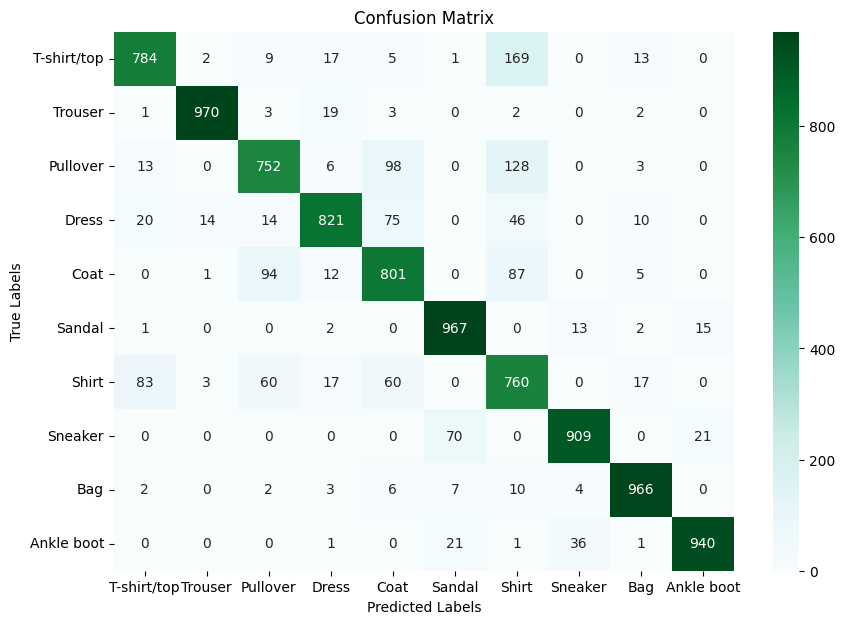

In [ ]:
y_predict = better_model.predict(x_test)
# print(y_predict[508])
true_labels = np.argmax(y_test_encode, axis=1)
# print(true_labels[508])

# confusion matrix
conf_matrix = confusion_matrix(true_labels, y_predict)

print("Confusion Matrix:")
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="BuGn", cbar=True,
            xticklabels=target_labels,
            yticklabels=target_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Q8**

In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

In [ ]:
def squared_error_loss(y_hat, y, sum_norm, regpara):
    m = y.shape[0]
    squared_errors = np.sum((y_hat - y) ** 2) / m
    loss = squared_errors + regpara / 2 * sum_norm
    return loss

In [ ]:
class NeuralNetwork:
    #initialize the network with construtor
    def __init__(self, layer_sizes, activation_func="sigmoid", weight_init="random"):
        self.layer_sizes = layer_sizes
        self.activation_func = activation_func
        self.weights, self.biases = self.init_network(layer_sizes, weight_init)

    #initializing function
    def init_network(self, layer_sizes, weight_init):
        weights = []
        biases = []
        # i = 0 to L-1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(len(layer_sizes) - 1):
            # "xavier" weight_initialization
            if weight_init == "xavier":
                stddev = np.sqrt(2 / (layer_sizes[i] + layer_sizes[i + 1]))
            #random initialization
            else:
                stddev = 0.1  # standard deviation for random initialization

            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * stddev
            bias = np.zeros((1, layer_sizes[i + 1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases

    #forward propagation
    def feedforward(self, X):
        a = {}
        h = {"h0": X}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            h_previous = h["h" + str(i-1)]   #input layer(data point)
            a_current = np.dot(h_previous, self.weights[i-1]) + self.biases[i-1]
            a["a" + str(i)] = a_current
            if i == len(self.layer_sizes) - 1:  # for output layer
                h_current = softmax(a_current)
            else:
                h_current = activation_functions[self.activation_func](a_current)   #sigmoid(a_current)
            h["h" + str(i)] = h_current
        y_hat = h["h" + str(len(self.layer_sizes) - 1)]
        return h, a, y_hat

In [ ]:
# for backward propagation and the optimizers
class backward_optimizer(NeuralNetwork):
    #backward propagation
    def backward(self, h, a, y, y_hat, regpara):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of squared-error w.r.t softmax function
        da = (y_hat - y) / y.shape[0]

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["dW" + str(i)] += regpara * self.weights[i-1] / y.shape[0]  #adding l2 regularization
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad

    #RMSPROP
    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square((grads["dW" + str(i + 1)]  + regpara * self.weights[i]))
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i]) / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


    #loss_accuracy function
    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = squared_error_loss(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy

    #for training the model by the optimizers
    def train(self,optimizer,max_epochs, eta,batch_size,regpara):
        if optimizer == 'rmsprop':
          self.rmsprop(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9, epsilon=1e-8)

In [ ]:
# highest accuracy:  -ac_tanh-hs_64-epc_10-hl_5-regu_0.0005-eta_0.001-optmz_rmsprop-batch_32-wght_random
layer_sizes = [784, 64,64,64,64,64, 10]

# # initializing the model
# model_forward = NeuralNetwork(layer_sizes, activation_func="tanh", weight_init="random")
# a,h,y_hat = model_forward.feedforward(x_train)

better_model_sq = backward_optimizer(layer_sizes, "tanh", "random")
better_model_sq.train("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 32,regpara = 0.0005)

End of Epoch 0, Loss: 0.36795276439135116, Accuracy: 0.7567592592592592
End of Epoch 0, Validation Loss: 0.37342584368645865, Validation Accuracy: 0.7543333333333333
End of Epoch 1, Loss: 0.3377493886972367, Accuracy: 0.7771851851851852
End of Epoch 1, Validation Loss: 0.34672116085467825, Validation Accuracy: 0.7645
End of Epoch 2, Loss: 0.337781271106482, Accuracy: 0.7706666666666667
End of Epoch 2, Validation Loss: 0.34810777202099374, Validation Accuracy: 0.7578333333333334
End of Epoch 3, Loss: 0.3369554963809201, Accuracy: 0.7691481481481481
End of Epoch 3, Validation Loss: 0.3481256296349461, Validation Accuracy: 0.758
End of Epoch 4, Loss: 0.3362830902367905, Accuracy: 0.7685925925925926
End of Epoch 4, Validation Loss: 0.34743573191276667, Validation Accuracy: 0.7571666666666667
End of Epoch 5, Loss: 0.33926229101732297, Accuracy: 0.7660740740740741
End of Epoch 5, Validation Loss: 0.3505799307143808, Validation Accuracy: 0.755
End of Epoch 6, Loss: 0.3374799491064162, Accurac

**Q10**

Based on your learnings above, give me 3 recommendations for what would work for the MNIST dataset (not Fashion-MNIST). Just to be clear, I am asking you to take your learnings based on extensive experimentation with one dataset and see if these learnings help on another dataset. If I give you a budget of running only 3 hyperparameter configurations as opposed to the large number of experiments you have run above then which 3 would you use and why. Report the accuracies that you obtain using these 3 configurations.

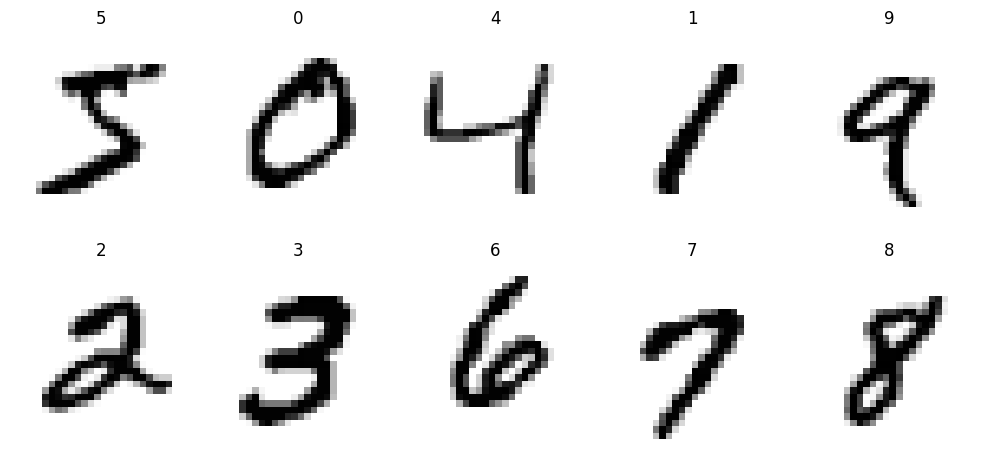

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Load the MNIST dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Split data into training and validation sets
x_val_mnist, y_val_mnist = x_train_mnist[54000:], y_train_mnist[54000:]  # Last 6,000 samples for validation
x_train_mnist, y_train_mnist = x_train_mnist[:54000], y_train_mnist[:54000]  # First 54,000 samples for training

# Define class labels for MNIST (digits 0-9)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Select one sample image for each digit class (0-9)
images, labels = [], []
unique_labels = set()  # To track selected classes

for i in range(len(y_train_mnist)):
    if y_train_mnist[i] not in unique_labels:  # Select only one sample per class
        images.append(x_train_mnist[i])
        labels.append(class_names[y_train_mnist[i]])
        unique_labels.add(y_train_mnist[i])
    if len(unique_labels) == 10:  # Stop once all 10 classes are covered
        break

# Plot the selected images in a 2×5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='binary')  # Display in binary colormap
    ax.set_title(labels[i])  # Set title to the digit label
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

In [ ]:
# vectorise the data
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 784)
# print(x_train.shape)
x_val_mnist  = x_val_mnist.reshape(x_val_mnist.shape[0], 784)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], 784)

# normalize
x_train_mnist = x_train_mnist / 255.0
x_test_mnist = x_test_mnist / 255.0
x_val_mnist  = x_val_mnist / 255.0
# print(x_train)

# One hot encoding for labels
def one_hot_enc(labels, dimension=10):
    # Creating an array of zeros of shape (number of labels, number of categories)
    one_hot_labels = np.zeros((len(labels), dimension))

    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels



#print(y_train_mnist[1023])
# one-hot encoding to the datasets
y_train_encode_mnist = one_hot_enc(y_train_mnist)
y_val_encode_mnist = one_hot_enc(y_val_mnist)
y_test_encode_mnist = one_hot_enc(y_test_mnist)

print(y_train_encode_mnist[1023])  # for verifying
print(y_train_encode_mnist.shape) #verifying

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(54000, 10)


In [ ]:
class NeuralNetwork_mnist:
    #initialize the network with construtor
    def __init__(self, layer_sizes, activation_func="sigmoid", weight_init="random"):
        self.layer_sizes = layer_sizes
        self.activation_func = activation_func
        self.weights, self.biases = self.init_network(layer_sizes, weight_init)
        self.momenta_weights, self.momenta_biases = self.init_momenta_for_mgd()

    #initializing function
    def init_network(self, layer_sizes, weight_init):
        weights = []
        biases = []
        # i = 0 to L-1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(len(layer_sizes) - 1):
            # "xavier" weight_initialization
            if weight_init == "xavier":
                stddev = np.sqrt(2 / (layer_sizes[i] + layer_sizes[i + 1]))
            #random initialization
            else:
                stddev = 0.1  # standard deviation for random initialization

            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * stddev
            bias = np.zeros((1, layer_sizes[i + 1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases

    #initializing momentums for mgd
    def init_momenta_for_mgd(self):
        momenta_weights = []
        momenta_biases = []
        for i in range(len(self.layer_sizes) - 1):
            v_weight = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            v_bias = np.zeros((1, self.layer_sizes[i + 1]))
            momenta_weights.append(v_weight)
            momenta_biases.append(v_bias)
        return momenta_weights, momenta_biases

    #forward propagation
    def feedforward(self, X):
        a = {}
        h = {"h0": X}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            h_previous = h["h" + str(i-1)]   #input layer(data point)
            a_current = np.dot(h_previous, self.weights[i-1]) + self.biases[i-1]
            a["a" + str(i)] = a_current
            if i == len(self.layer_sizes) - 1:  # for output layer
                h_current = softmax(a_current)
            else:
                h_current = activation_functions[self.activation_func](a_current)   #sigmoid(a_current)
            h["h" + str(i)] = h_current
        y_hat = h["h" + str(len(self.layer_sizes) - 1)]
        return h, a, y_hat

In [ ]:
layer_sizes = [784, 128, 10]

# initializing the model
model_forward_mnist = NeuralNetwork_mnist(layer_sizes, activation_func="sigmoid", weight_init="random")
_,_,y_hat = model_forward_mnist.feedforward(x_train_mnist)
print('A probability distribution over the 10 classes by feedforward NN before train:: \n',y_hat[5180])
# print(sum(y_hat[51]))
print('Corresponding labelled output:: \n',y_train_encode_mnist[5180])

A probability distribution over the 10 classes by feedforward NN before train:: 
 [0.18236941 0.23328932 0.06560289 0.07484518 0.13310517 0.07318707
 0.05377746 0.05563081 0.08974808 0.03844463]
Corresponding labelled output:: 
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
# for backward propagation and the optimizers
class backward_optimizer_mnist(NeuralNetwork_mnist):
    #backward propagation
    def backward(self, h, a, y, y_hat, regpara):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["dW" + str(i)] += regpara * self.weights[i-1] / y.shape[0]  #adding l2 regularization
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad


    #RMSPROP
    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square((grads["dW" + str(i + 1)]  + regpara * self.weights[i]))
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * (grads["dW" + str(i + 1)] + regpara * self.weights[i]) / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


    #ADAM
    def adam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for Adam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # Adam updates for each layer
              for i in range(len(self.weights)):
                  # updating momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_hat_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_hat_biases / (np.sqrt(v_hat_biases) + eps)

          # print loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


    #NADAM
    def nadam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs=5, eta=0.001, batch_size=16, regpara=0, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for NAdam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat, regpara)

              # NAdam updates for each layer
              for i in range(len(self.weights)):
                  # update momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * ((grads["dW" + str(i + 1)] + regpara * self.weights[i]) ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # NAG rule
                  m_bar_weights = beta1 * m_hat_weights + ((1 - beta1) * (grads["dW" + str(i + 1)] + regpara * self.weights[i])) / (1 - beta1 ** (epoch + 1))
                  m_bar_biases = beta1 * m_hat_biases + ((1 - beta1) * grads["db" + str(i + 1)]) / (1 - beta1 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_bar_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_bar_biases / (np.sqrt(v_hat_biases) + eps)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")


          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")



    #loss_accuracy function
    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = cross_entropy(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy

    #for training the model by the optimizers
    def train_mnist(self,optimizer,max_epochs, eta,batch_size,regpara):
        if optimizer == 'rmsprop':
          self.rmsprop(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta,batch_size, regpara, beta=0.9, epsilon=1e-8)
        elif optimizer == 'adam':
          self.adam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)
        elif optimizer == 'nadam':
          self.nadam(x_train, y_train_encode,x_val, y_val_encode,  max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8)

In [ ]:
# highest accuracy 1:
layer_sizes = [784, 128,128,128,128,128, 10]

better_model_mnist2 = backward_optimizer_mnist(layer_sizes, "tanh", "random")
better_model_mnist2.train_mnist("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 64,regpara = 0.0005)

End of Epoch 0, Loss: 0.7591820163890395, Accuracy: 0.823462962962963
End of Epoch 0, Validation Loss: 0.781373011970195, Validation Accuracy: 0.8173333333333334
End of Epoch 1, Loss: 0.6374494528135795, Accuracy: 0.8468703703703704
End of Epoch 1, Validation Loss: 0.6669194697837697, Validation Accuracy: 0.8348333333333333
End of Epoch 2, Loss: 0.5648578850213426, Accuracy: 0.8599629629629629
End of Epoch 2, Validation Loss: 0.5976366682470464, Validation Accuracy: 0.851
End of Epoch 3, Loss: 0.5243808147940412, Accuracy: 0.8677962962962963
End of Epoch 3, Validation Loss: 0.5619735504490149, Validation Accuracy: 0.856
End of Epoch 4, Loss: 0.4946265063621451, Accuracy: 0.8722407407407408
End of Epoch 4, Validation Loss: 0.5358256876293145, Validation Accuracy: 0.8578333333333333
End of Epoch 5, Loss: 0.46900114513730723, Accuracy: 0.8776666666666667
End of Epoch 5, Validation Loss: 0.5138577573028559, Validation Accuracy: 0.8618333333333333
End of Epoch 6, Loss: 0.451366409897737, Ac

In [ ]:
# highest accuracy 2:
layer_sizes = [784, 128,128,128,128,128, 10]

better_model_mnist2 = backward_optimizer_mnist(layer_sizes, "tanh", "random")
better_model_mnist2.train_mnist("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 16,regpara = 0.0005)

End of Epoch 0, Loss: 0.6547887327586737, Accuracy: 0.8401296296296297
End of Epoch 0, Validation Loss: 0.6795947995839935, Validation Accuracy: 0.8296666666666667
End of Epoch 1, Loss: 0.5429718411833953, Accuracy: 0.8578703703703704
End of Epoch 1, Validation Loss: 0.5703218097306385, Validation Accuracy: 0.8556666666666667
End of Epoch 2, Loss: 0.5291760218707755, Accuracy: 0.853925925925926
End of Epoch 2, Validation Loss: 0.5649006806753357, Validation Accuracy: 0.8466666666666667
End of Epoch 3, Loss: 0.5004173189380821, Accuracy: 0.859537037037037
End of Epoch 3, Validation Loss: 0.539783163564847, Validation Accuracy: 0.8501666666666666
End of Epoch 4, Loss: 0.4830773732449929, Accuracy: 0.8622222222222222
End of Epoch 4, Validation Loss: 0.5204662597824034, Validation Accuracy: 0.8483333333333334
End of Epoch 5, Loss: 0.46813134947628005, Accuracy: 0.8657407407407407
End of Epoch 5, Validation Loss: 0.5098014567181823, Validation Accuracy: 0.8531666666666666
End of Epoch 6, Lo

In [ ]:
# highest accuracy 3:
layer_sizes = [784, 64,64,64,64,64, 10]

better_model_mnist1 = backward_optimizer_mnist(layer_sizes, "tanh", "random")
better_model_mnist1.train_mnist("rmsprop",max_epochs = 10,eta = 0.001,batch_size = 32,regpara = 0.0005)

End of Epoch 0, Loss: 0.5792170416276344, Accuracy: 0.8334259259259259
End of Epoch 0, Validation Loss: 0.6007713761350648, Validation Accuracy: 0.8265
End of Epoch 1, Loss: 0.5374489935860526, Accuracy: 0.8401481481481482
End of Epoch 1, Validation Loss: 0.5735542205725788, Validation Accuracy: 0.8273333333333334
End of Epoch 2, Loss: 0.5009970783124971, Accuracy: 0.8514814814814815
End of Epoch 2, Validation Loss: 0.5400386080885148, Validation Accuracy: 0.8385
End of Epoch 3, Loss: 0.4771225984144174, Accuracy: 0.8588333333333333
End of Epoch 3, Validation Loss: 0.5173438486910591, Validation Accuracy: 0.8443333333333334
End of Epoch 4, Loss: 0.4715837464390461, Accuracy: 0.8586296296296296
End of Epoch 4, Validation Loss: 0.5130146819427059, Validation Accuracy: 0.844
End of Epoch 5, Loss: 0.45529146338629767, Accuracy: 0.8639444444444444
End of Epoch 5, Validation Loss: 0.4984433553239116, Validation Accuracy: 0.8505
End of Epoch 6, Loss: 0.45528473936593, Accuracy: 0.862629629629